In [2]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd

In [3]:
container_data = pd.read_csv("data/containers.csv")
port_data = pd.read_csv("data/ports.csv")
ship_data = pd.read_csv("data/ships.csv")

In [2]:
class ShipyardEnv(gym.Env):
    def __init__(self):
        super(ShipyardEnv, self).__init__()
        self.grid = np.zeros((10, 10), dtype=int)
        self.crane_position = (0, 0)
        self.action_space = gym.spaces.Discrete(6)
        self.observation_space = gym.spaces.Box(low=0, high=4, shape=(10, 10), dtype=np.int32)
        self.fig, self.ax = plt.subplots()
        self.max_steps = 100  # Define a maximum step limit
        self.current_step = 0  # Track current steps in the episode
    
    def get_state(self):
        # Return a flattened version of the grid and crane position as part of the state
        flattened_grid = self.grid.flatten()
        crane_position = np.array(self.crane_position)
        return np.concatenate((flattened_grid, crane_position))  # Concatenate grid and crane position
    
    def reset(self):
        self.grid = np.zeros((10, 10), dtype=int)
        self.crane_position = (0, 0)
        self.current_step = 0  # Reset step count
        return self.get_state()  # Use the get_state() method

    def step(self, action):
        reward = 0
        done = False

        # Define crane movement logic
        if action == 0 and self.crane_position[0] > 0:
            self.crane_position = (self.crane_position[0] - 1, self.crane_position[1])
        elif action == 1 and self.crane_position[0] < 9:
            self.crane_position = (self.crane_position[0] + 1, self.crane_position[1])
        elif action == 2 and self.crane_position[1] > 0:
            self.crane_position = (self.crane_position[0], self.crane_position[1] - 1)
        elif action == 3 and self.crane_position[1] < 9:
            self.crane_position = (self.crane_position[0], self.crane_position[1] + 1)
        elif action == 4 and self.grid[self.crane_position] > 0:
            self.grid[self.crane_position] -= 1
            reward = 1
        elif action == 5 and self.grid[self.crane_position] < 4:
            self.grid[self.crane_position] += 1
            reward = 1

        # Increase step count
        self.current_step += 1

        # Check if done (either all containers placed or step limit reached)
        if np.sum(self.grid) == 40 or self.current_step >= self.max_steps:
            done = True
            if np.sum(self.grid) == 40:
                reward = 10  # Bonus reward for completing the task

        return self.get_state(), reward, done, {}
    
    def render(self, mode="human"):
        if mode == "human":
            # Clear the plot
            self.ax.clear()
            
            # Create a heatmap of the grid
            heatmap = self.ax.imshow(self.grid, cmap="Blues", vmin=0, vmax=4)
            
            # Mark the crane position with a red dot
            self.ax.scatter(self.crane_position[1], self.crane_position[0], color='red', s=100, label='Crane')
            
            # Set title and labels
            plt.title('Shipyard Container Layout')
            plt.pause(0.1)  # Small pause to allow real-time update
        else:
            raise NotImplementedError(f"Render mode '{mode}' is not implemented.")



In [3]:
class QLearningAgent:
    def __init__(self, env):
        self.env = env
        # Use a dictionary for the Q-table to store (state, action) pairs
        self.q_table = {}
        self.alpha = 0.1  # Learning rate
        self.gamma = 0.99  # Discount factor
        self.epsilon = 1.0  # Exploration rate (start with exploration)
        self.epsilon_decay = 0.995
        self.epsilon_min = 0.01

    def choose_action(self, state):
        # Epsilon-greedy action selection
        if random.uniform(0, 1) < self.epsilon:
            return self.env.action_space.sample()  # Explore
        return self.best_action(state)

    def best_action(self, state):
        state_key = self.get_state_key(state)
        if state_key not in self.q_table:
            # If the state is not yet in the Q-table, initialize all actions to 0
            self.q_table[state_key] = np.zeros(self.env.action_space.n)
        return np.argmax(self.q_table[state_key])

    def learn(self, state, action, reward, next_state):
        state_key = self.get_state_key(state)
        next_state_key = self.get_state_key(next_state)

        # Initialize Q-values if states are not in the Q-table
        if state_key not in self.q_table:
            self.q_table[state_key] = np.zeros(self.env.action_space.n)
        if next_state_key not in self.q_table:
            self.q_table[next_state_key] = np.zeros(self.env.action_space.n)

        # Q-learning update rule
        best_next_action = np.argmax(self.q_table[next_state_key])
        td_target = reward + self.gamma * self.q_table[next_state_key][best_next_action]
        self.q_table[state_key][action] += self.alpha * (td_target - self.q_table[state_key][action])

    def get_state_key(self, state):
        # Assuming state is a flattened array followed by crane_position
        grid_size = 100  # 10x10 grid = 100 elements
        grid_state = tuple(state[:grid_size])  # First part of state (grid)
        crane_position = tuple(state[grid_size:])  # Crane position
        
        # Return the grid state and crane position as a tuple to use as the key
        return (grid_state, crane_position)


    def train(self, episodes):
        for episode in range(episodes):
            state = self.env.reset()
            done = False
            while not done:
                action = self.choose_action(state)
                next_state, reward, done, _ = self.env.step(action)
                
                # Learn from the transition
                self.learn(state, action, reward, next_state)
                state = next_state

                # Render the environment
                self.env.render()
            
            # Decrease epsilon to reduce exploration over time
            self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)


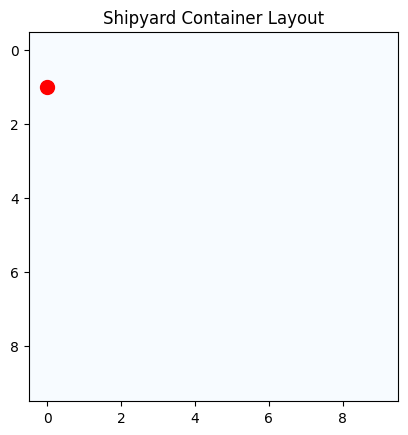

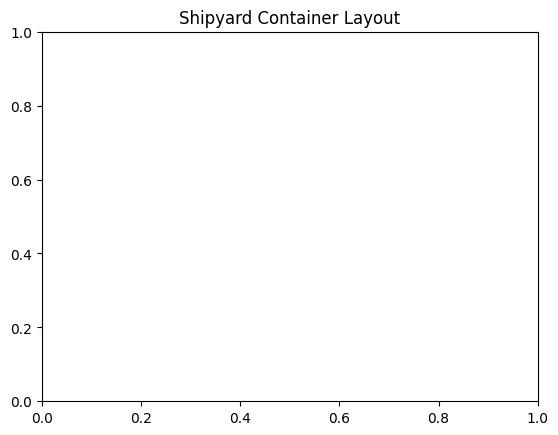

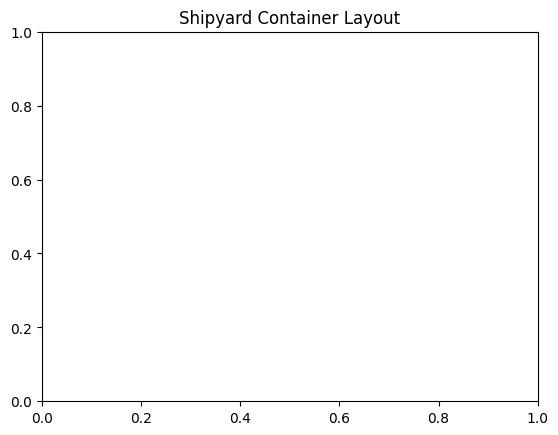

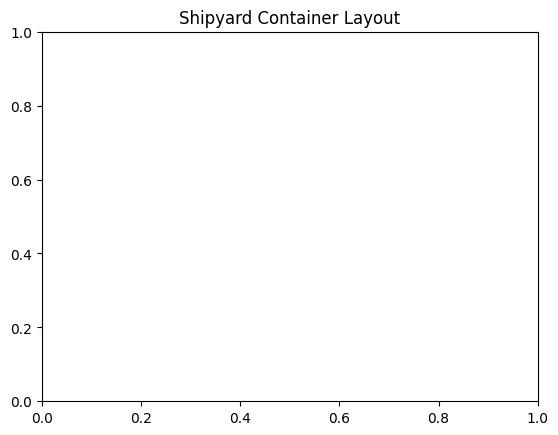

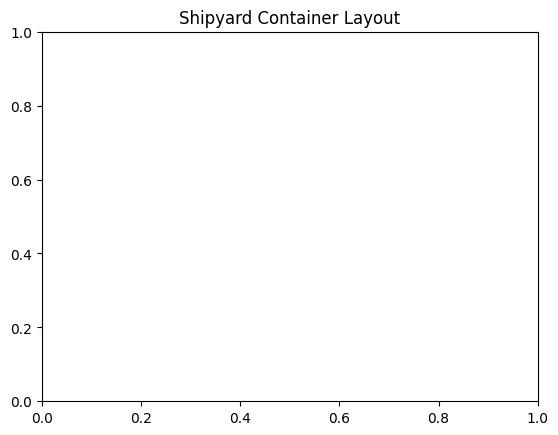

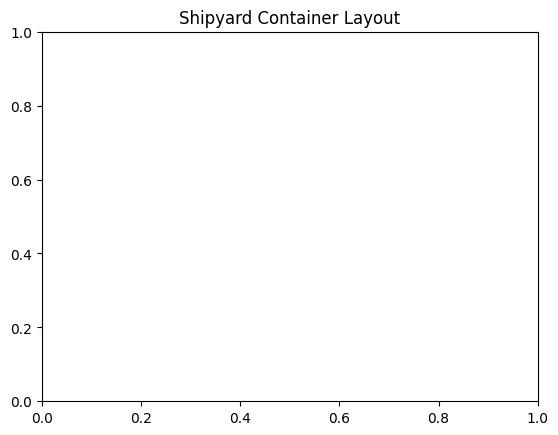

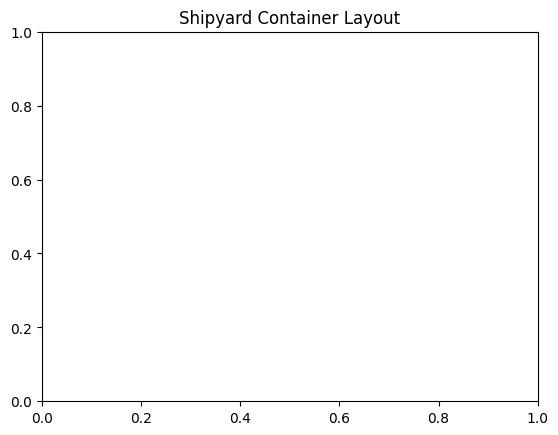

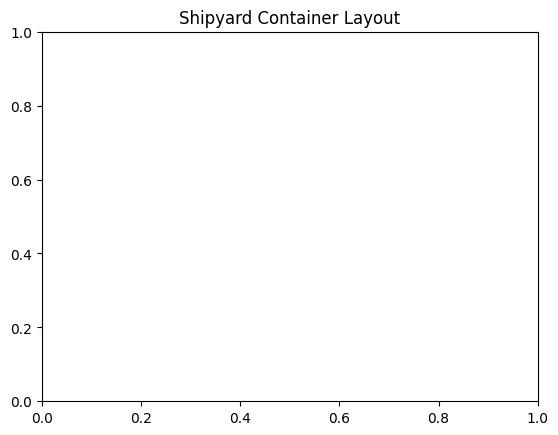

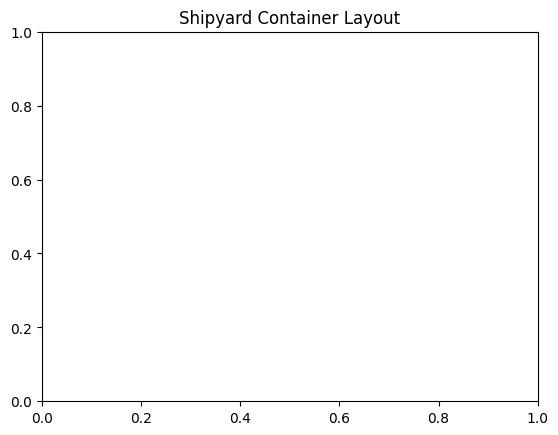

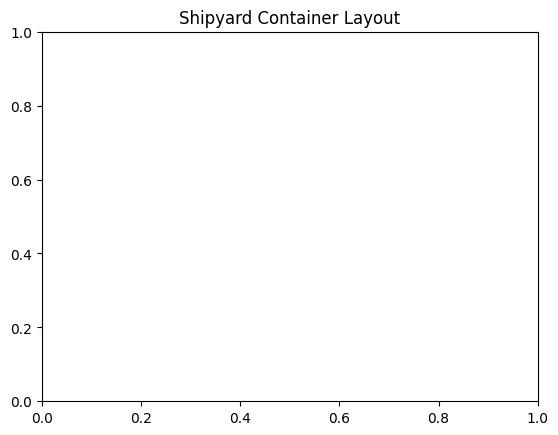

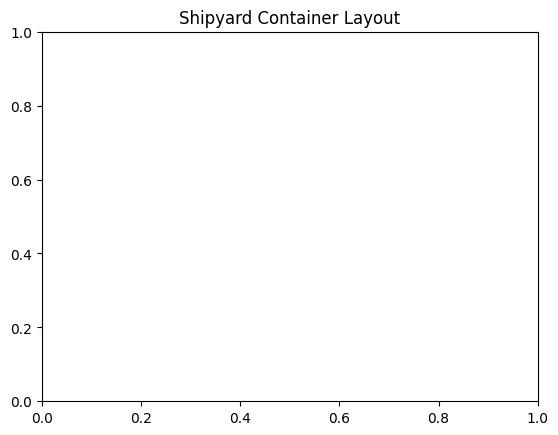

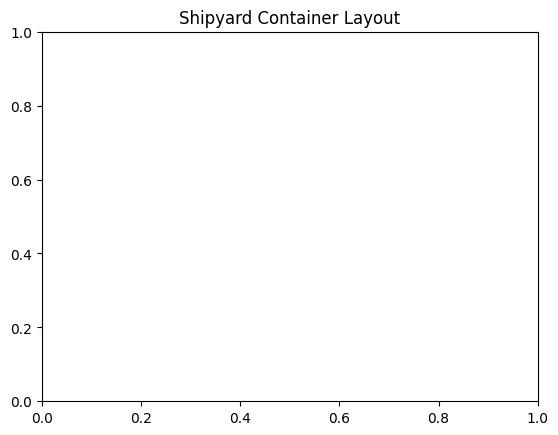

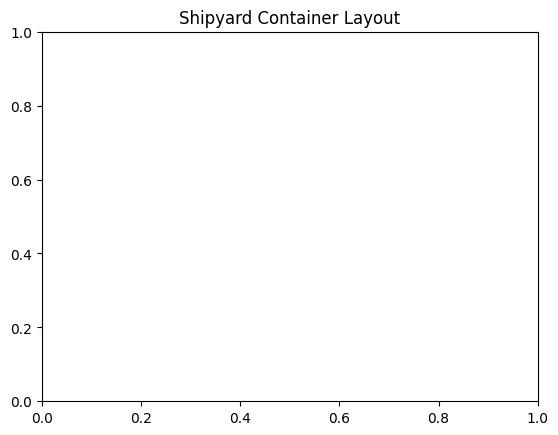

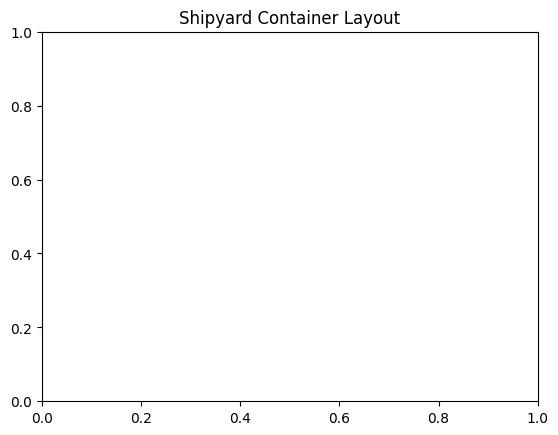

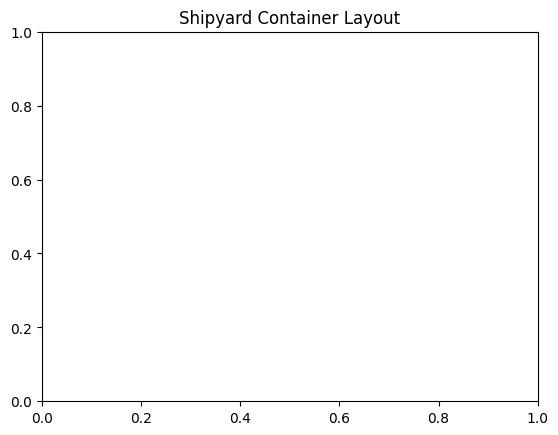

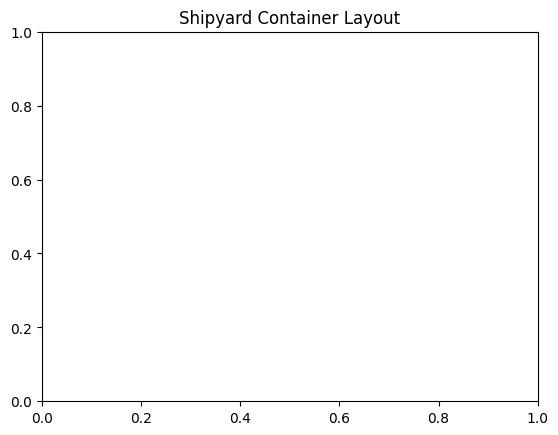

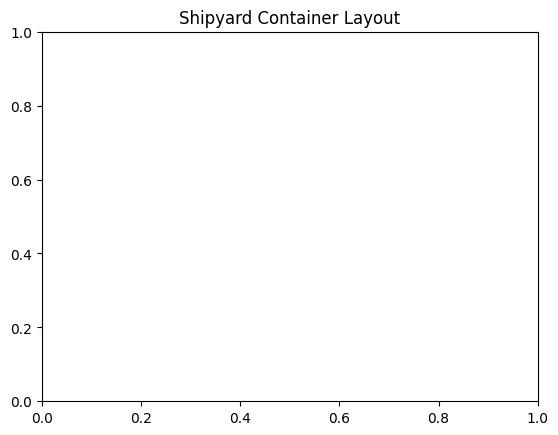

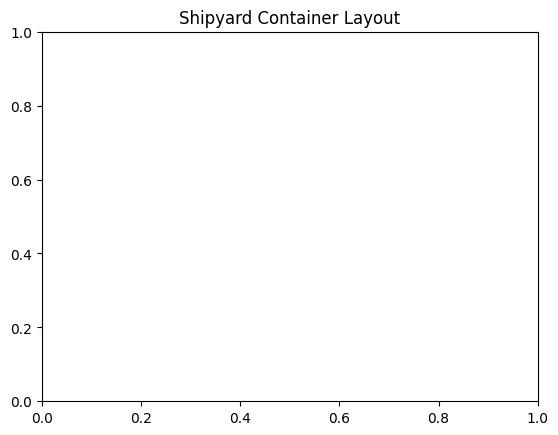

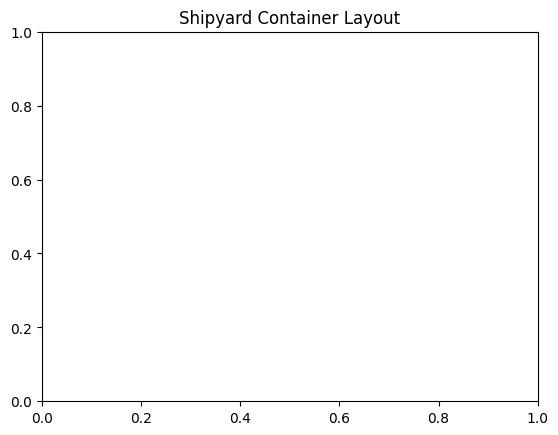

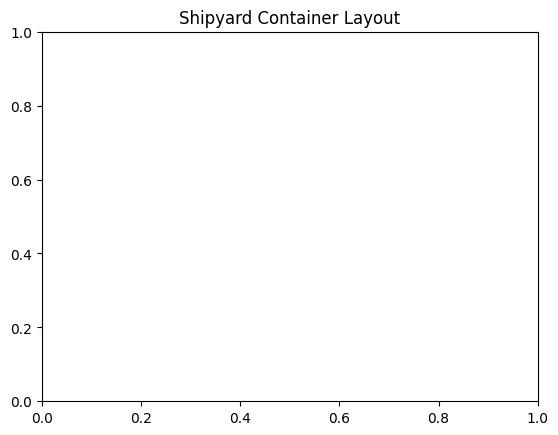

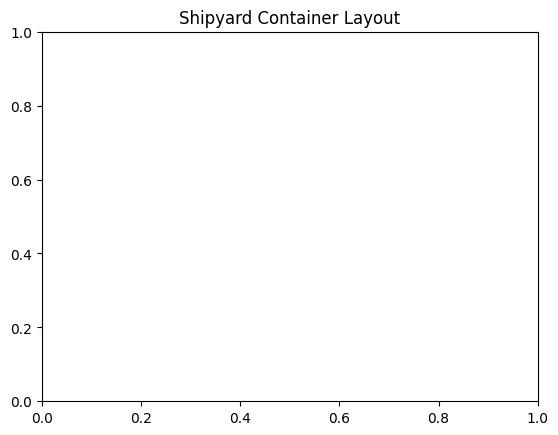

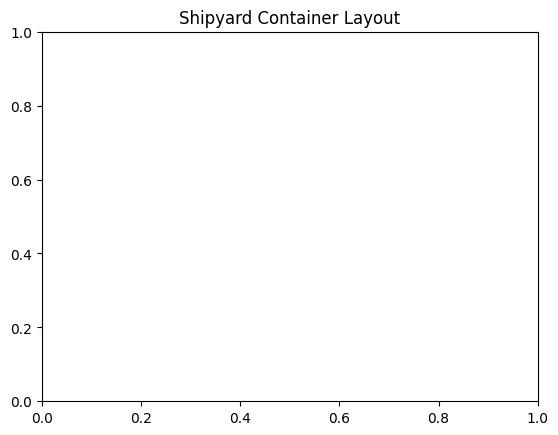

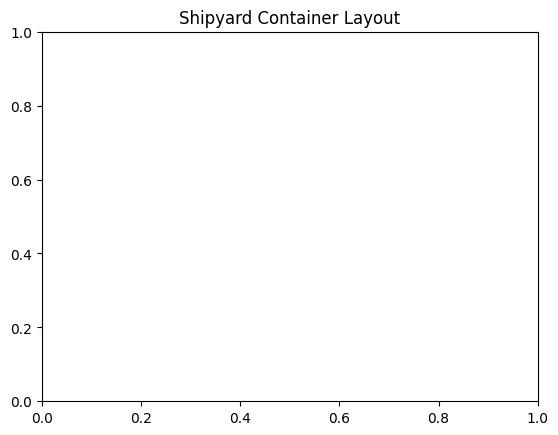

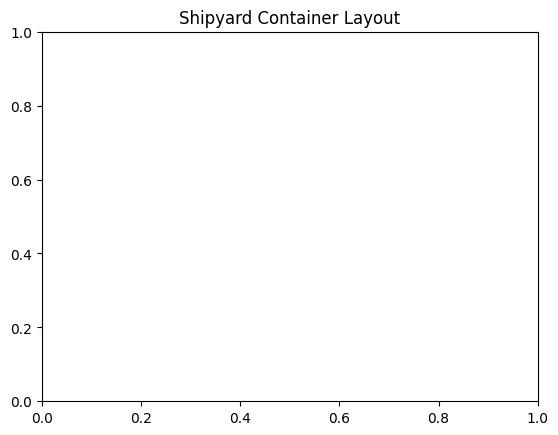

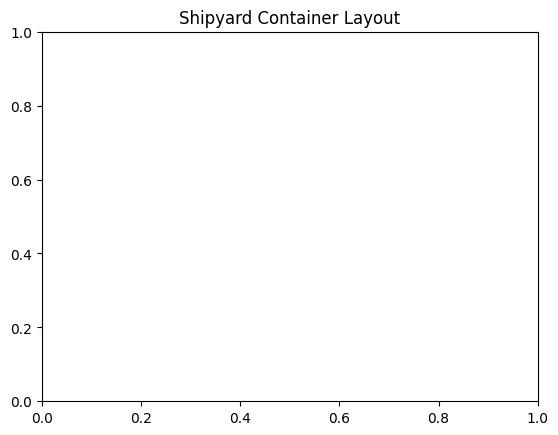

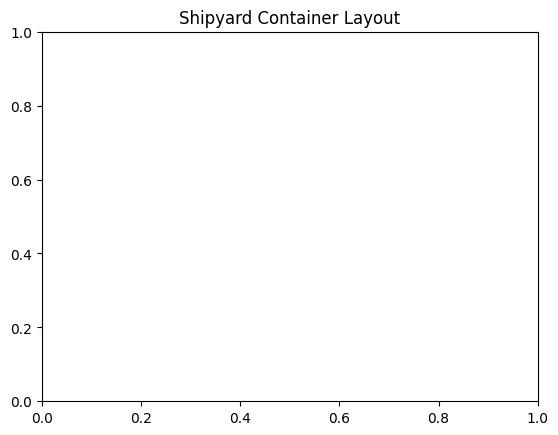

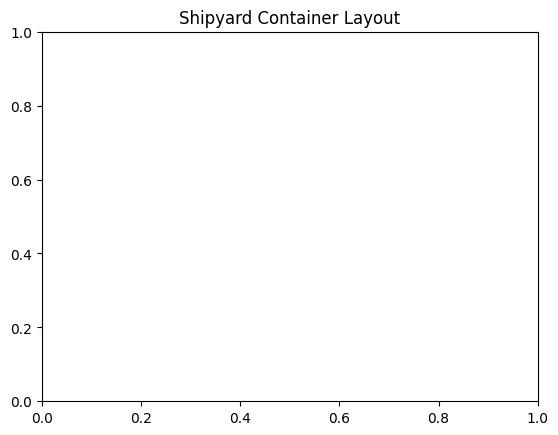

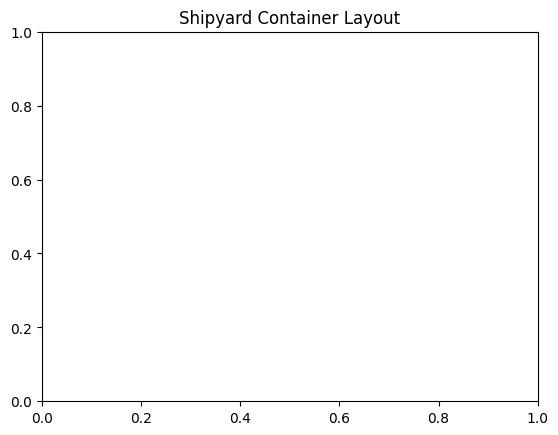

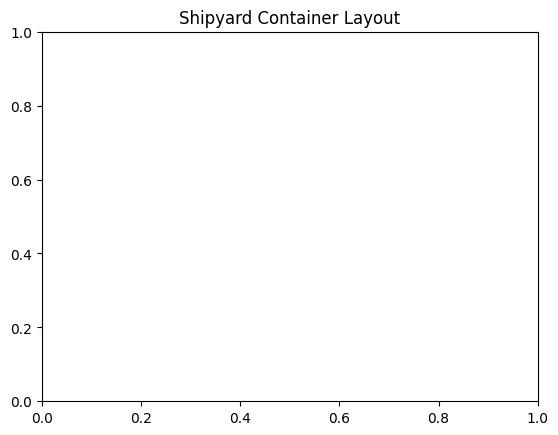

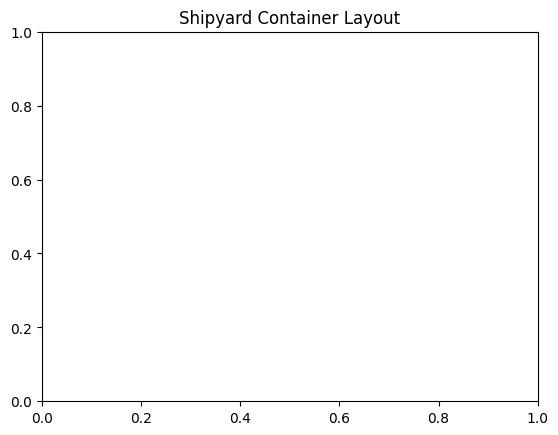

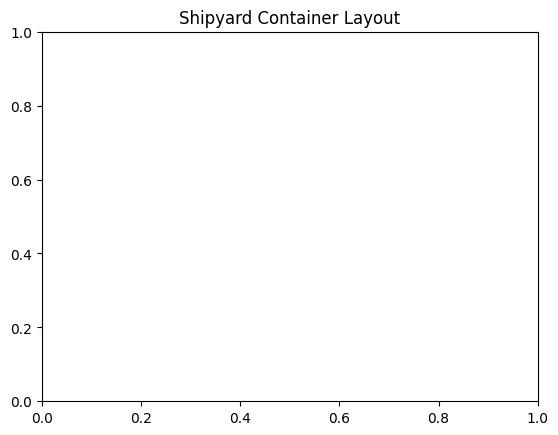

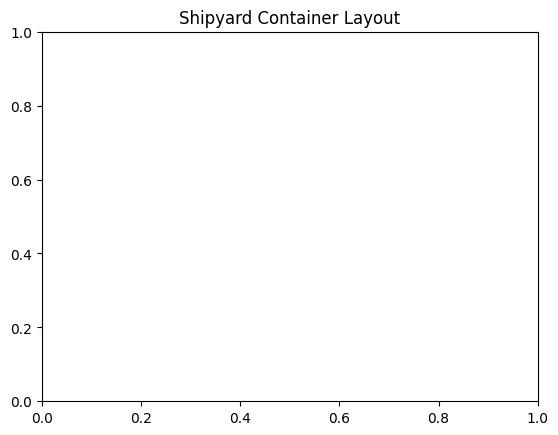

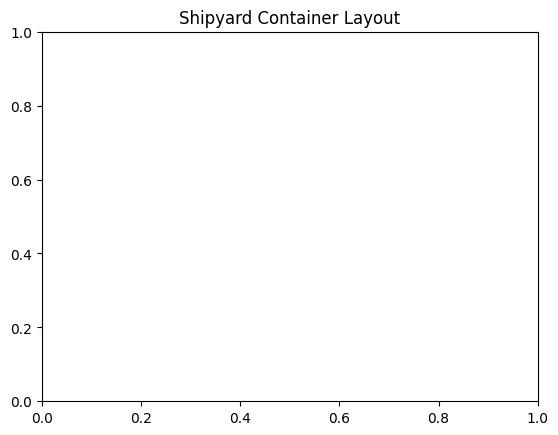

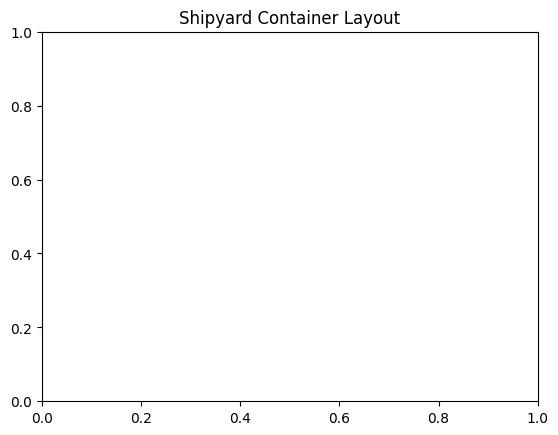

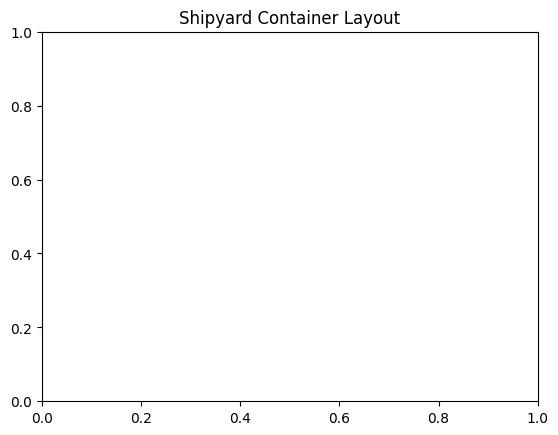

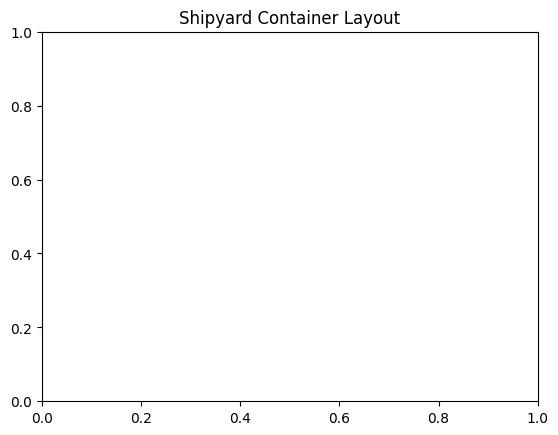

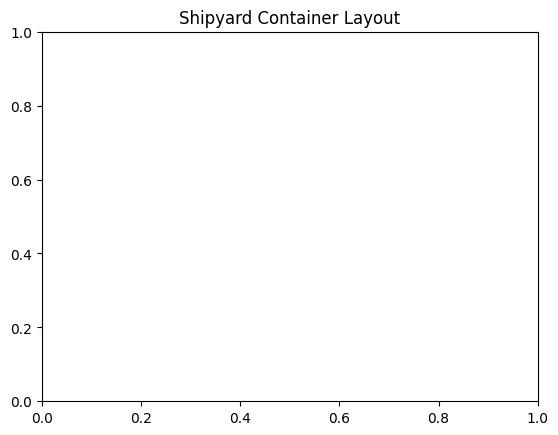

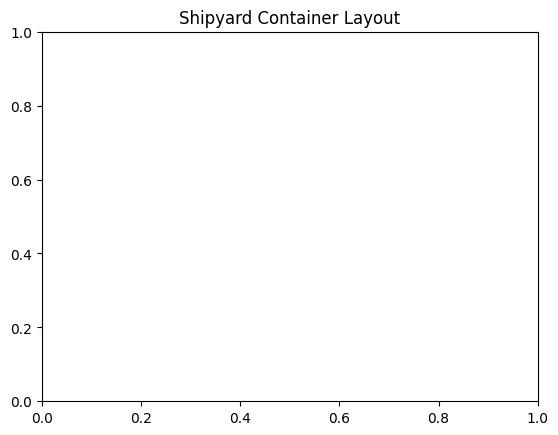

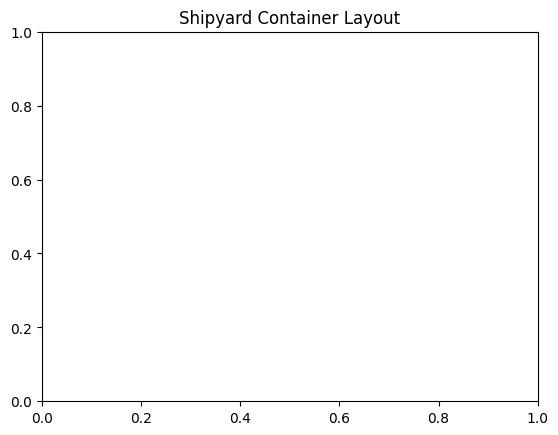

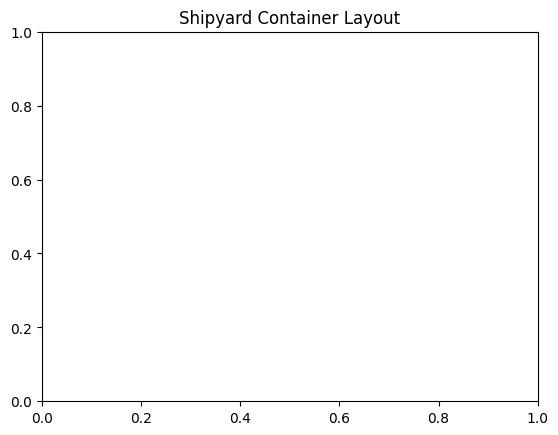

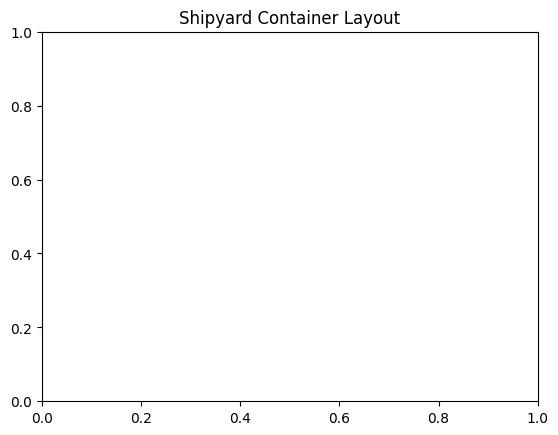

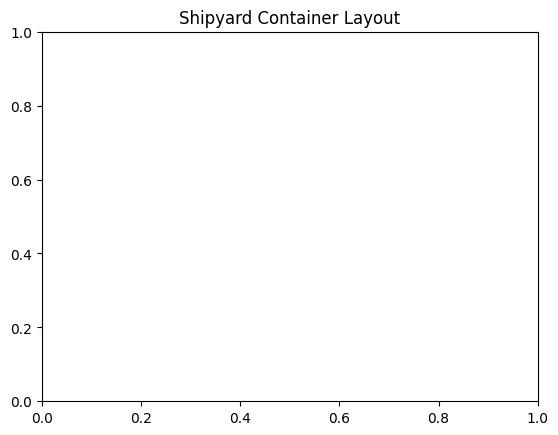

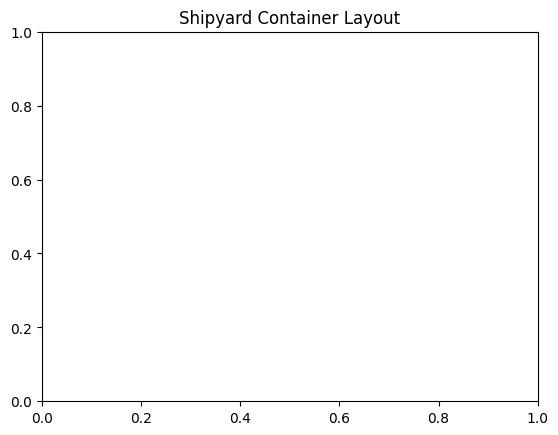

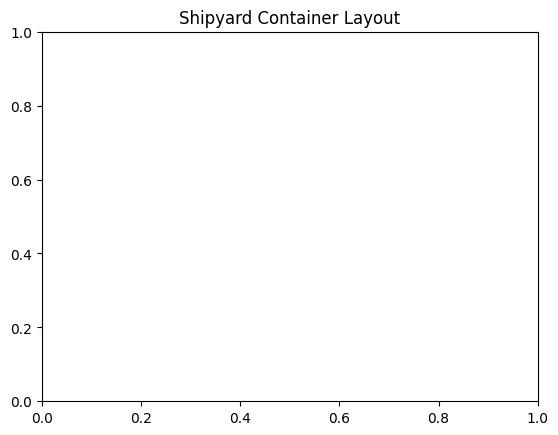

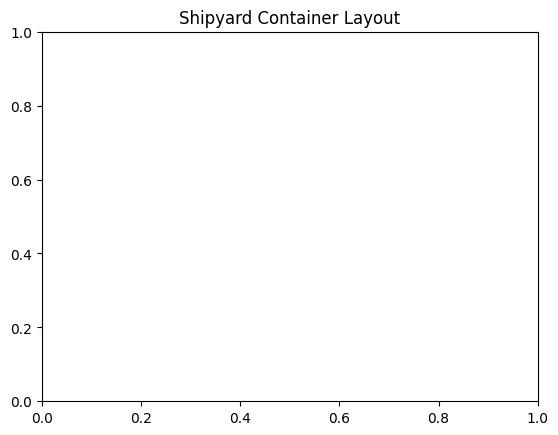

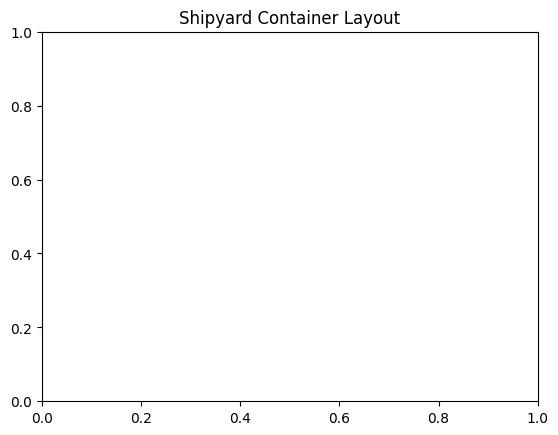

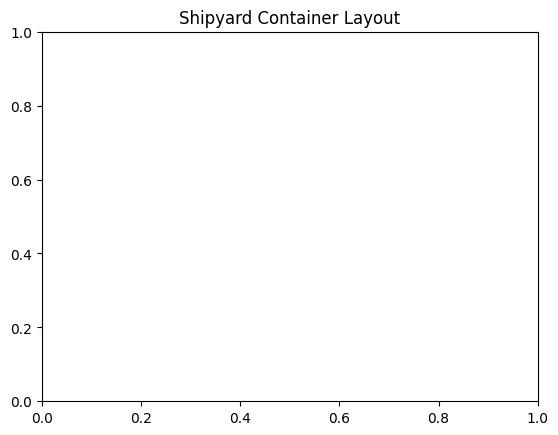

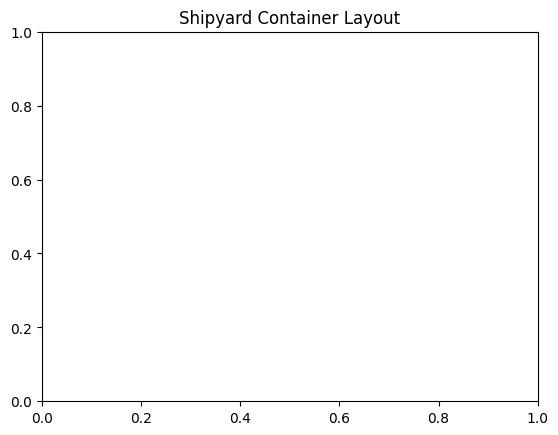

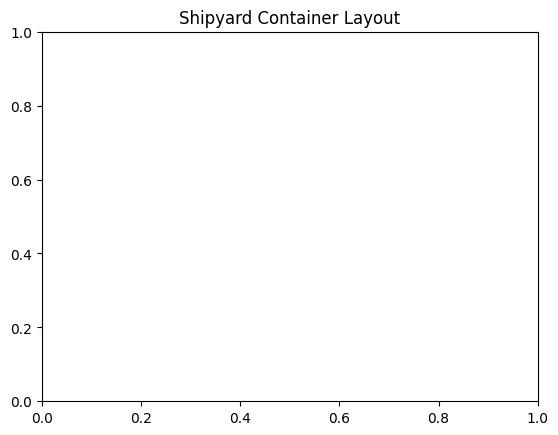

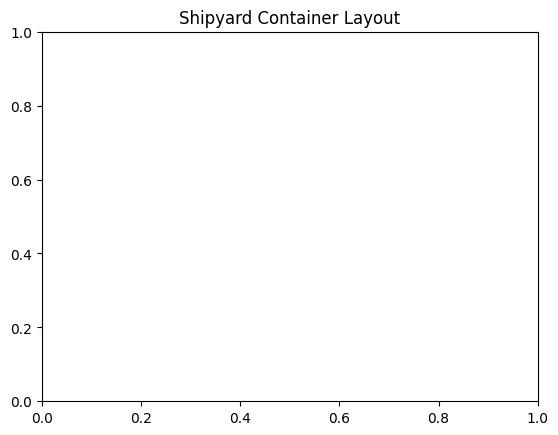

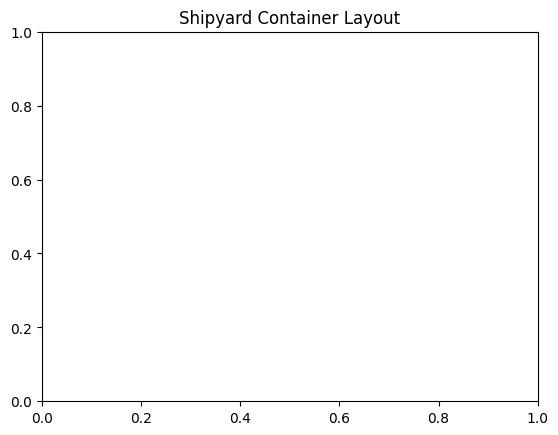

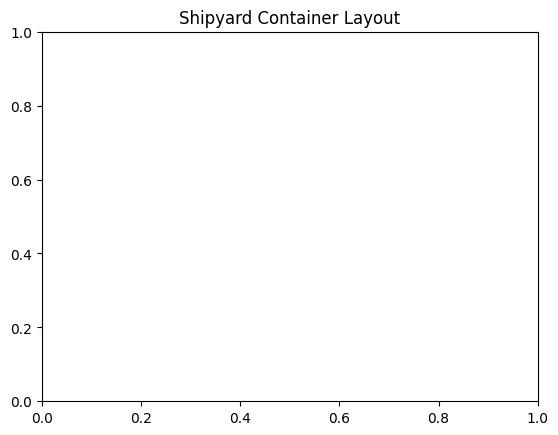

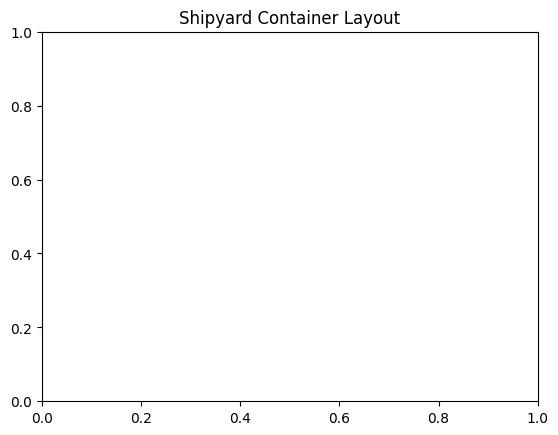

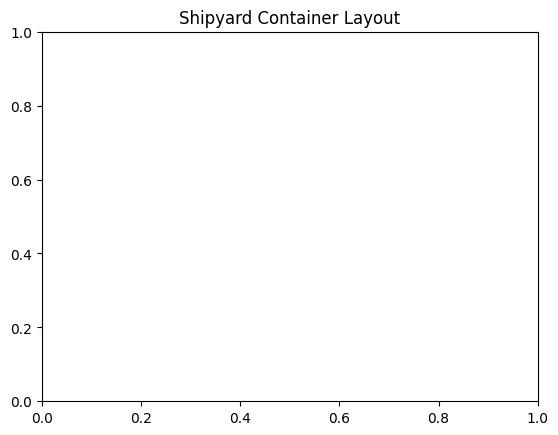

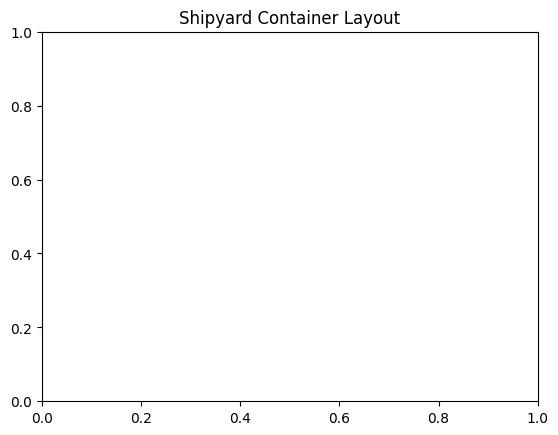

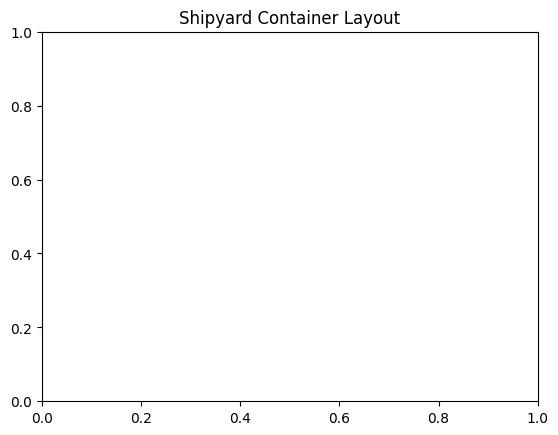

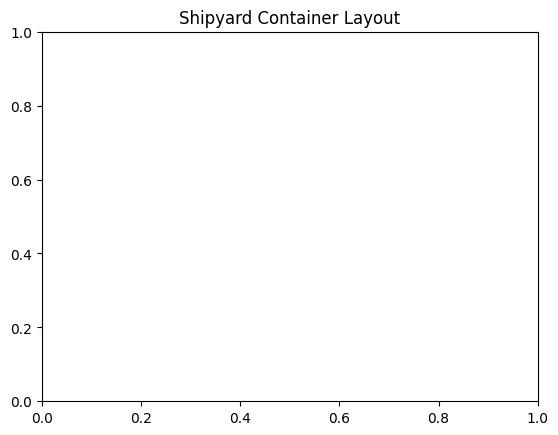

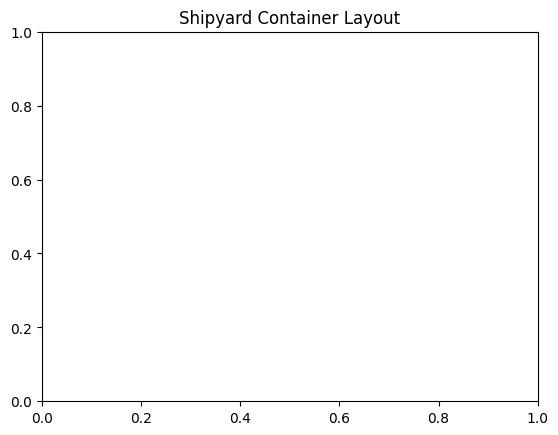

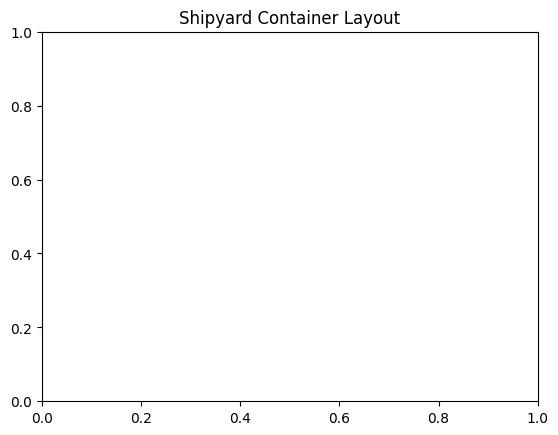

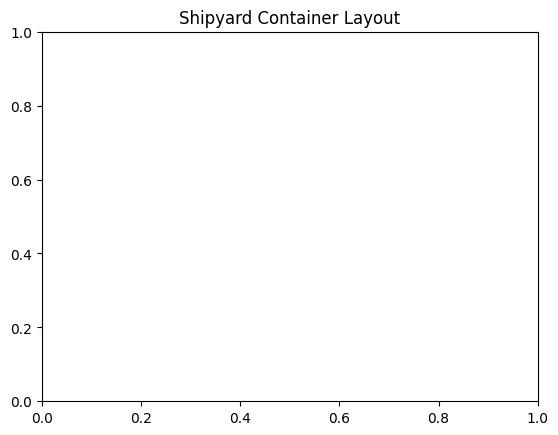

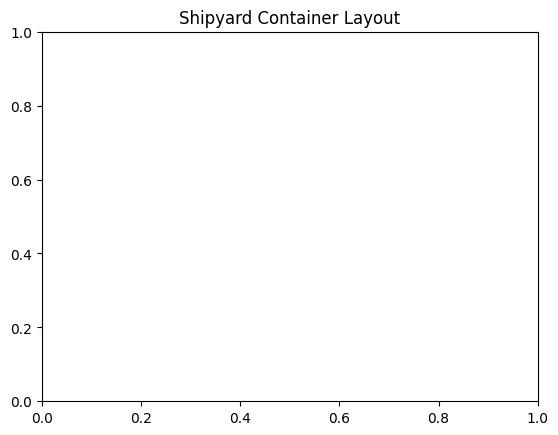

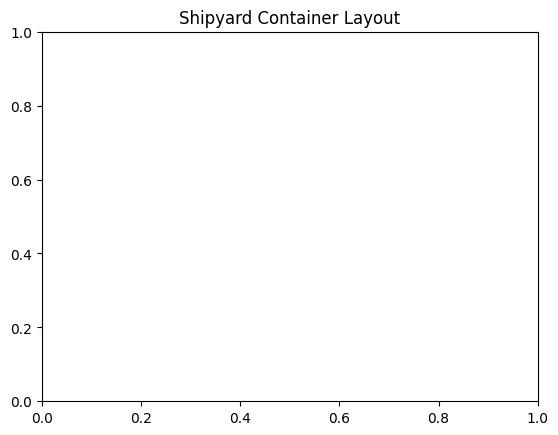

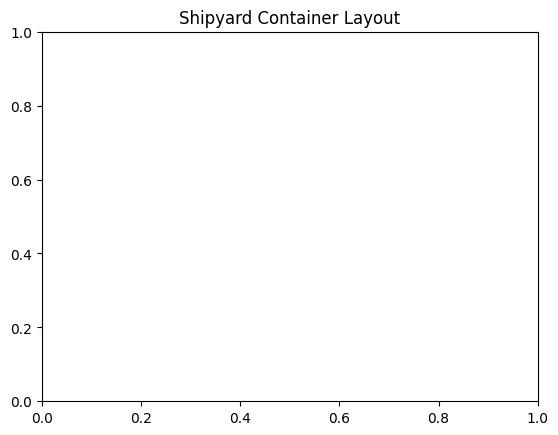

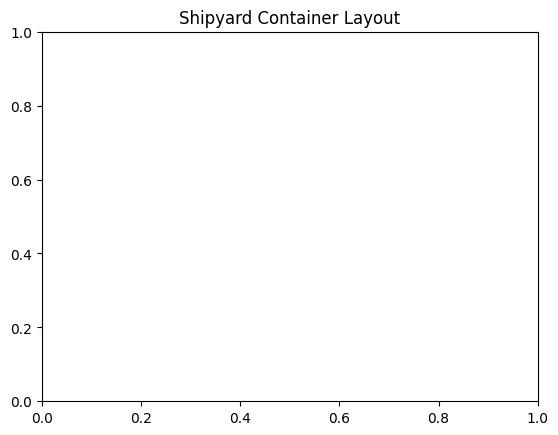

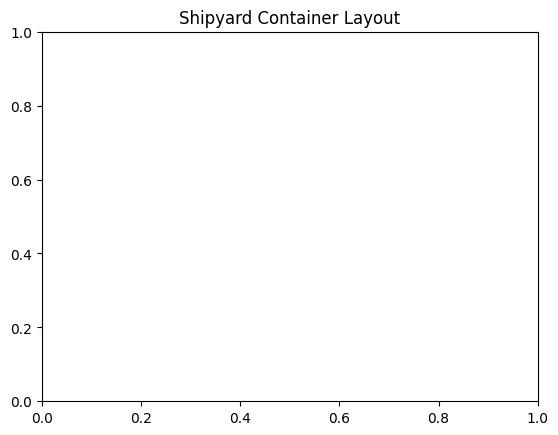

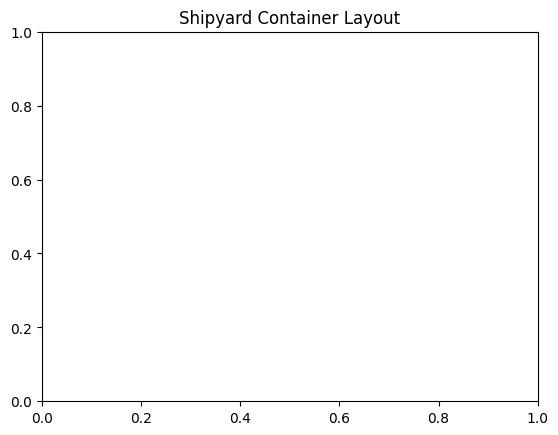

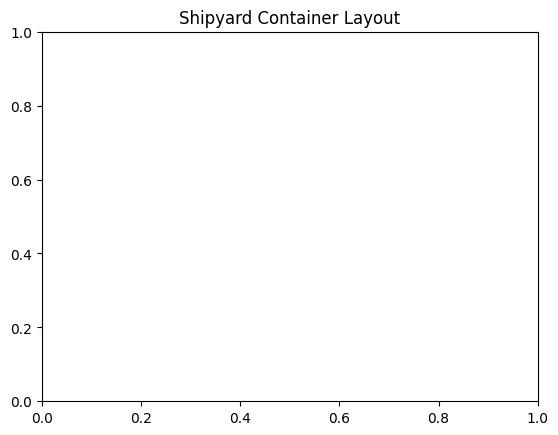

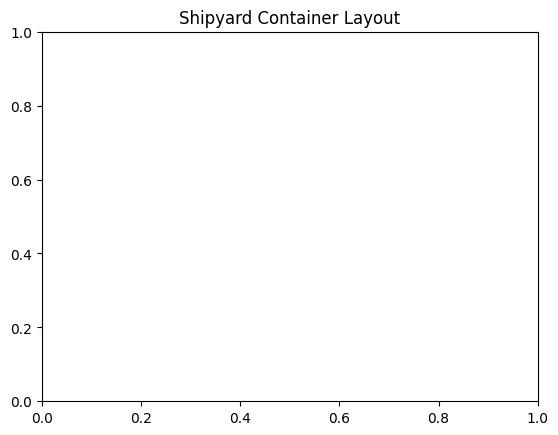

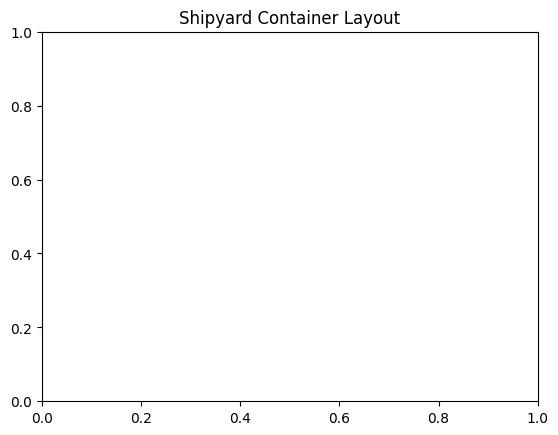

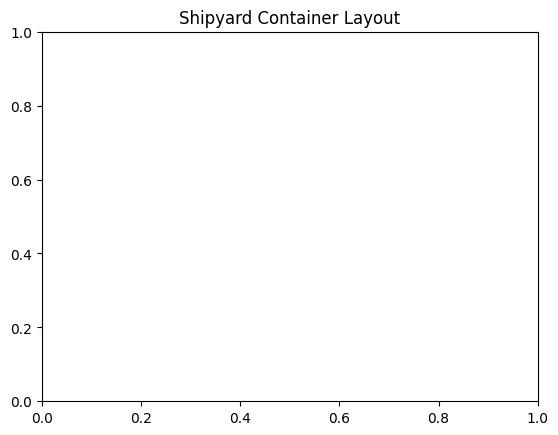

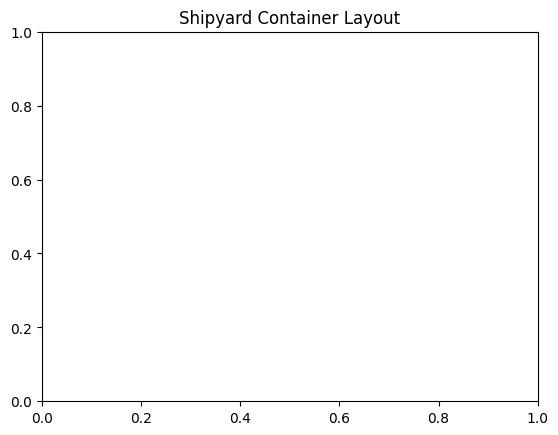

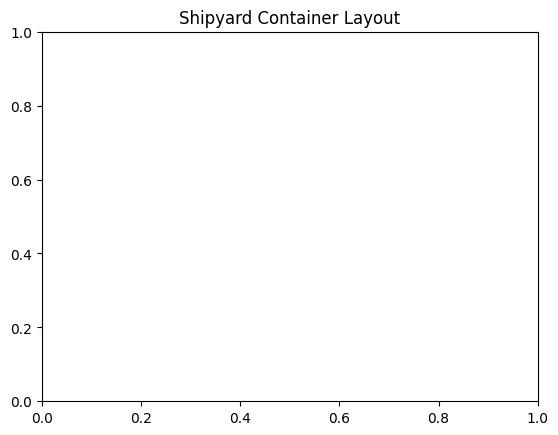

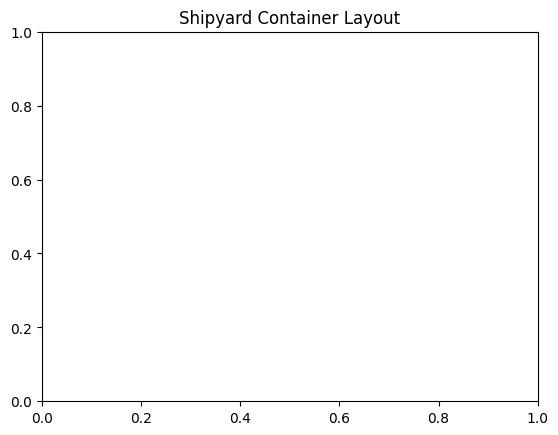

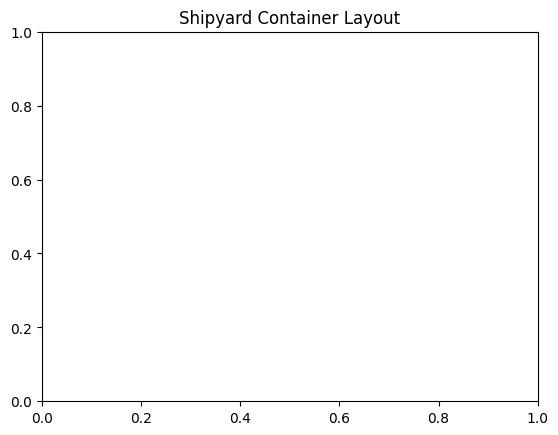

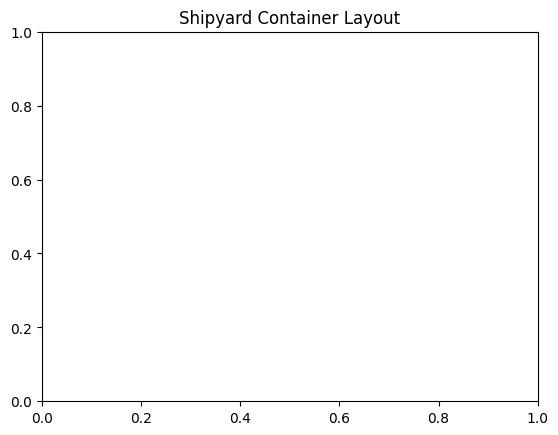

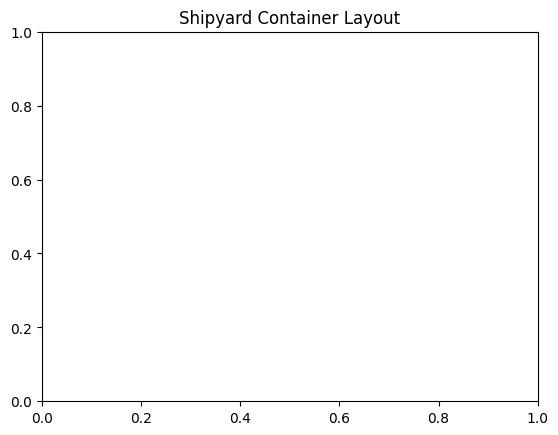

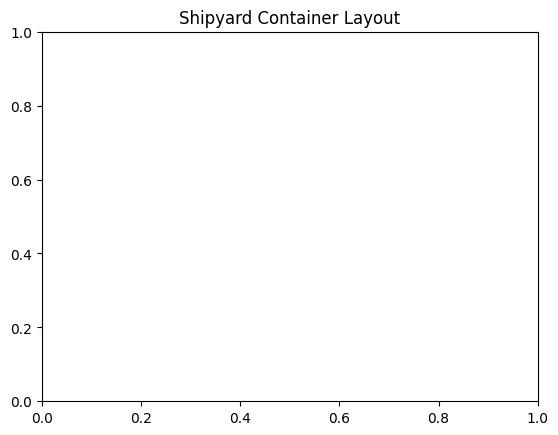

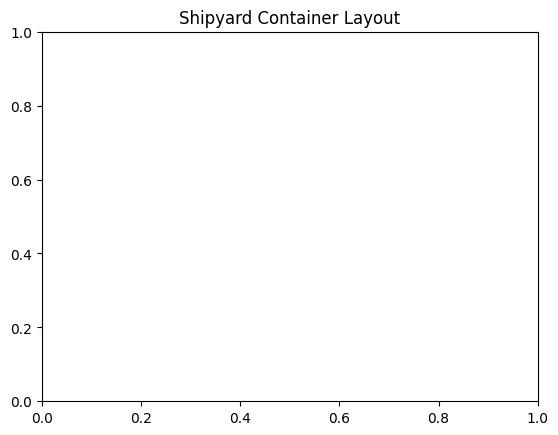

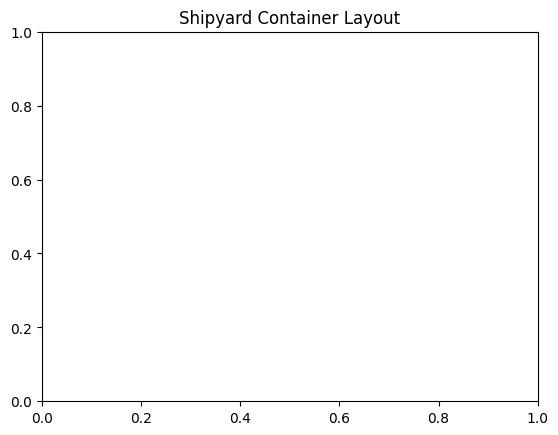

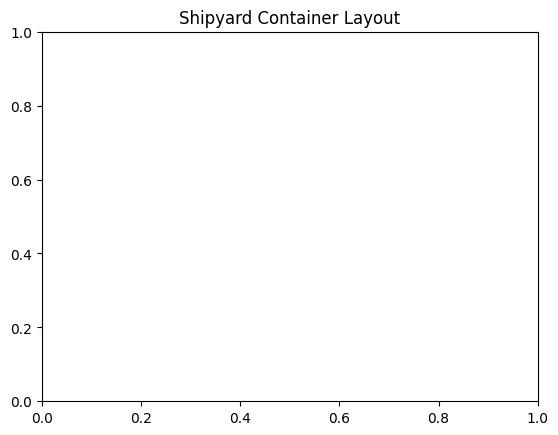

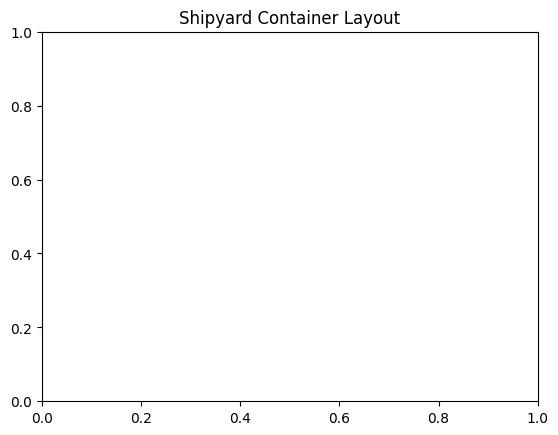

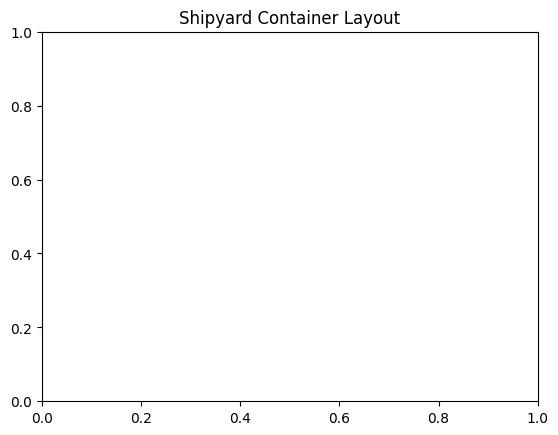

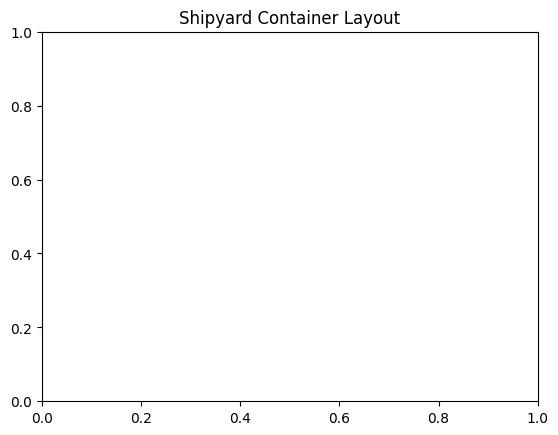

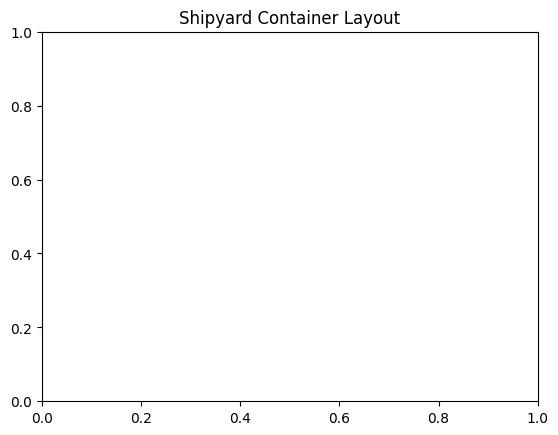

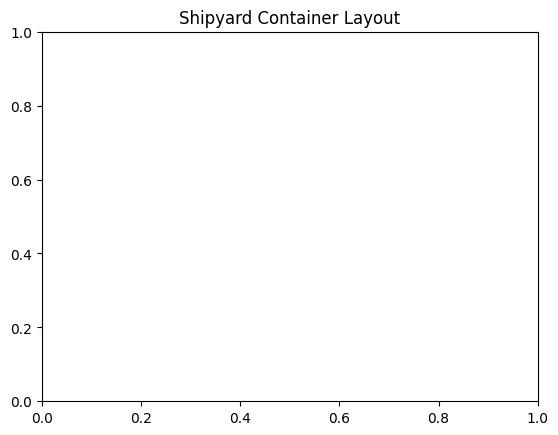

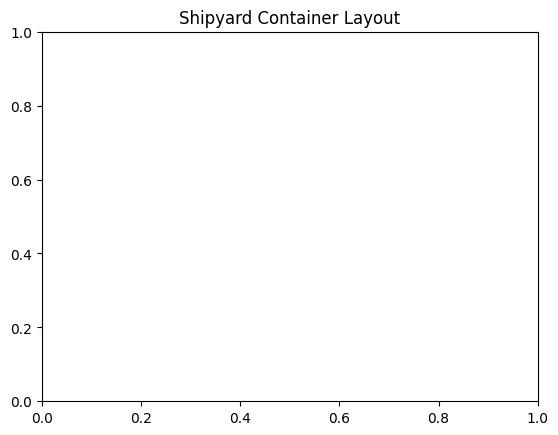

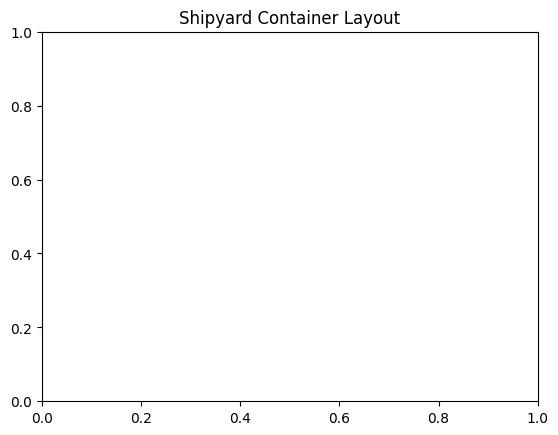

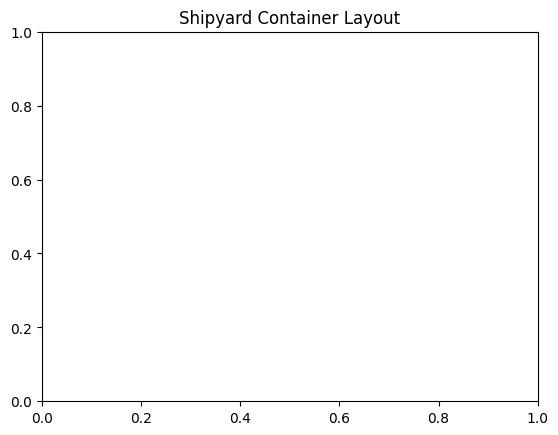

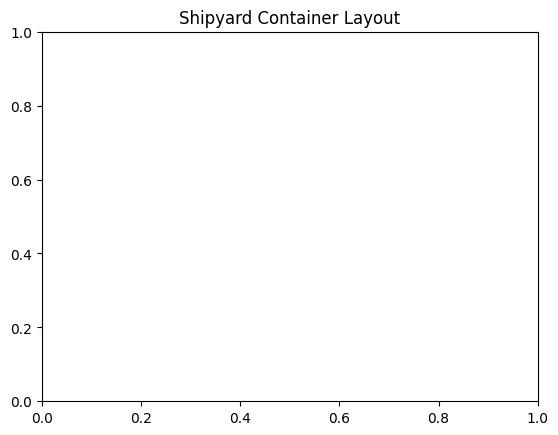

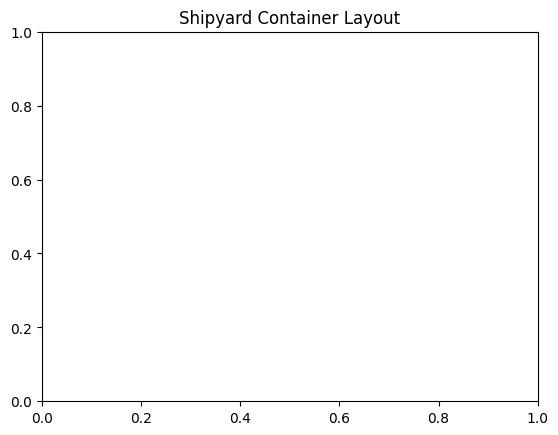

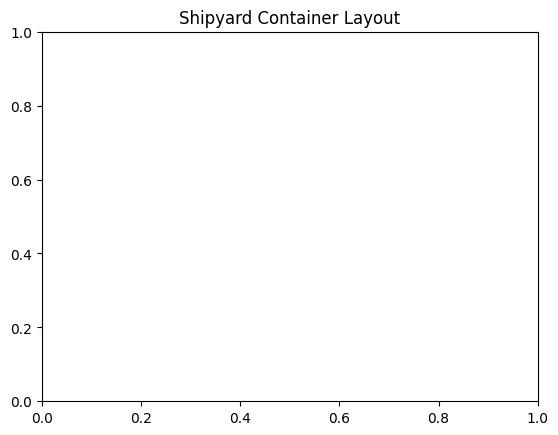

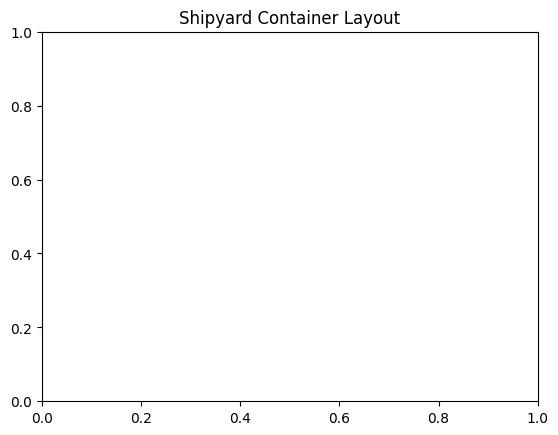

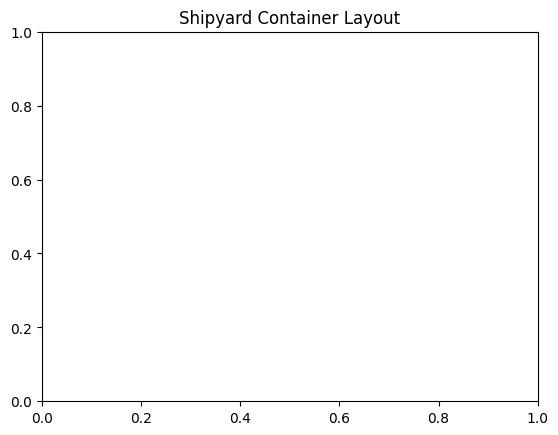

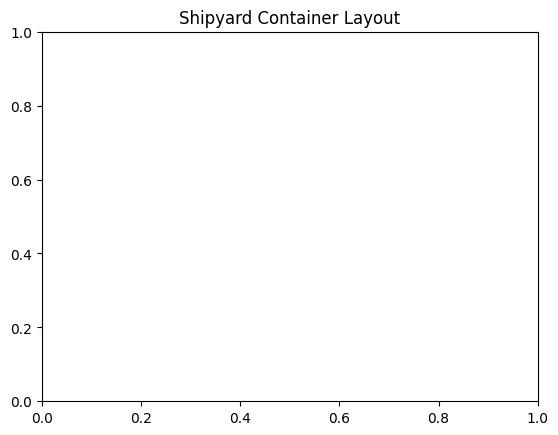

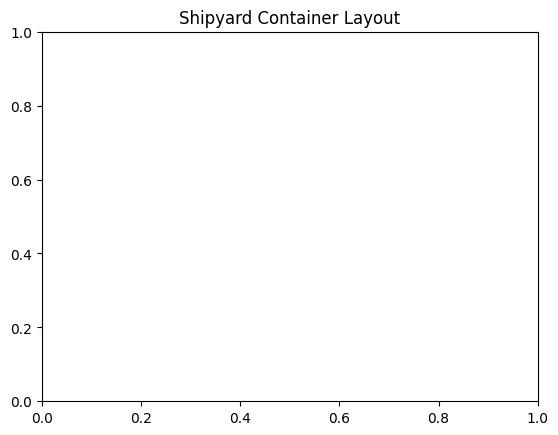

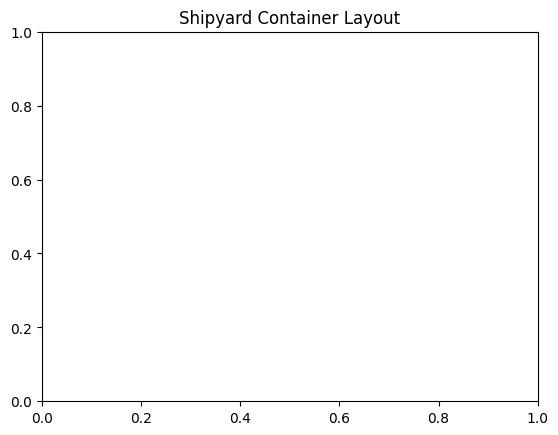

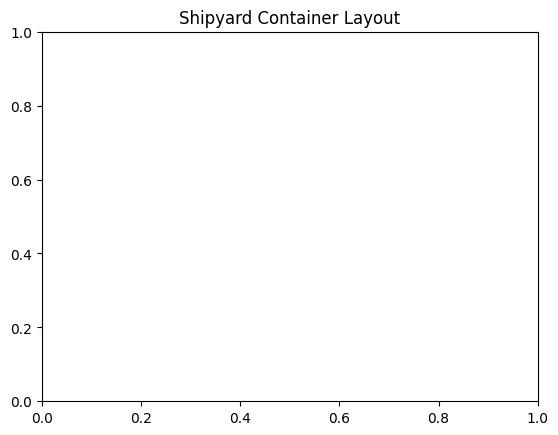

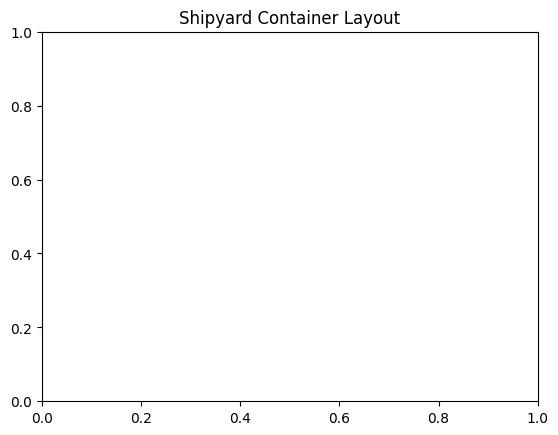

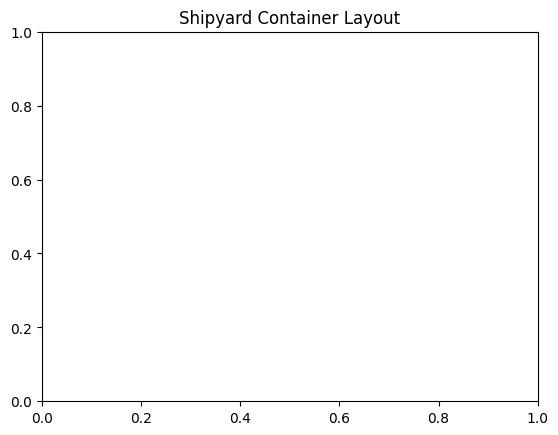

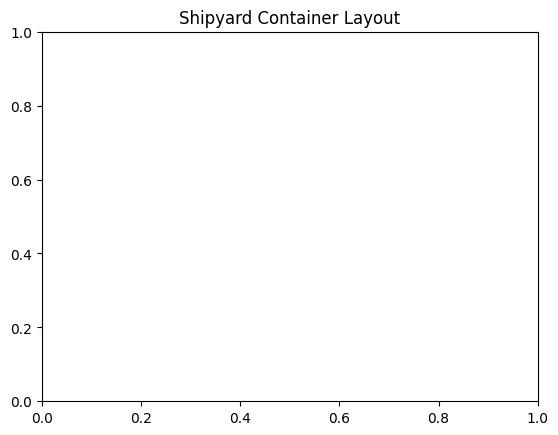

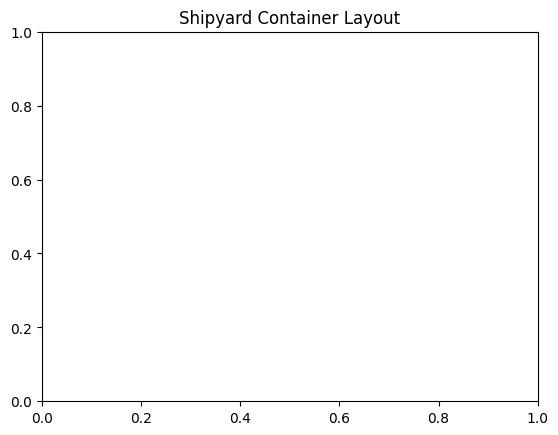

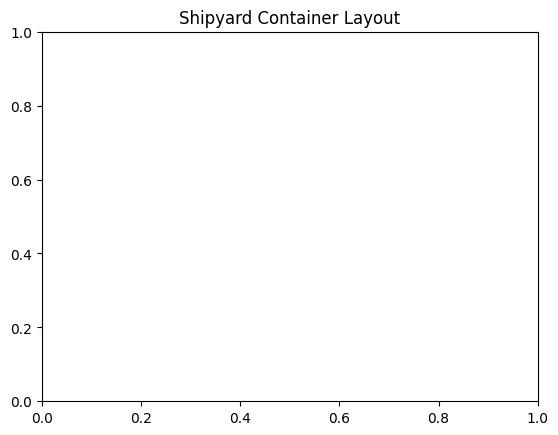

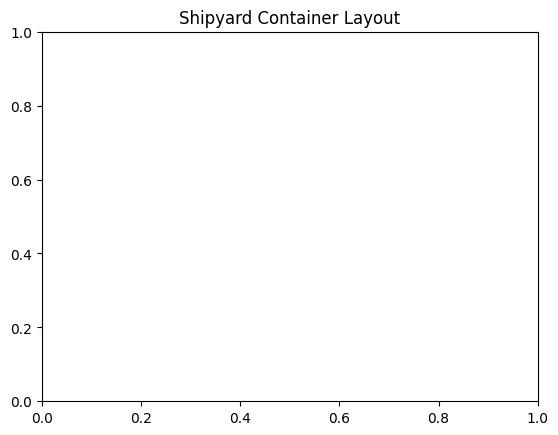

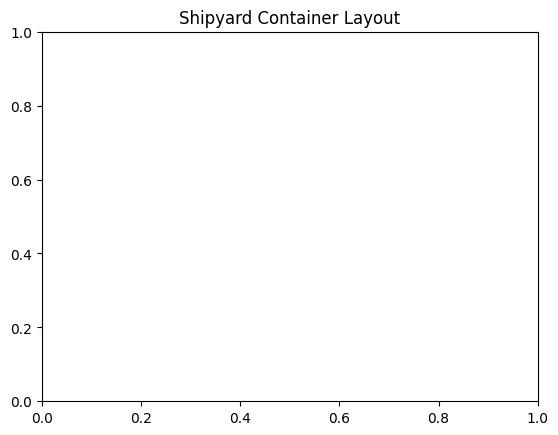

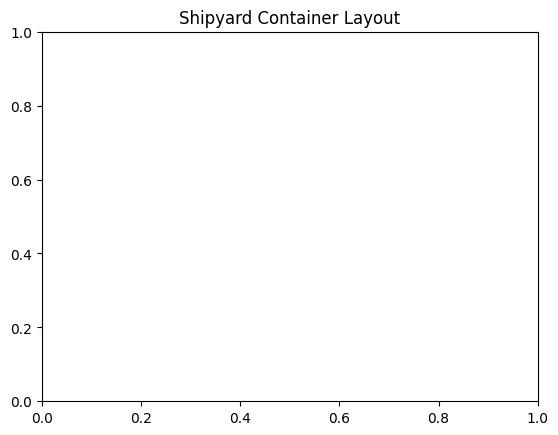

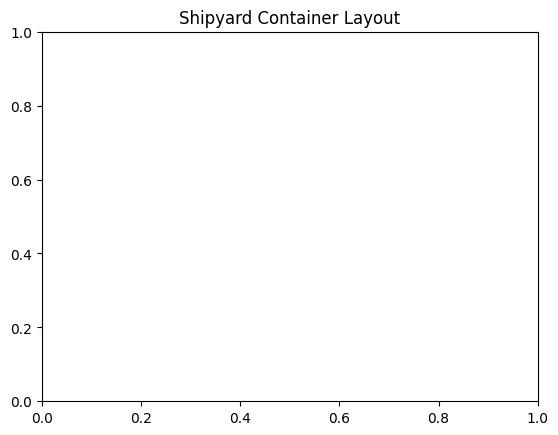

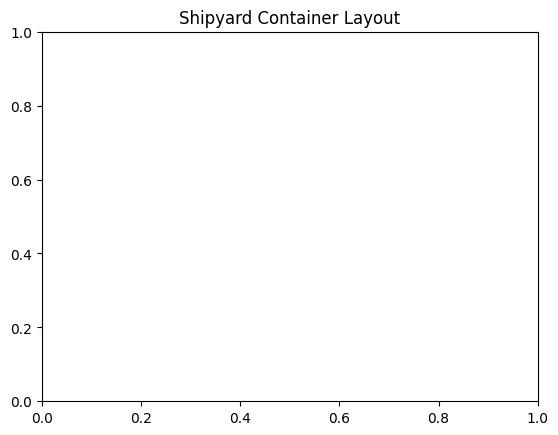

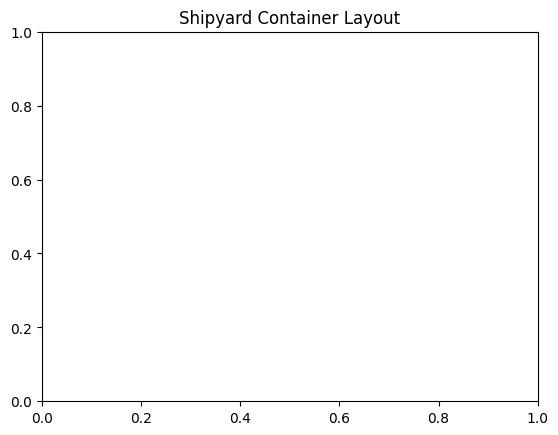

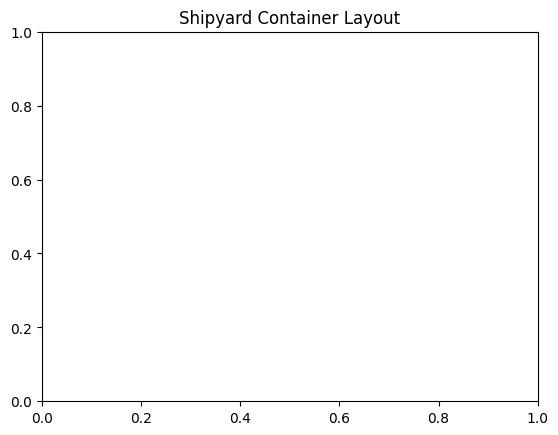

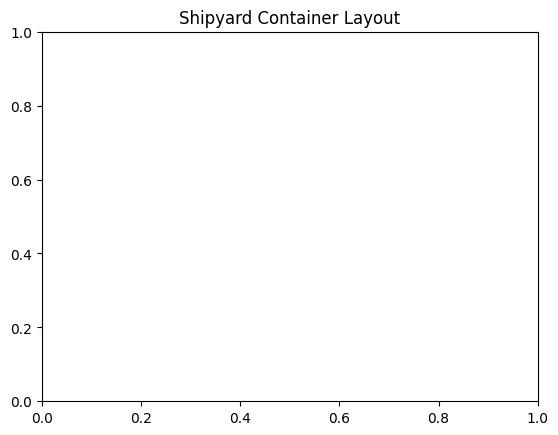

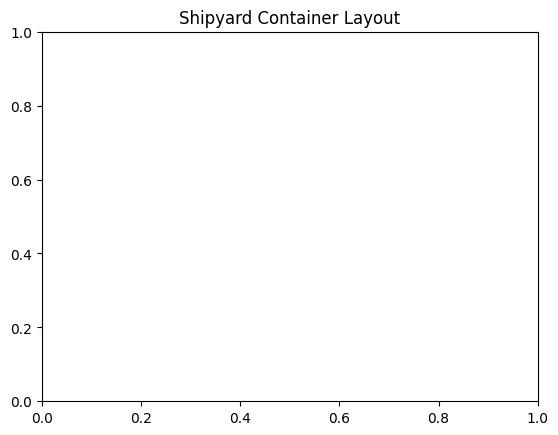

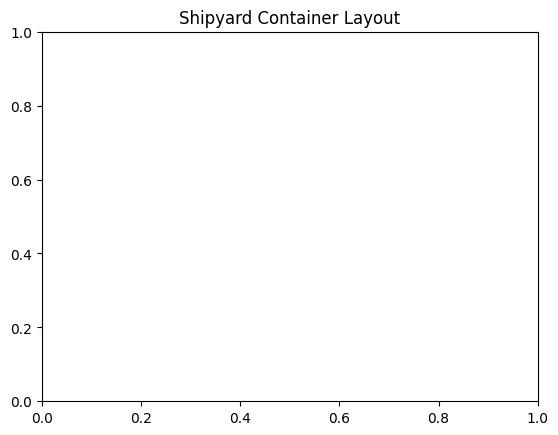

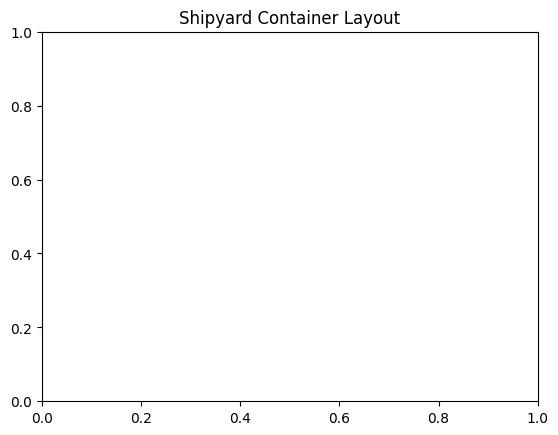

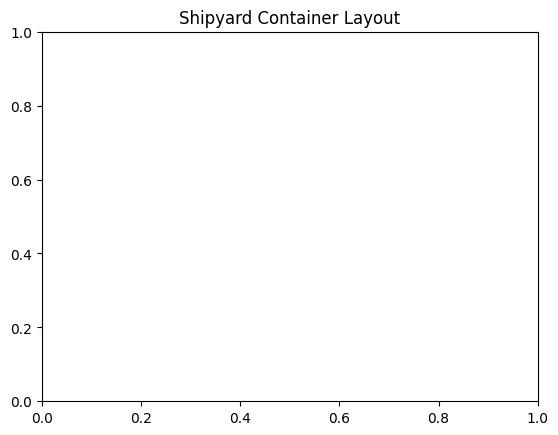

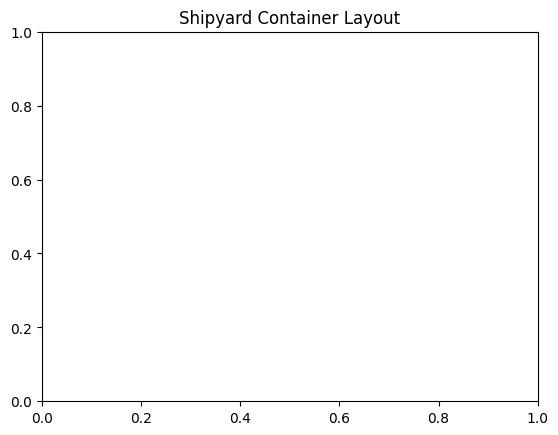

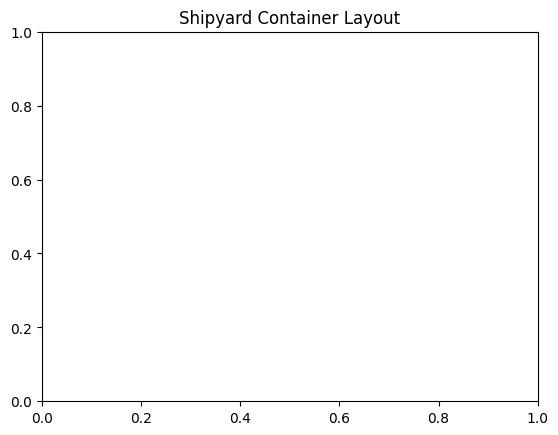

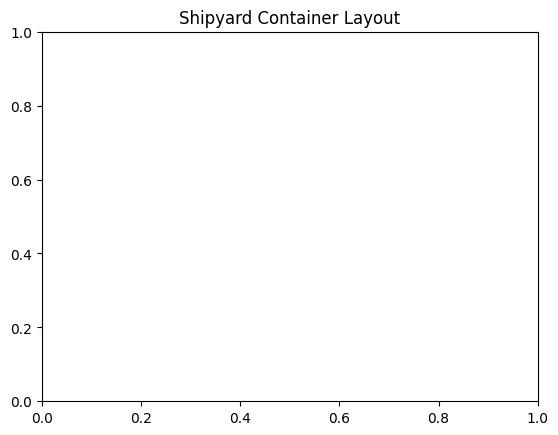

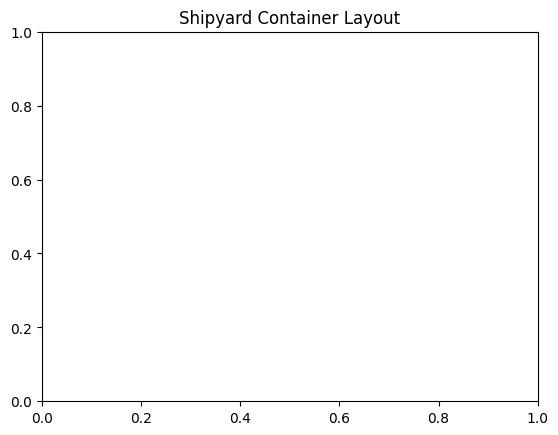

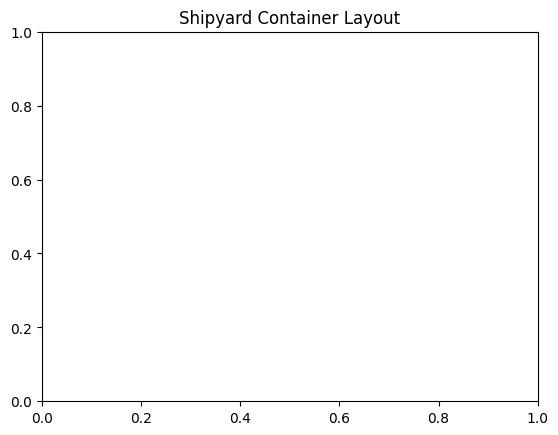

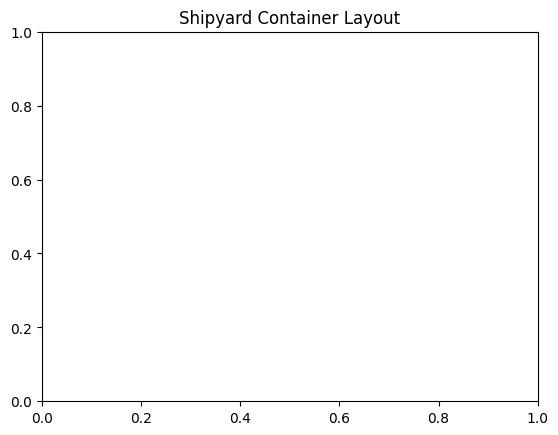

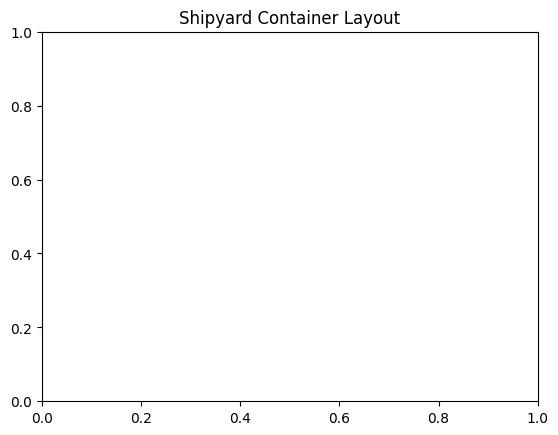

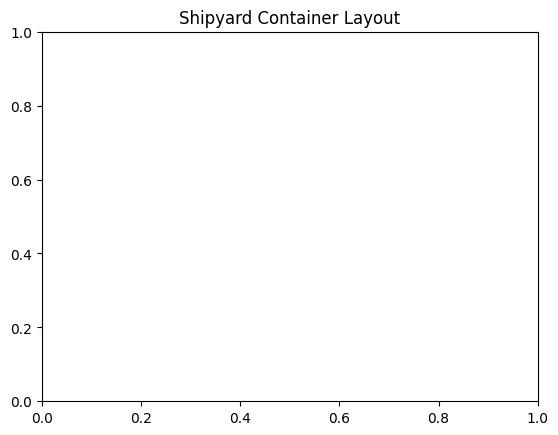

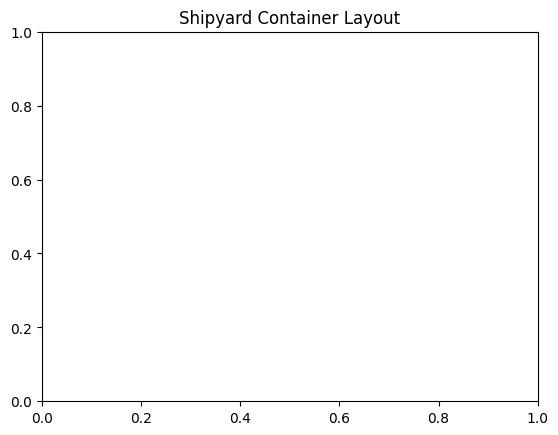

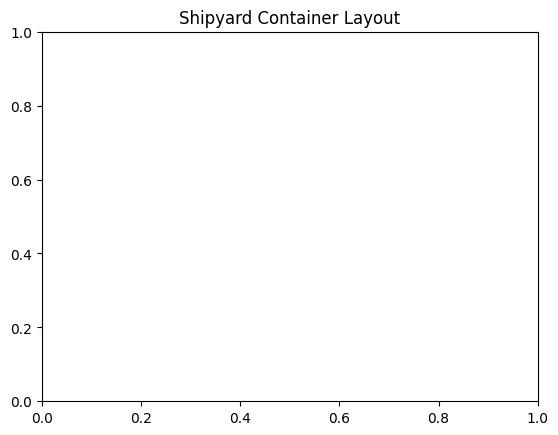

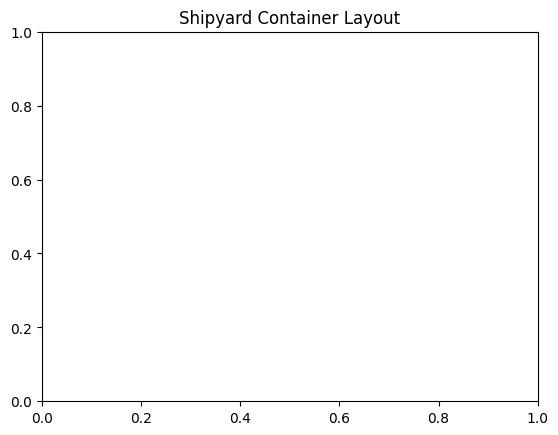

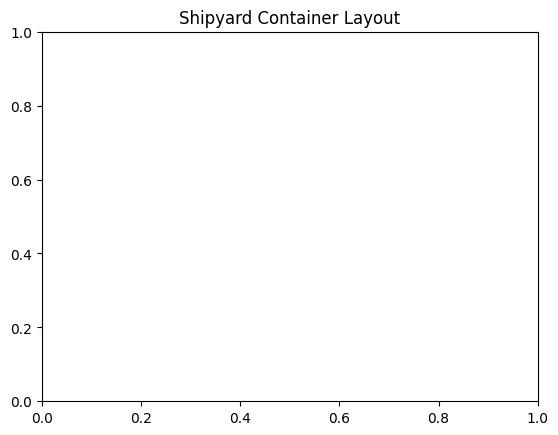

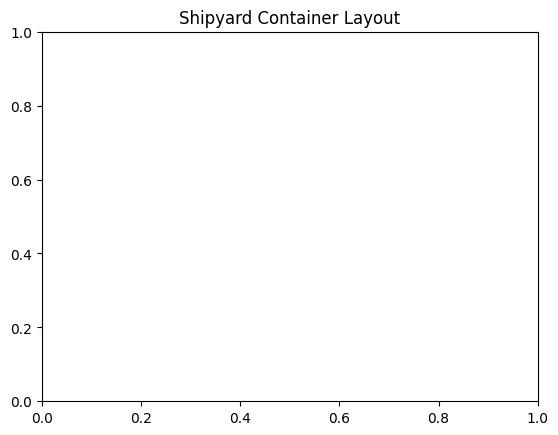

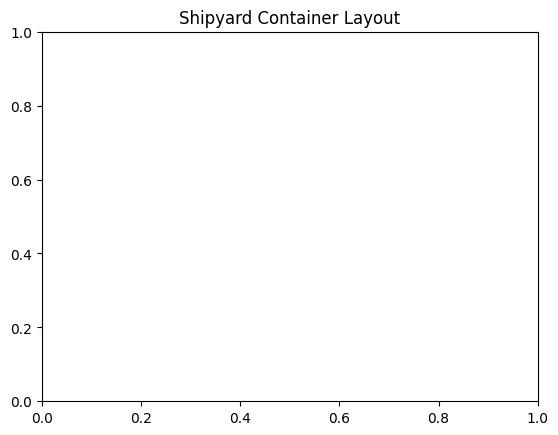

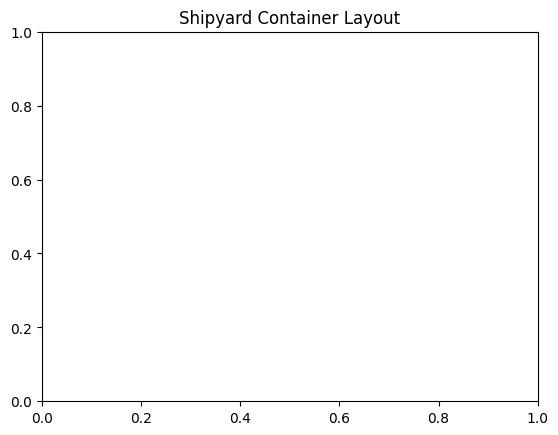

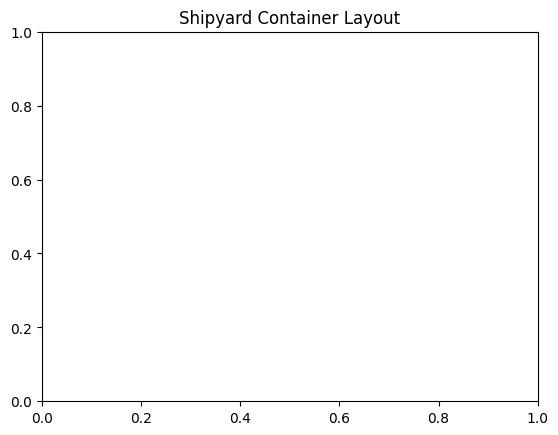

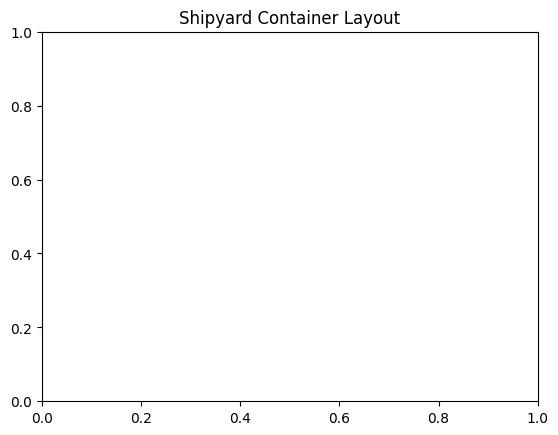

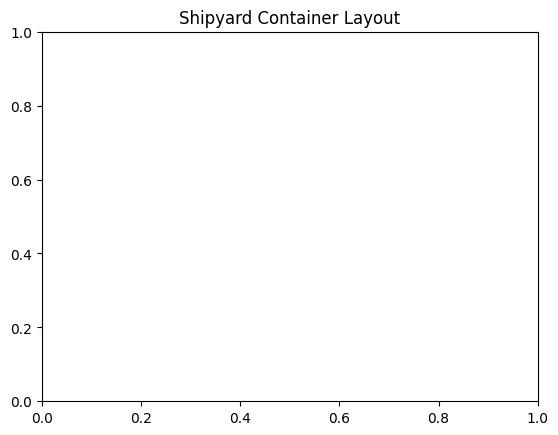

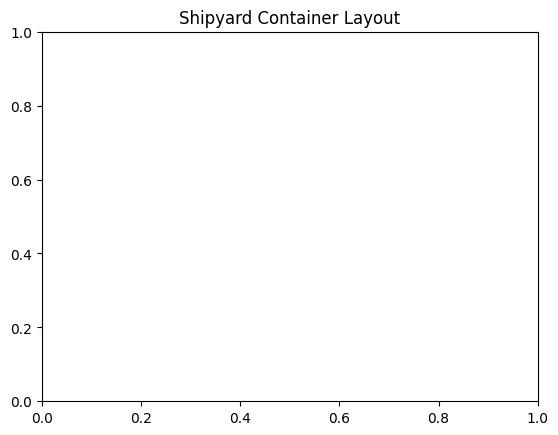

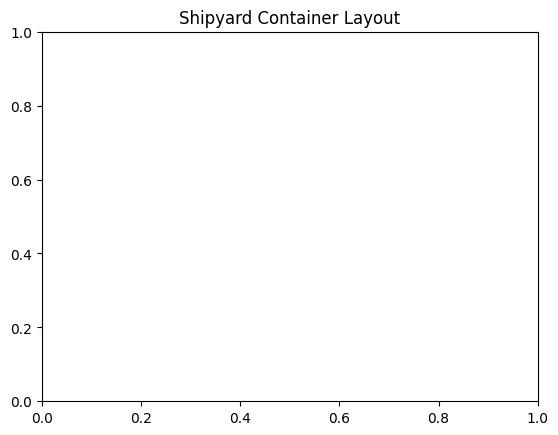

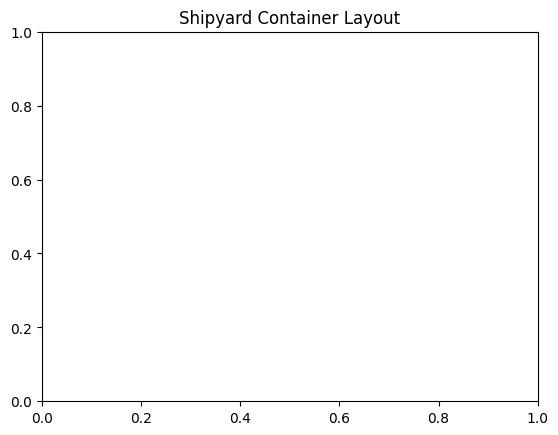

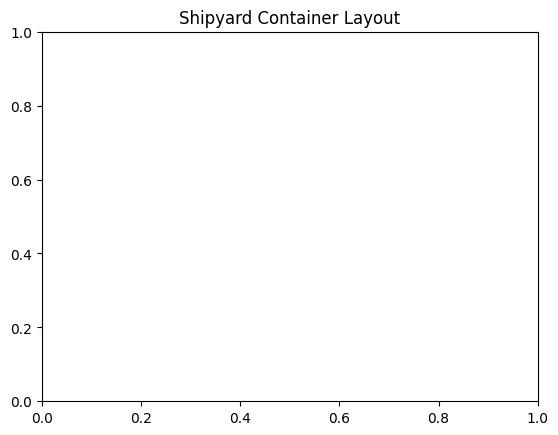

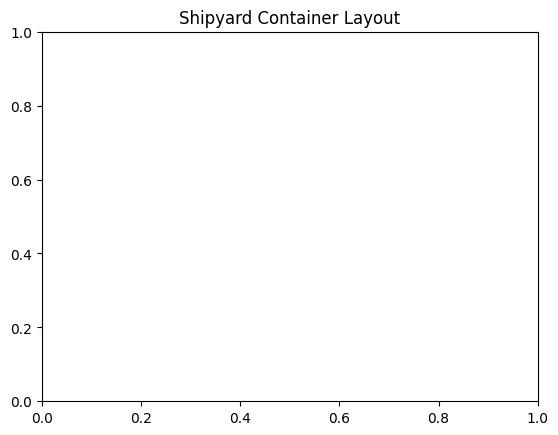

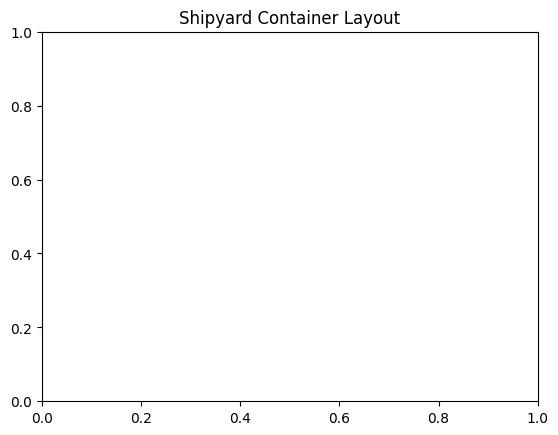

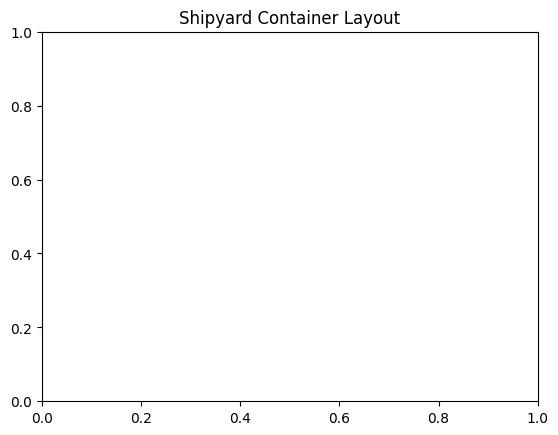

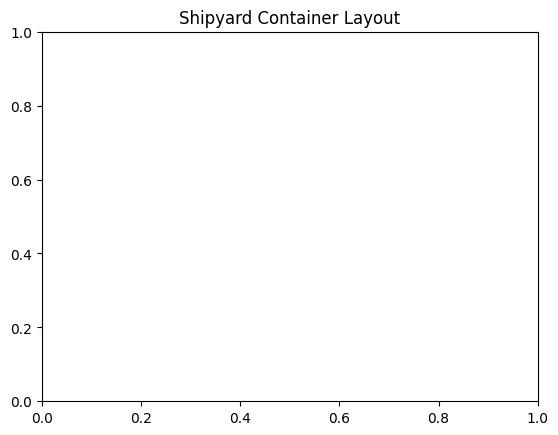

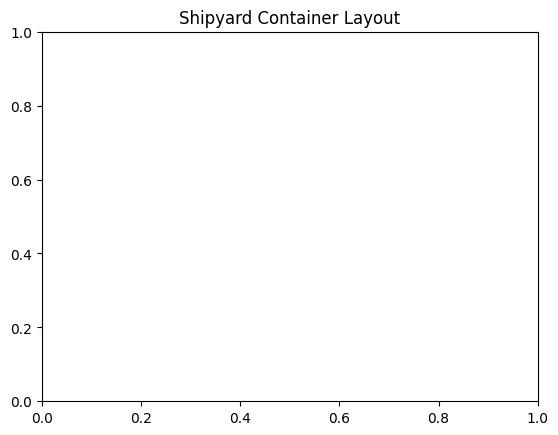

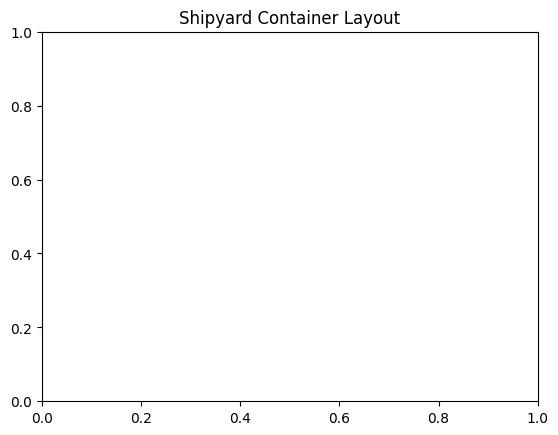

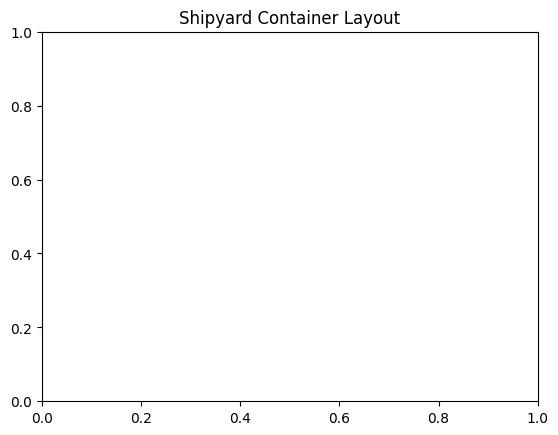

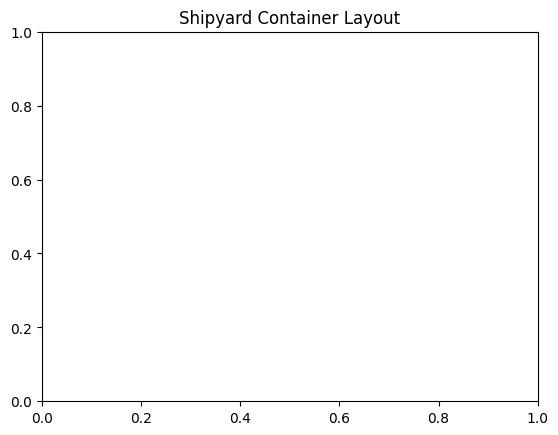

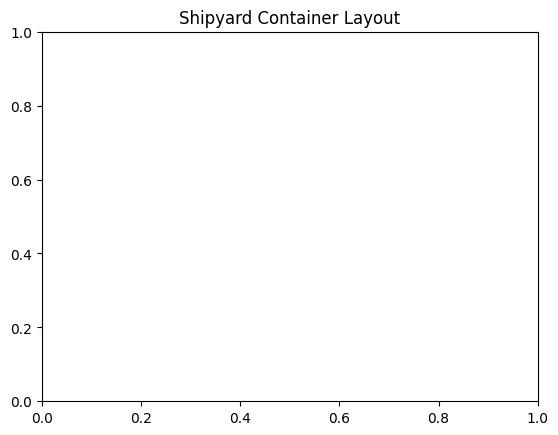

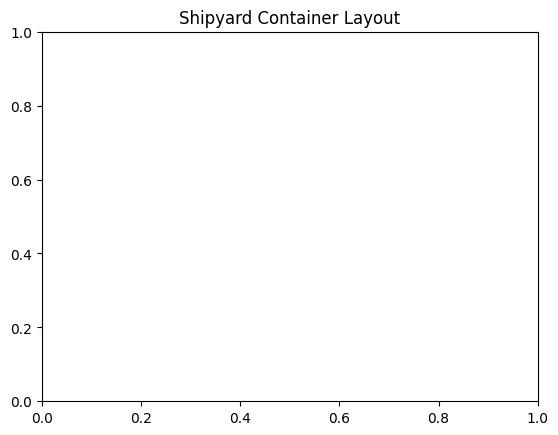

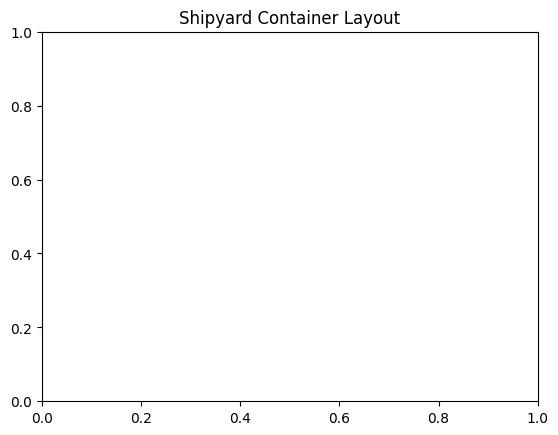

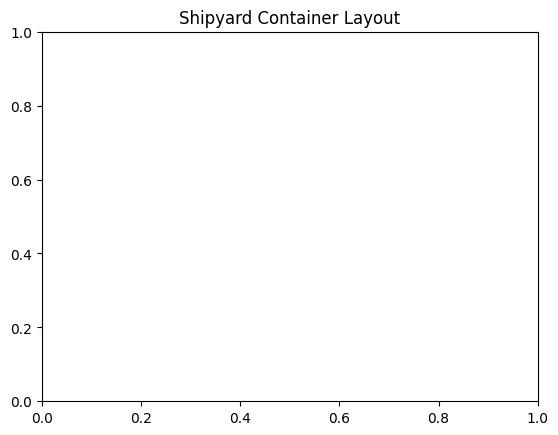

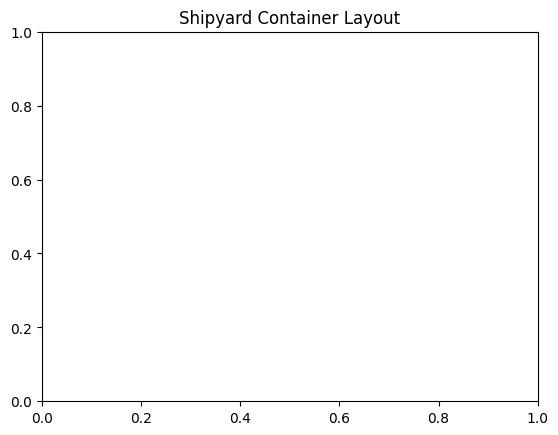

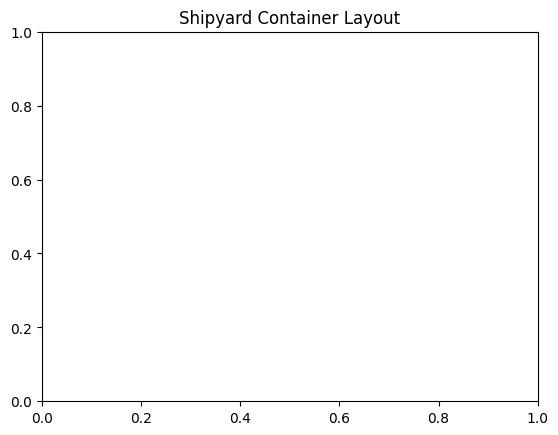

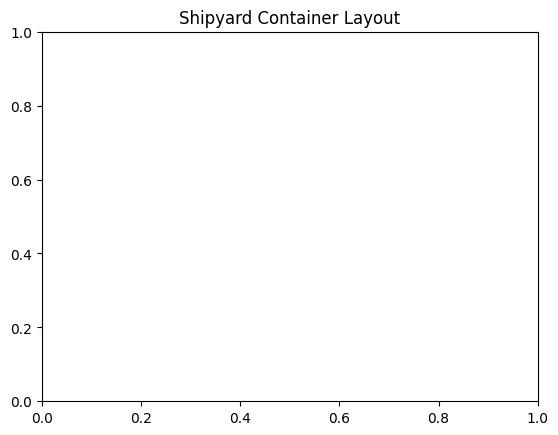

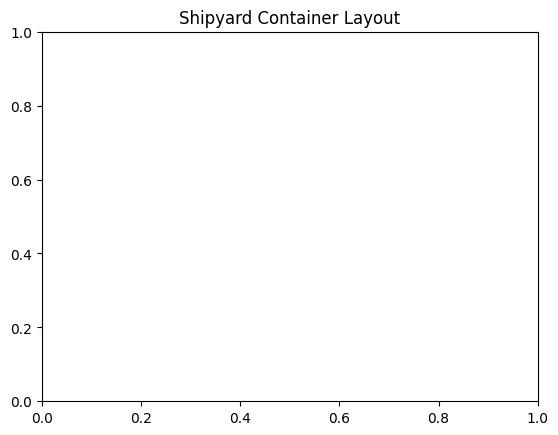

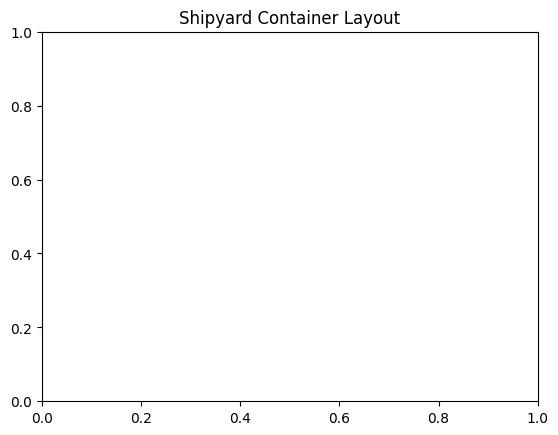

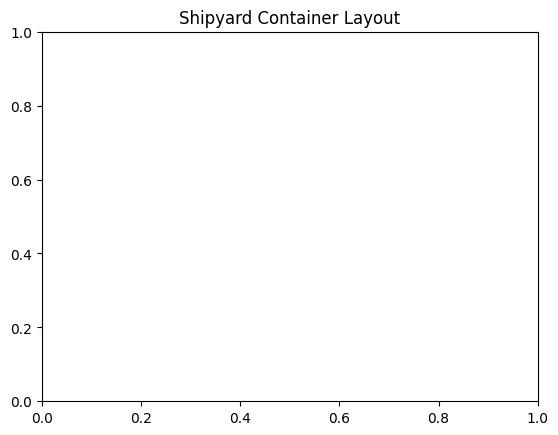

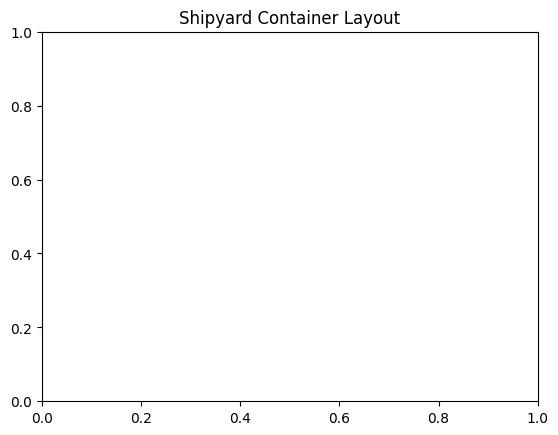

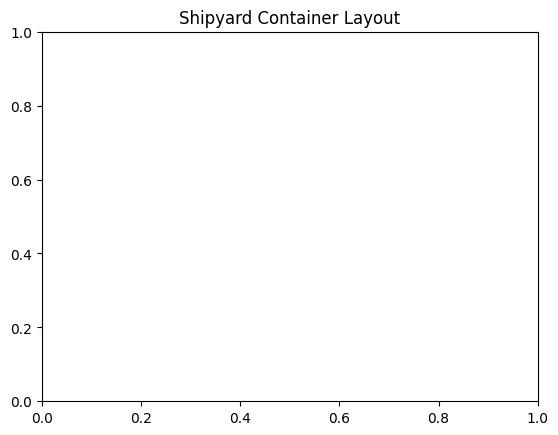

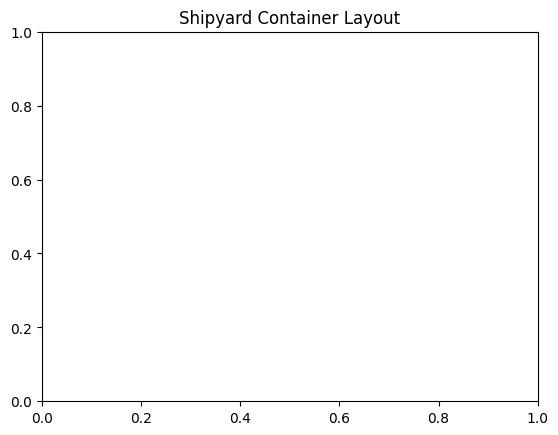

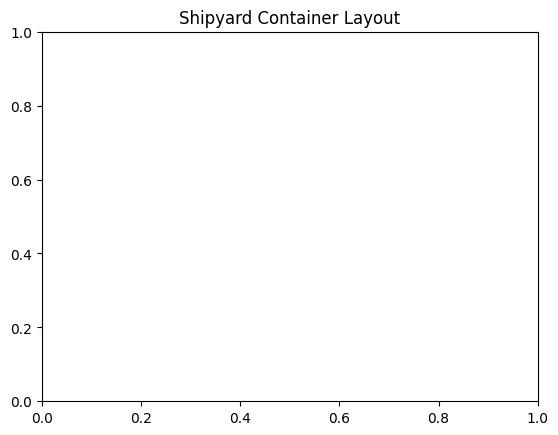

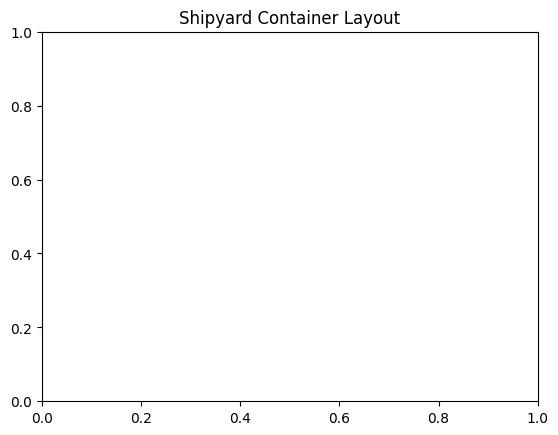

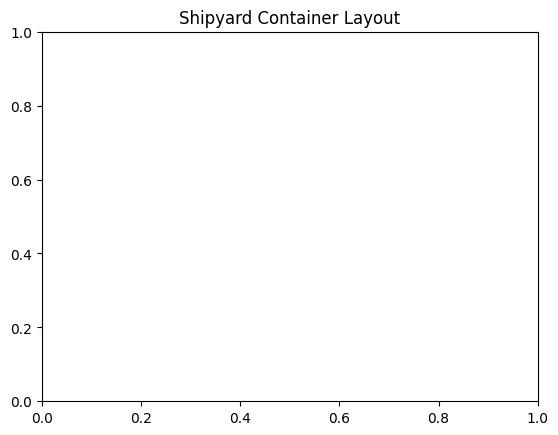

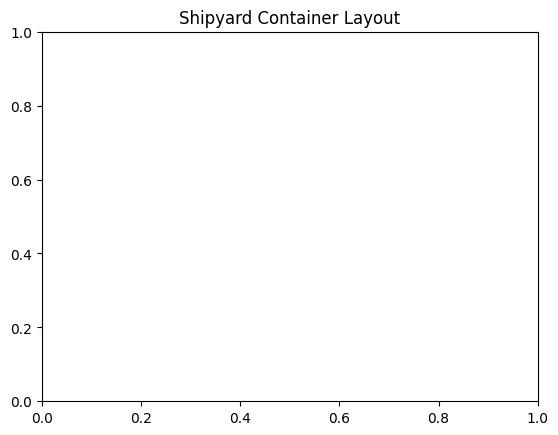

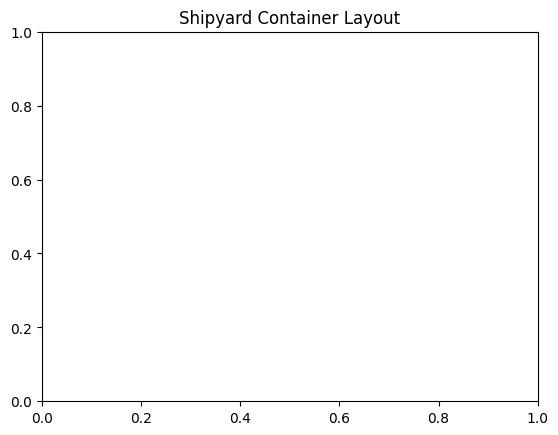

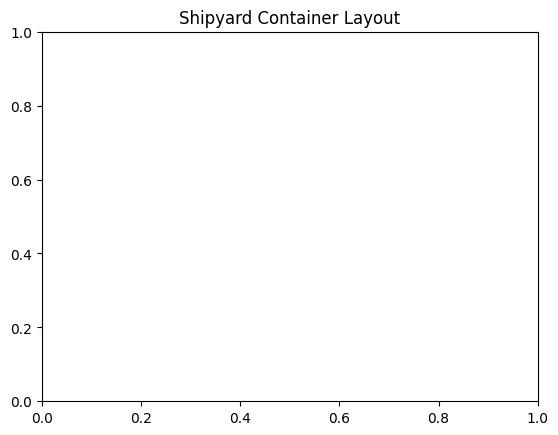

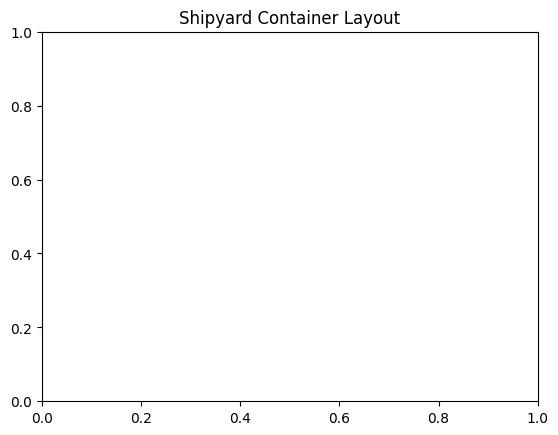

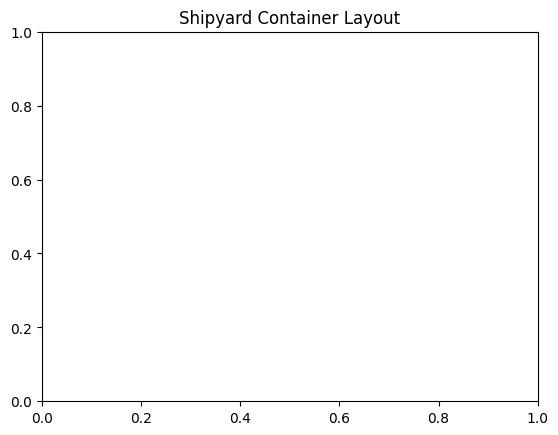

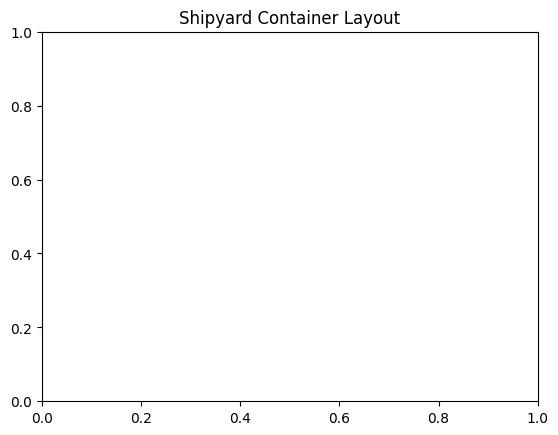

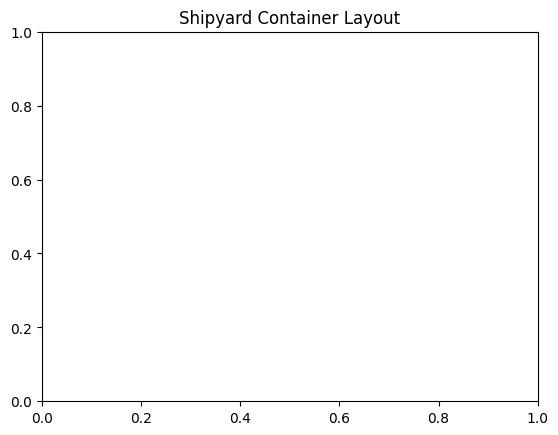

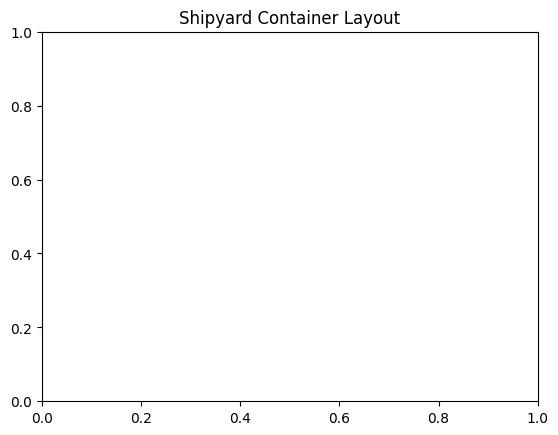

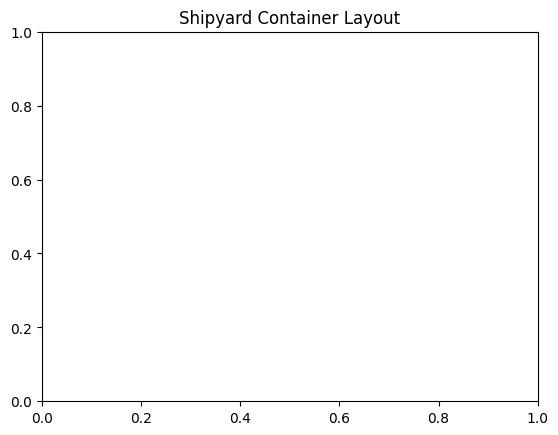

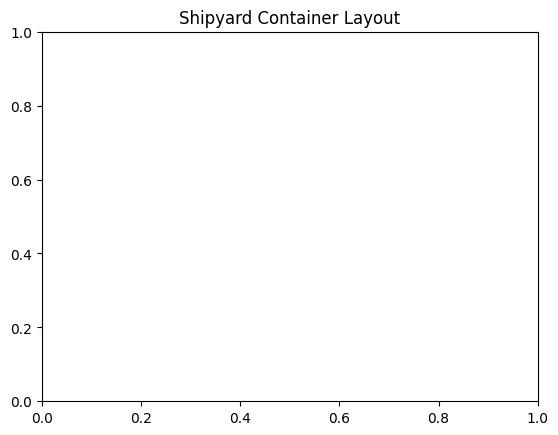

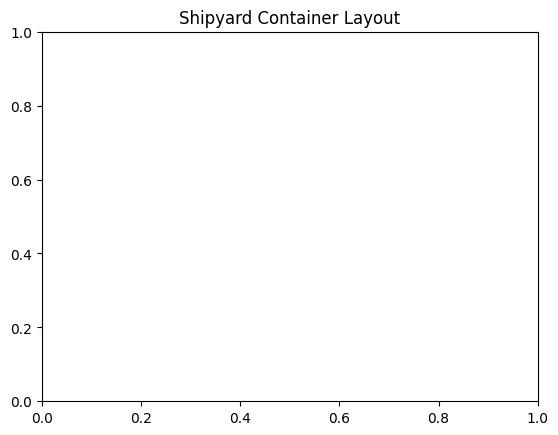

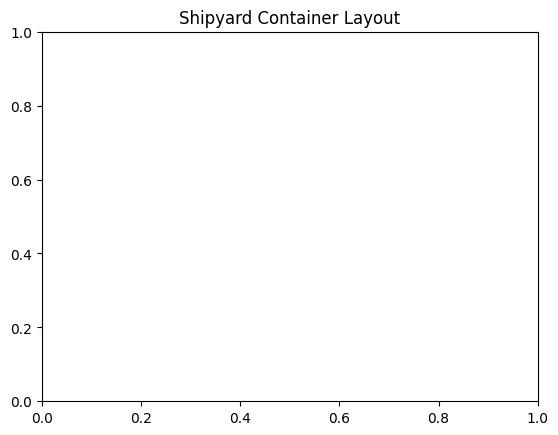

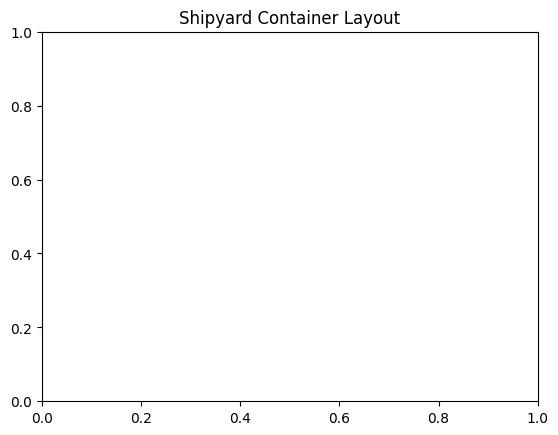

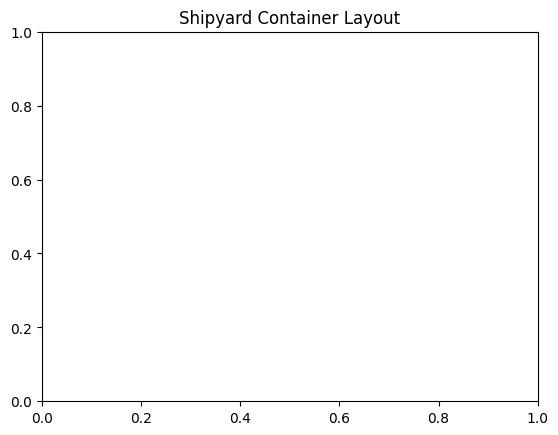

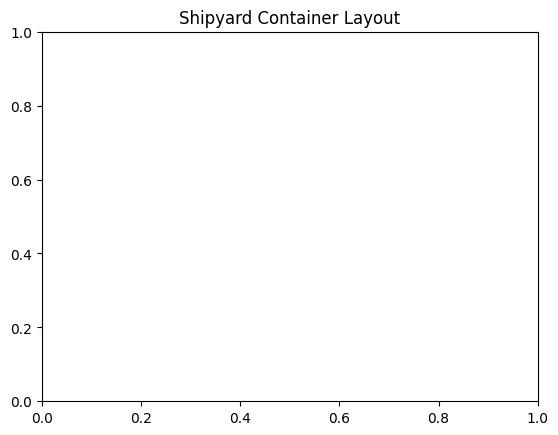

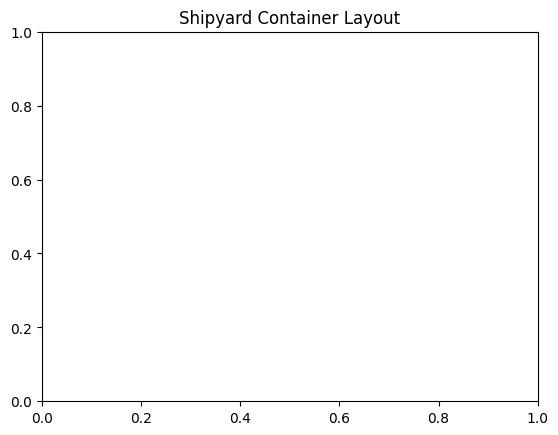

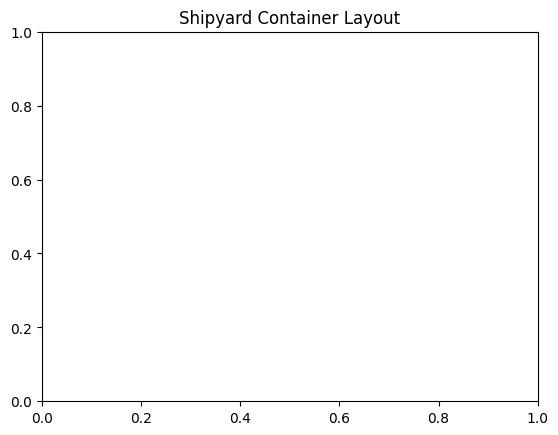

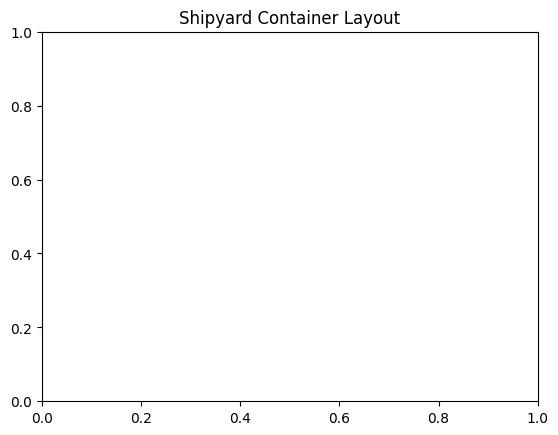

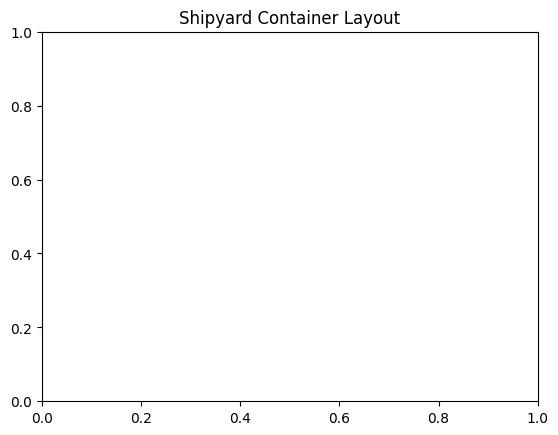

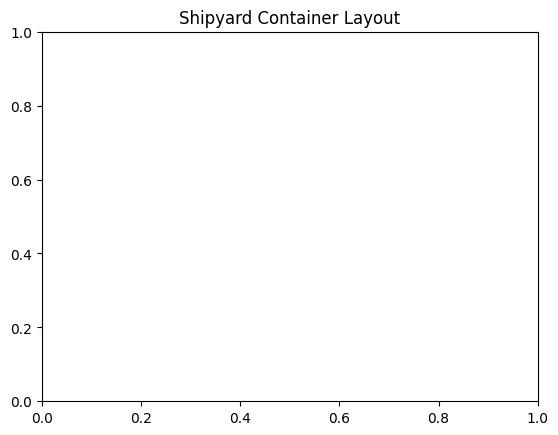

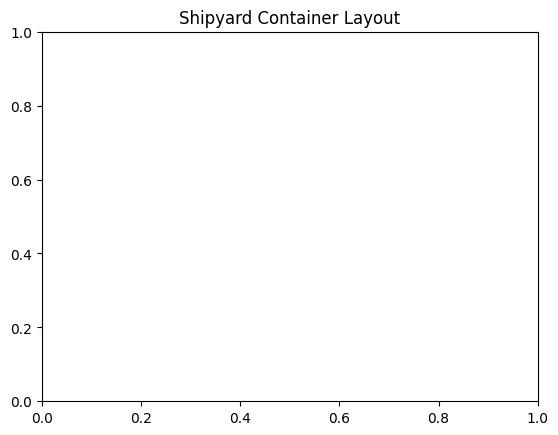

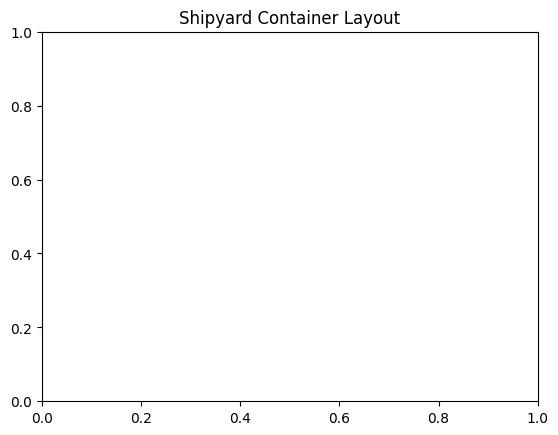

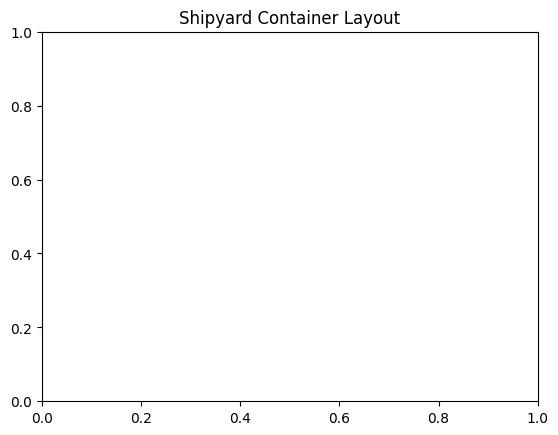

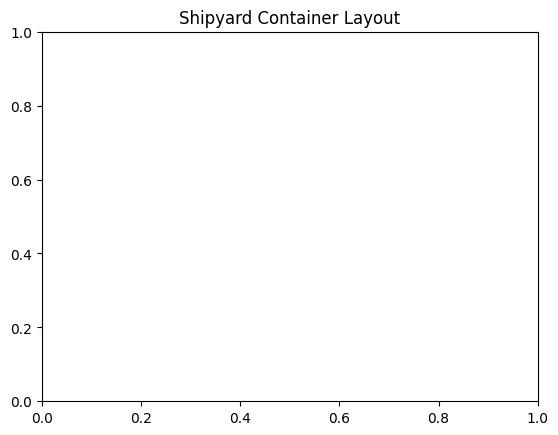

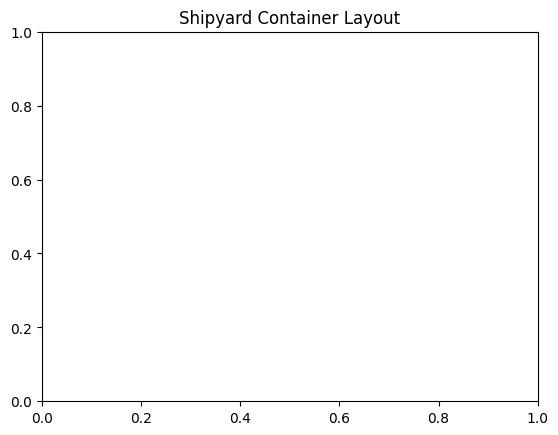

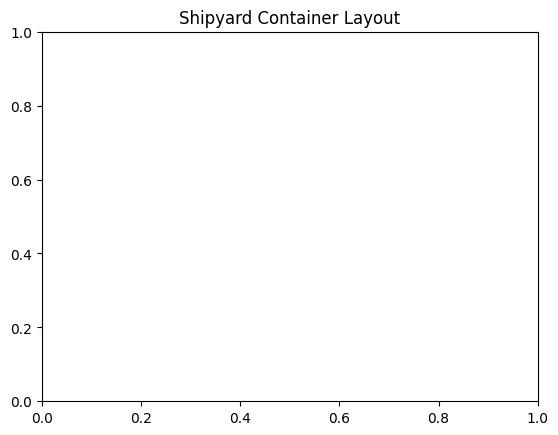

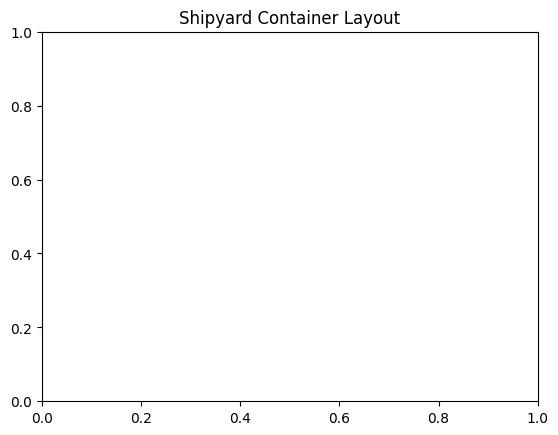

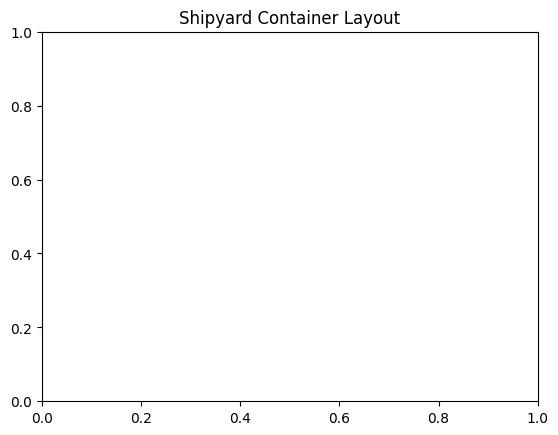

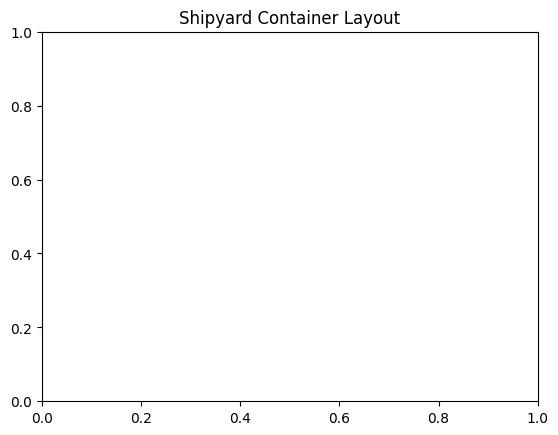

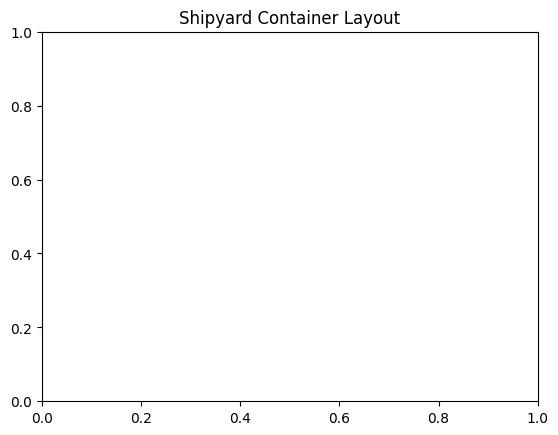

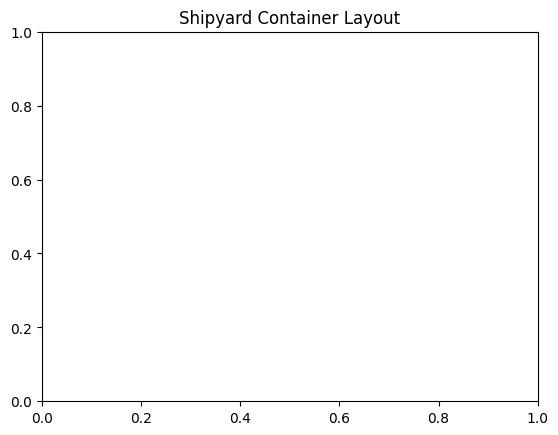

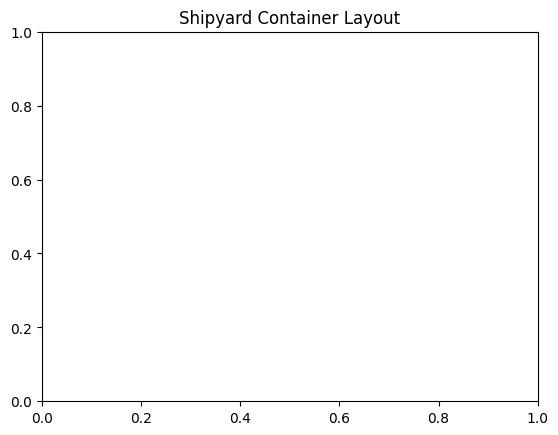

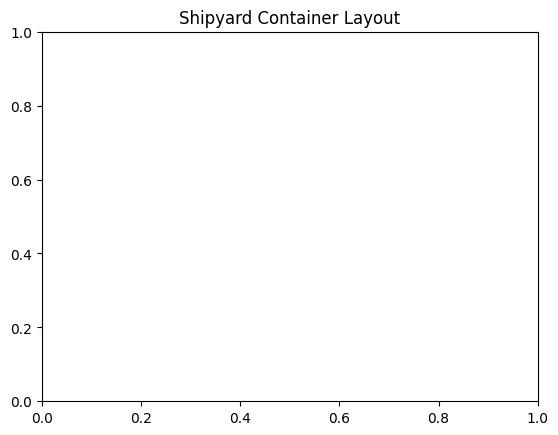

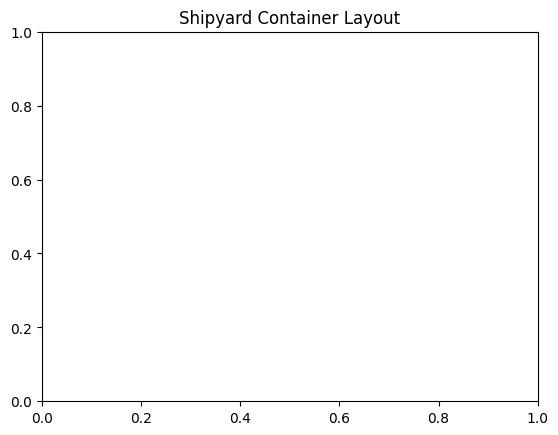

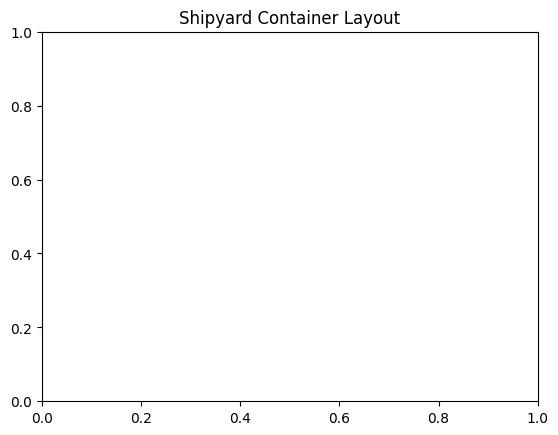

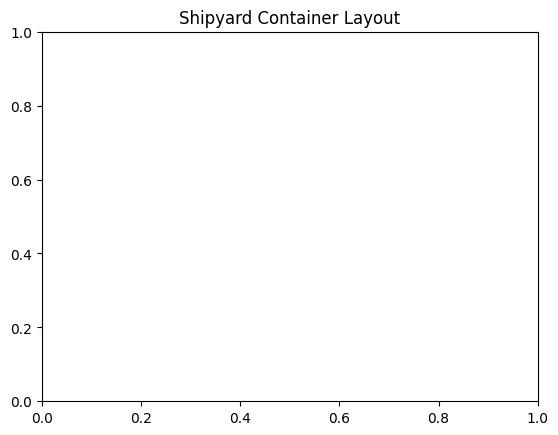

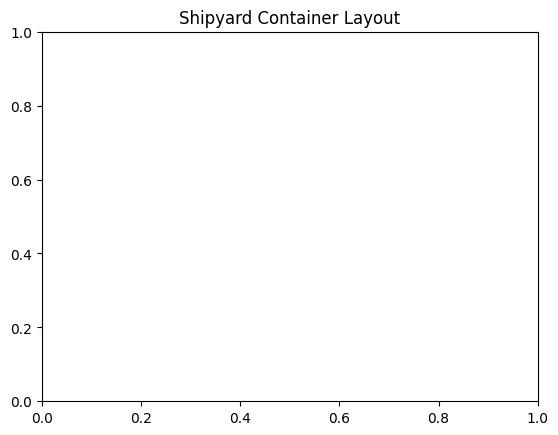

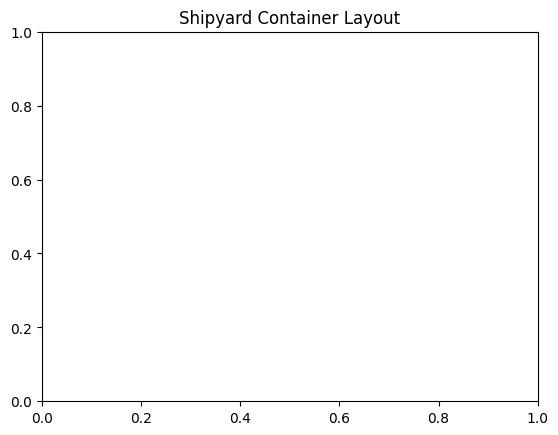

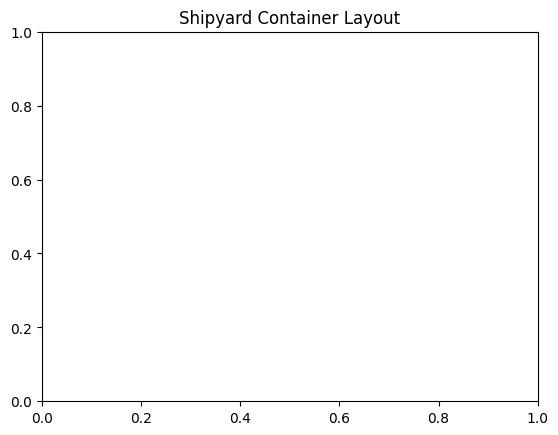

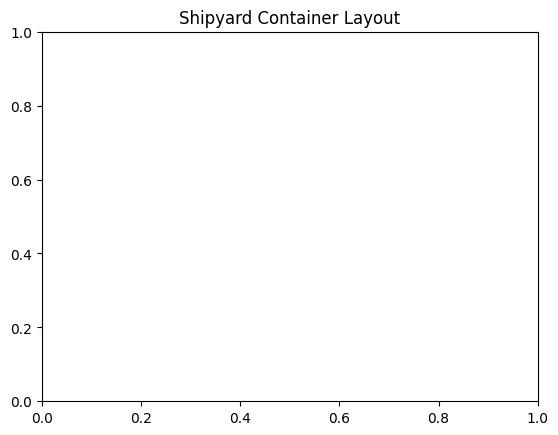

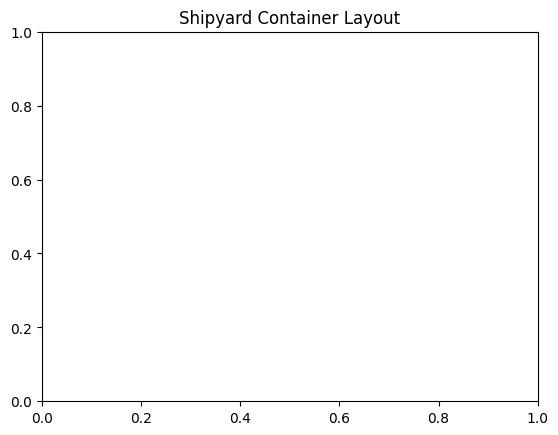

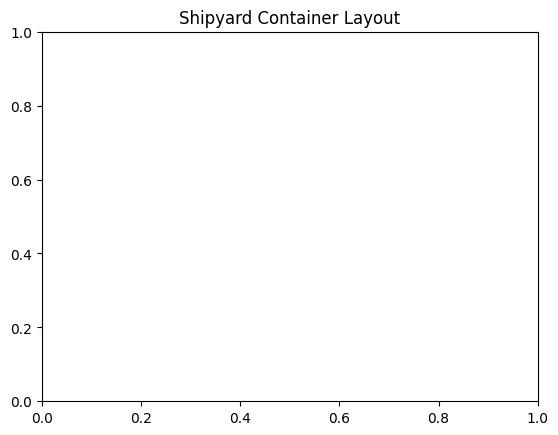

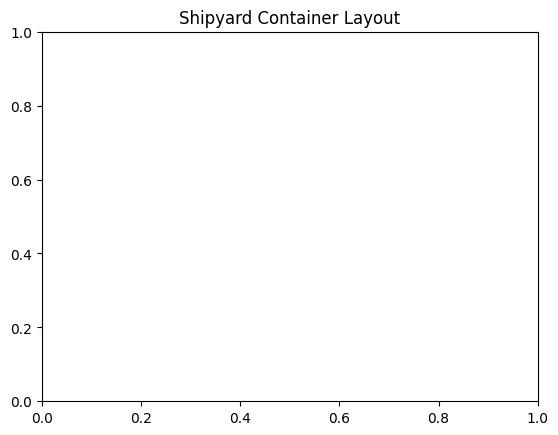

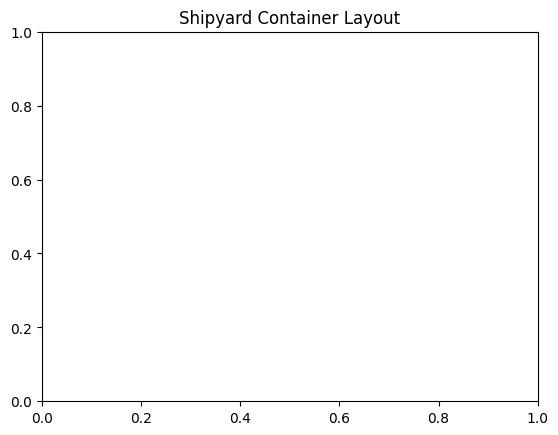

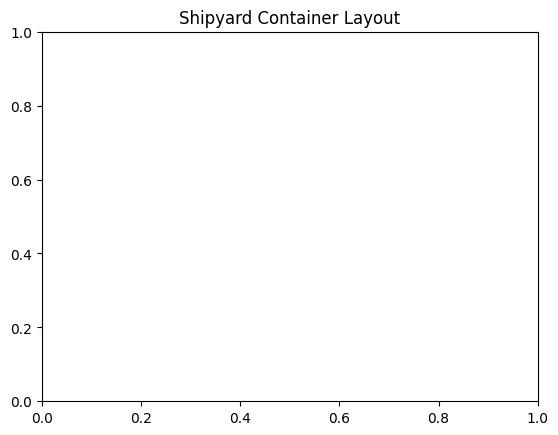

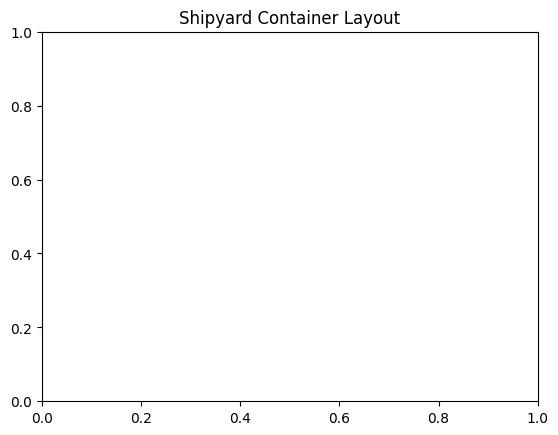

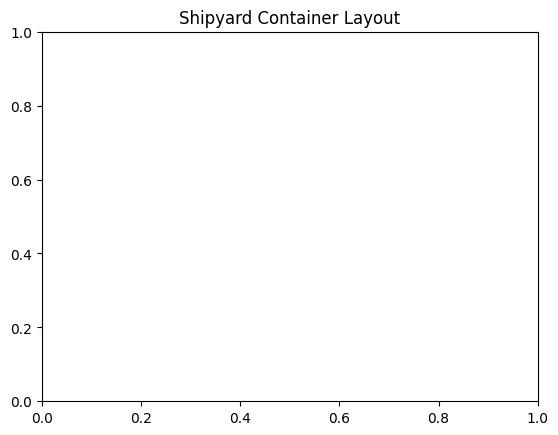

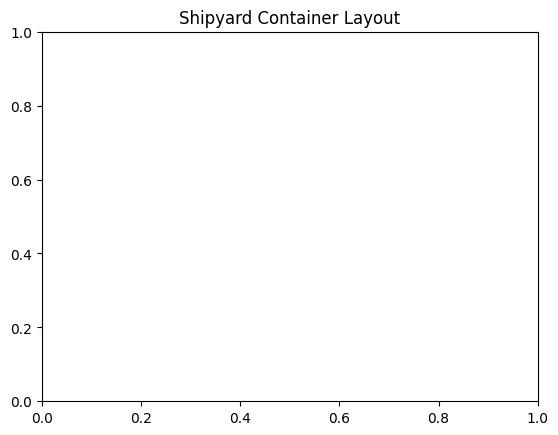

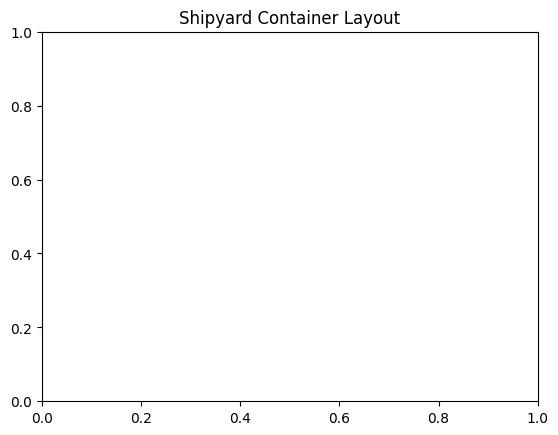

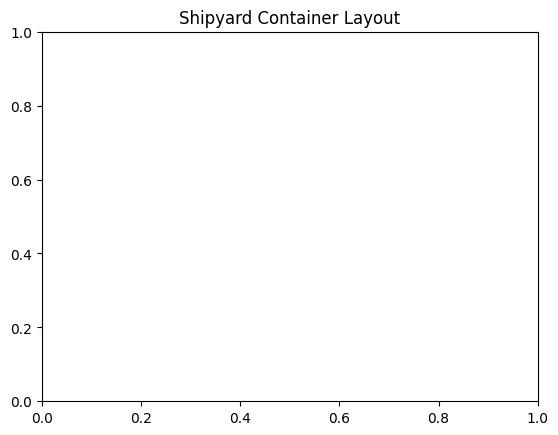

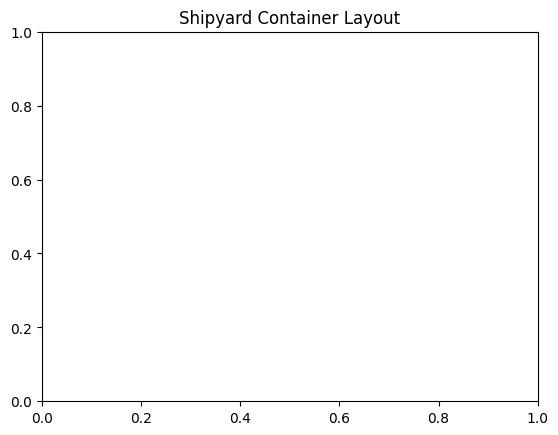

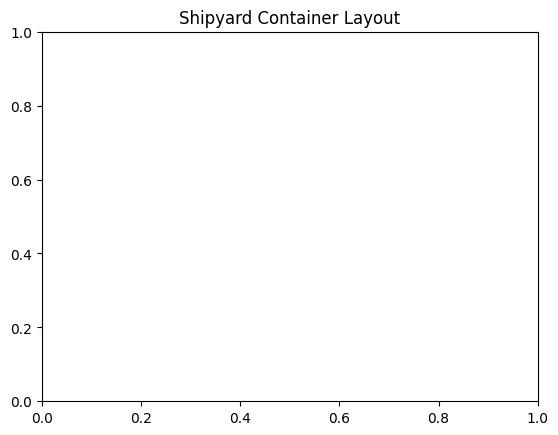

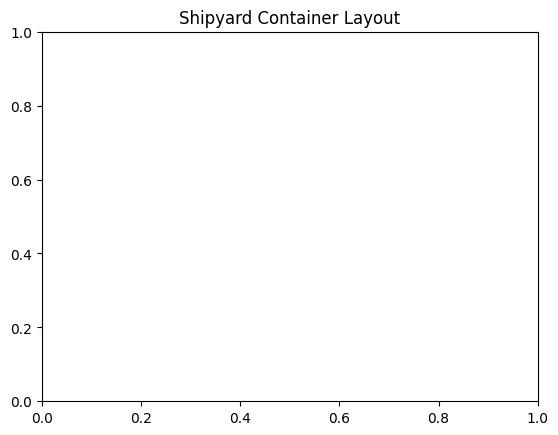

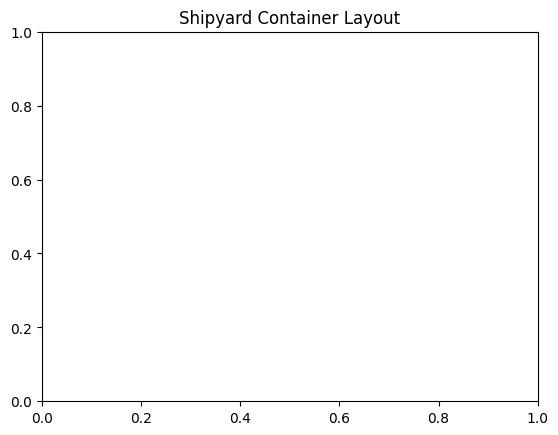

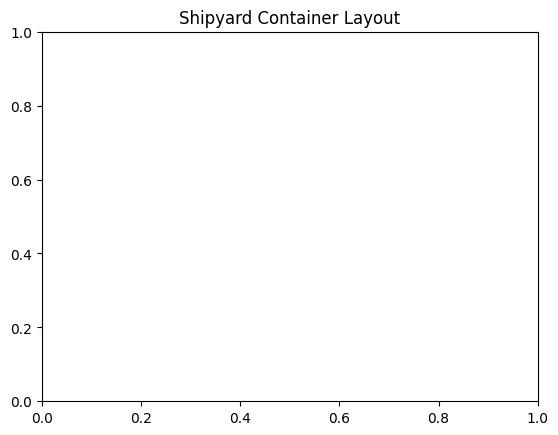

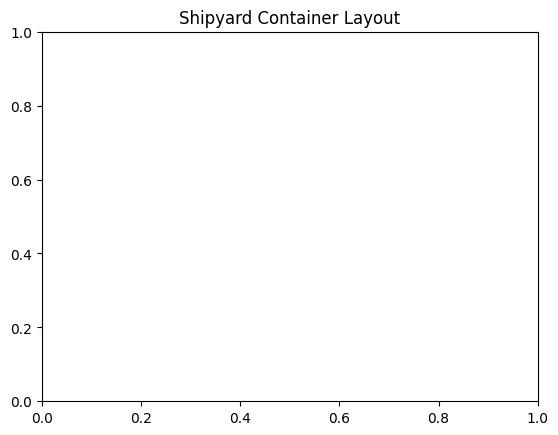

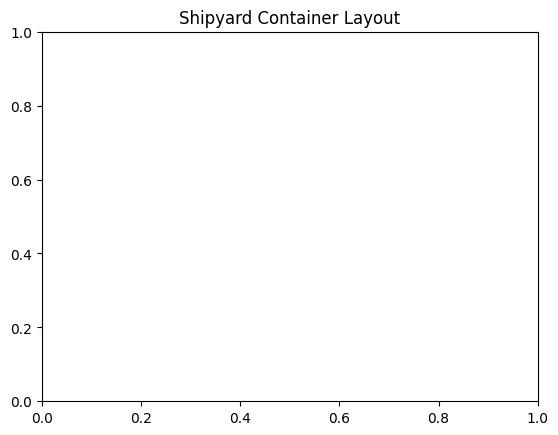

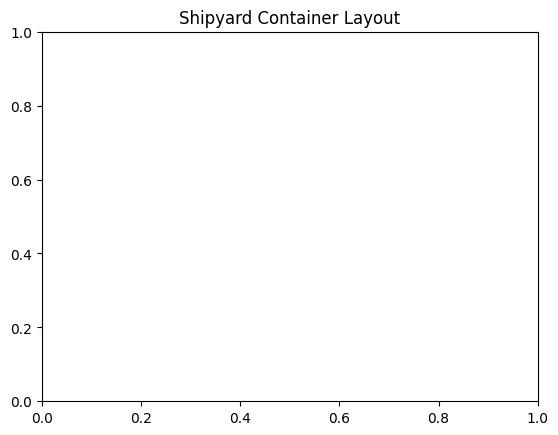

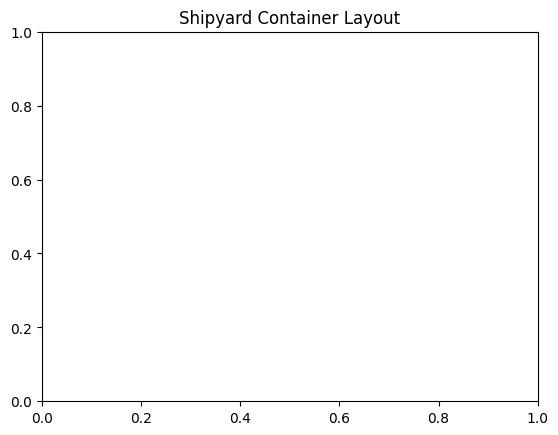

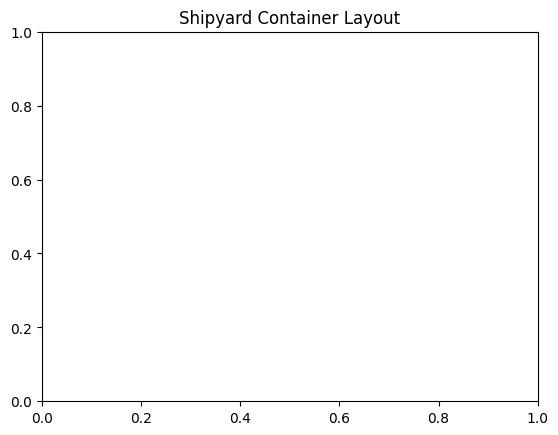

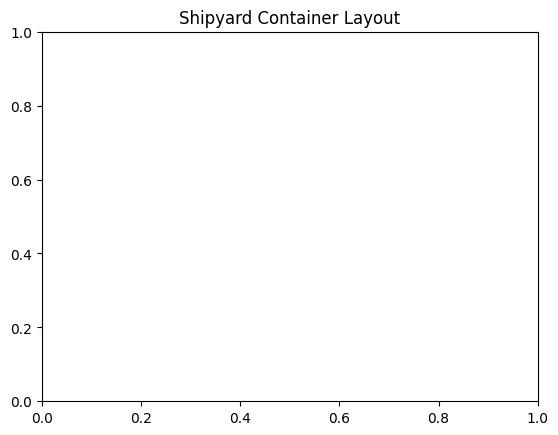

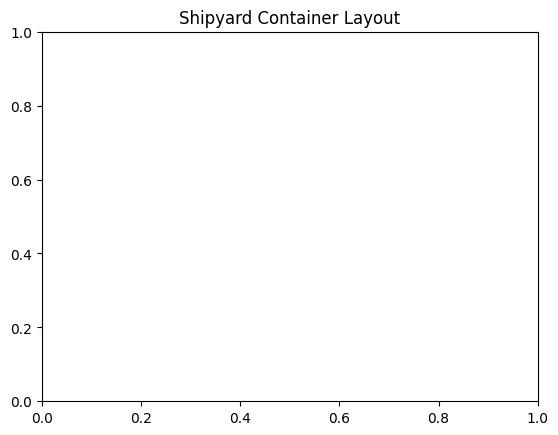

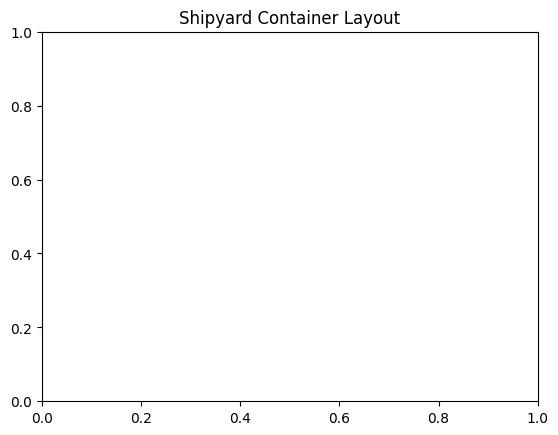

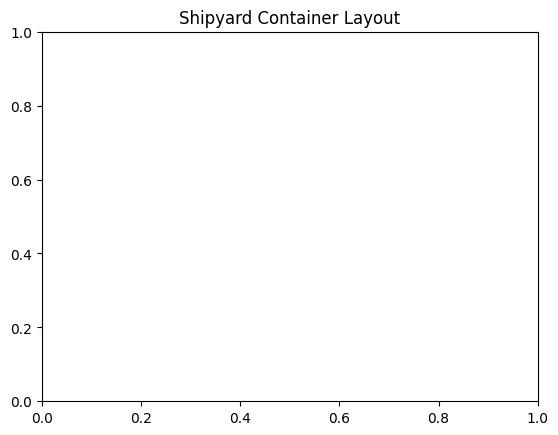

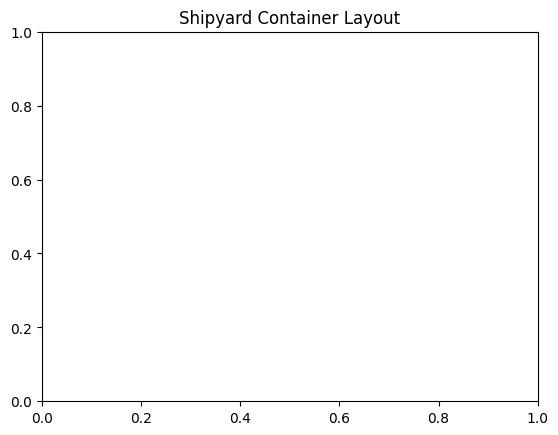

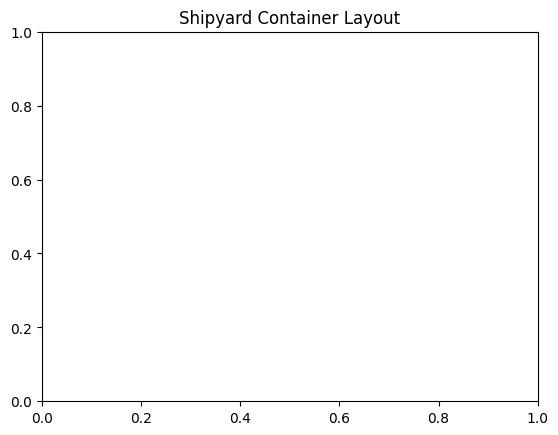

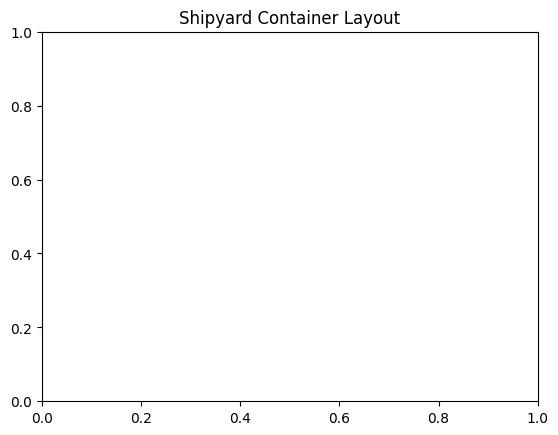

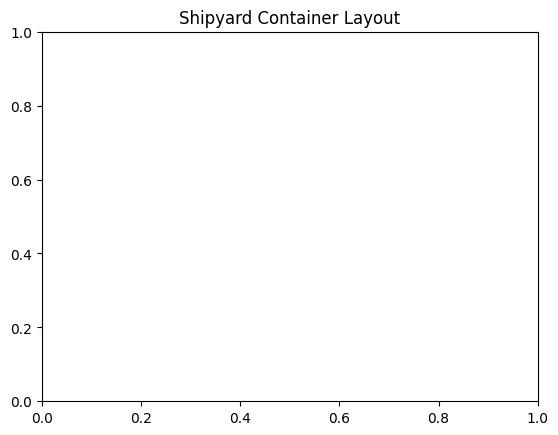

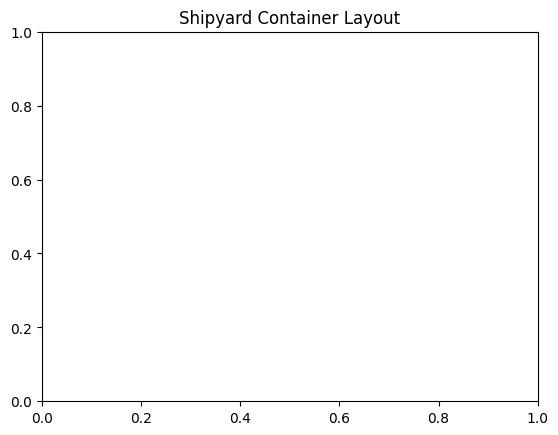

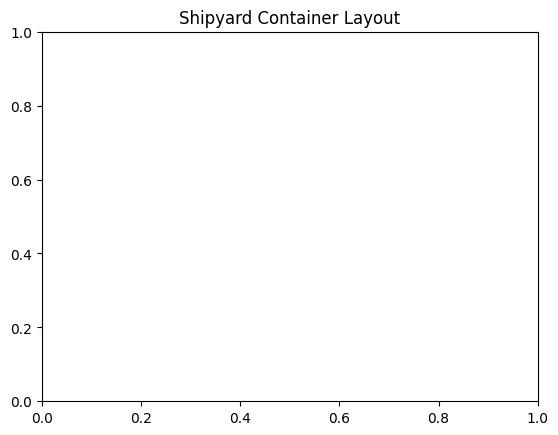

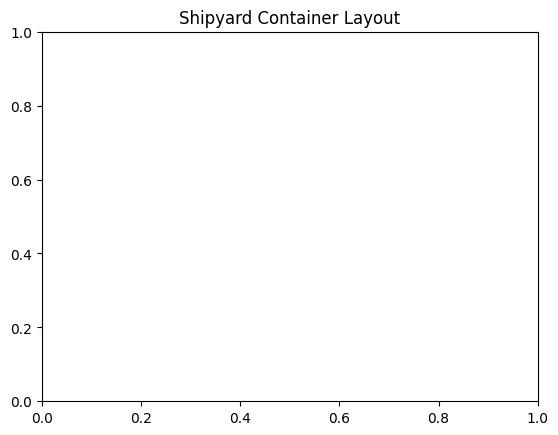

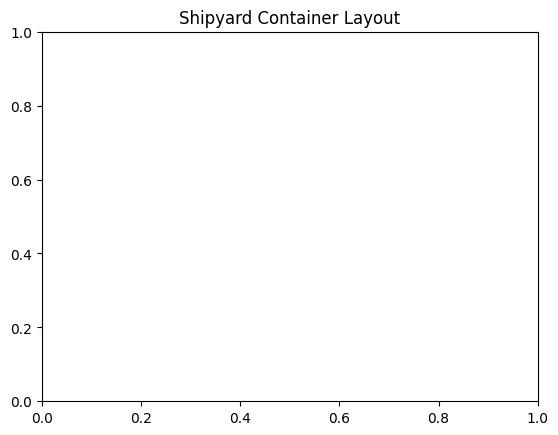

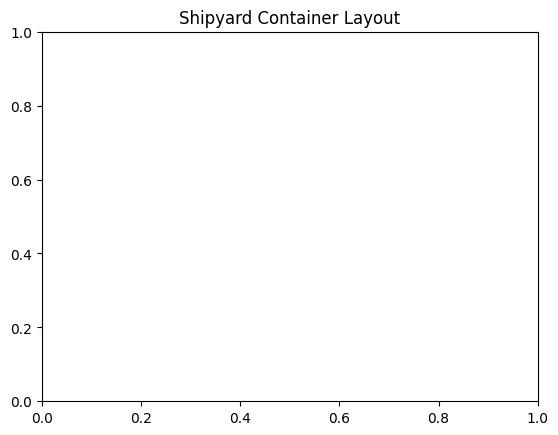

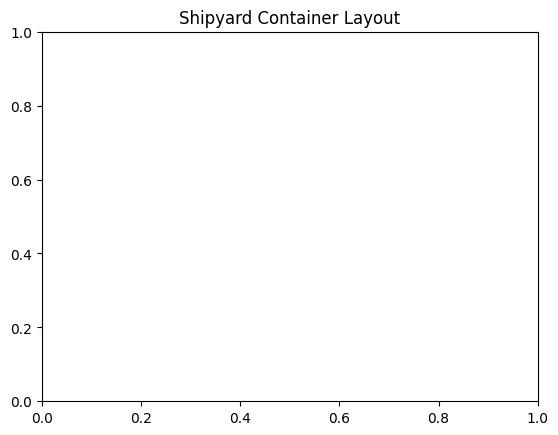

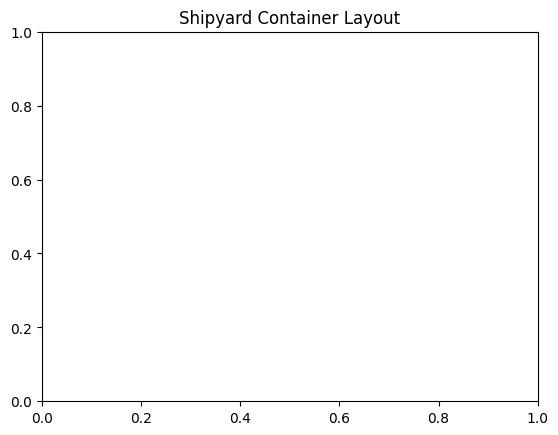

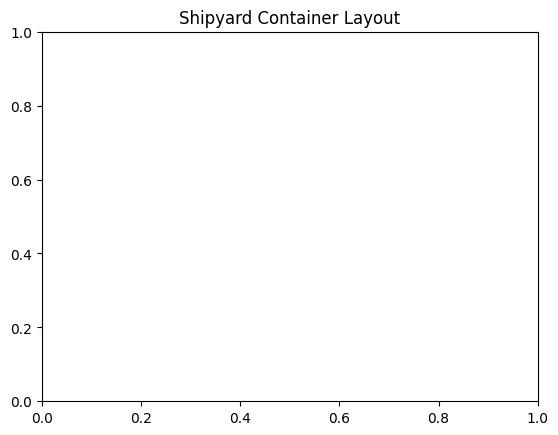

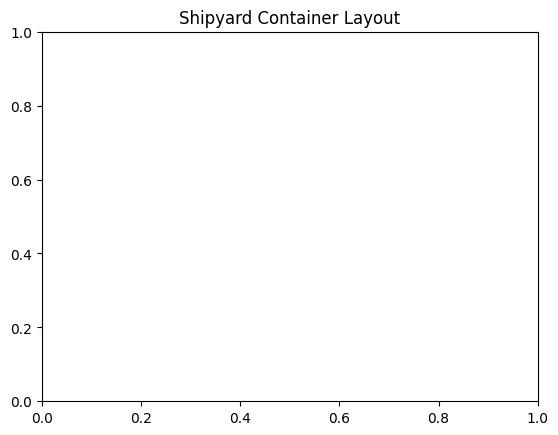

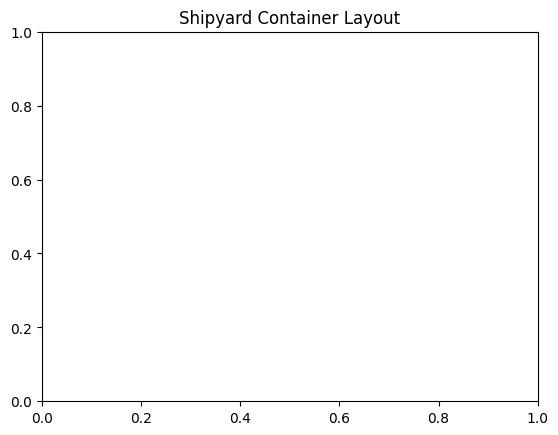

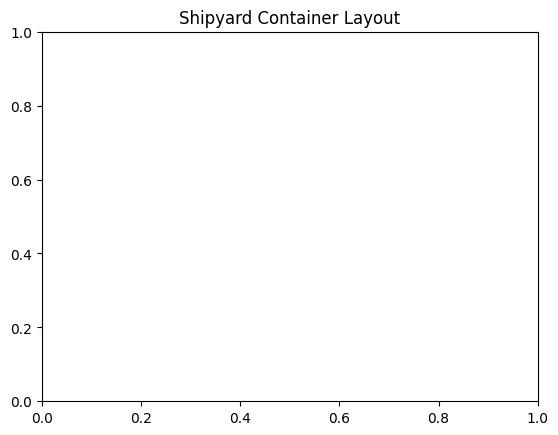

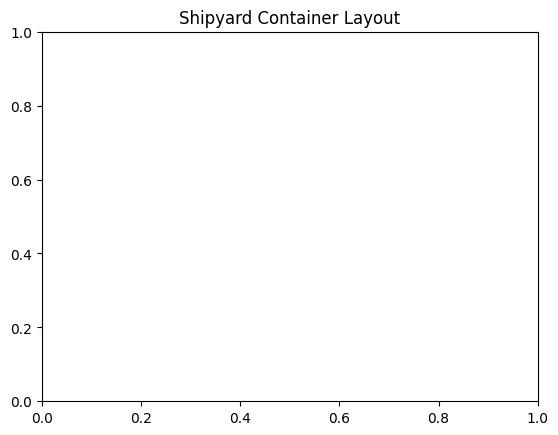

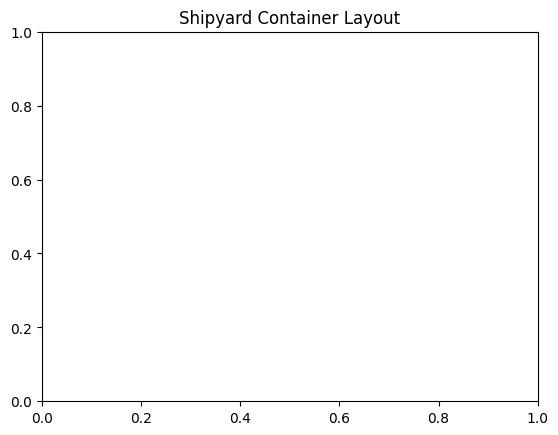

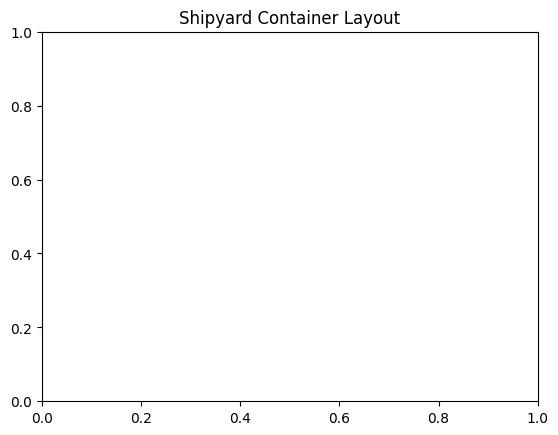

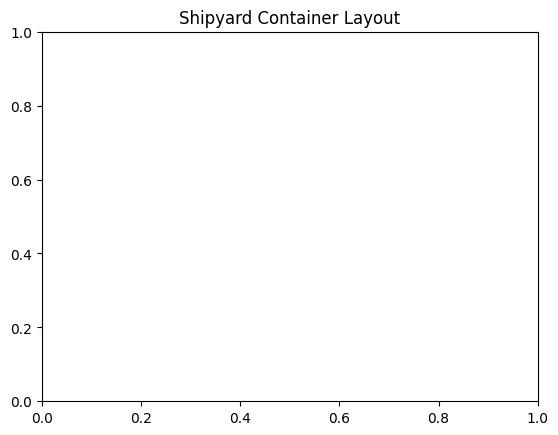

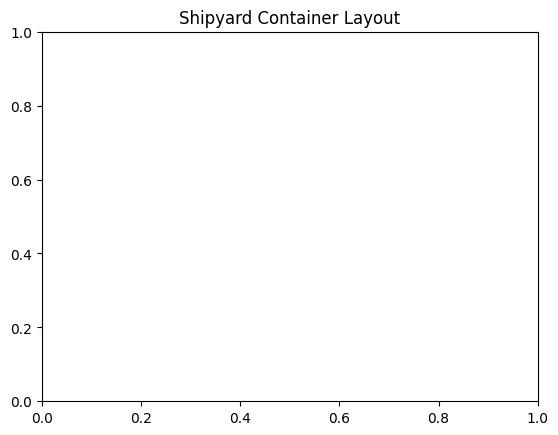

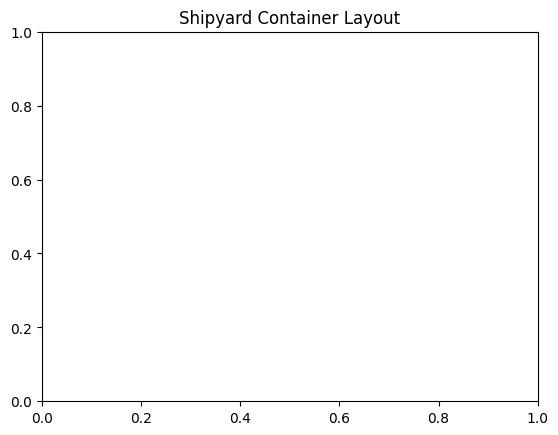

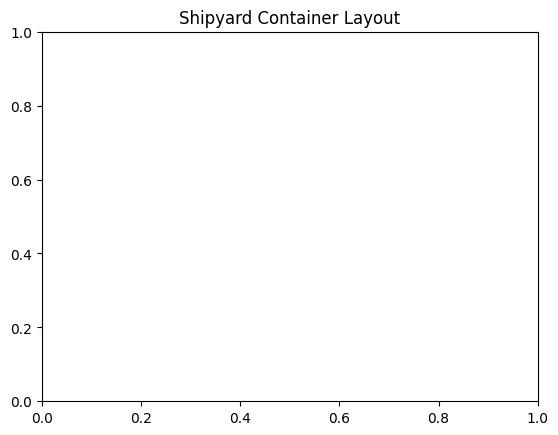

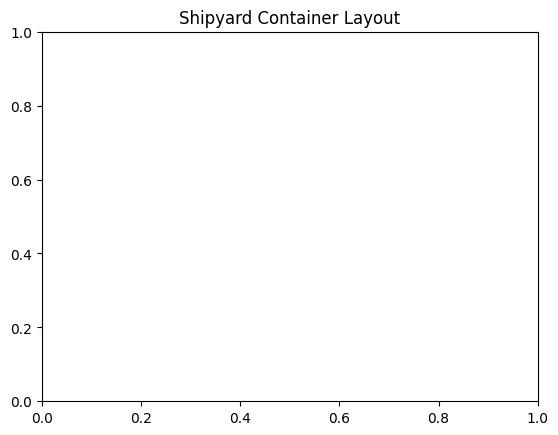

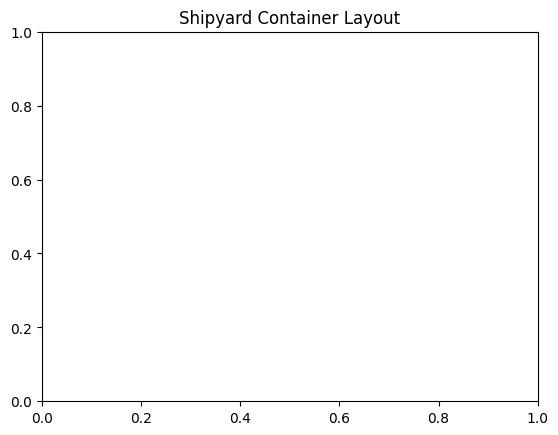

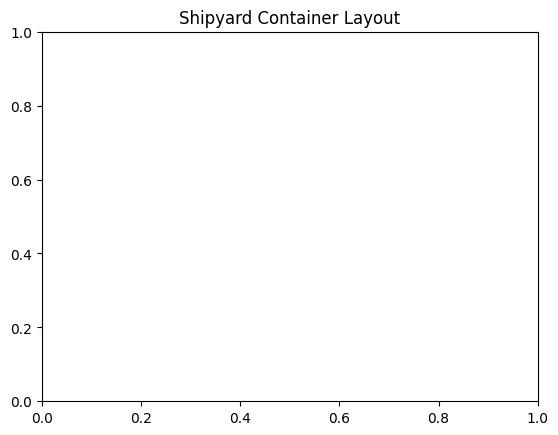

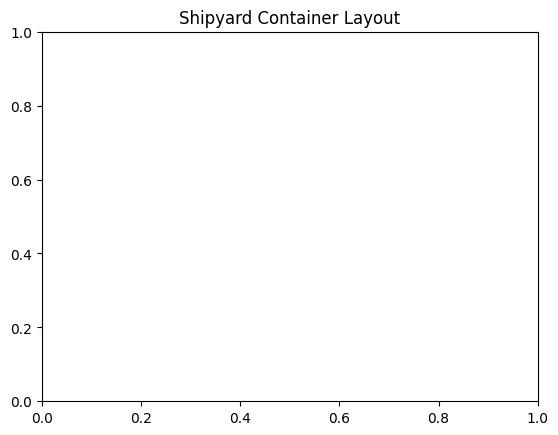

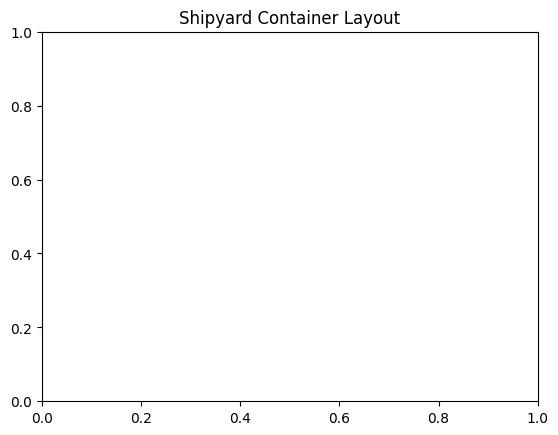

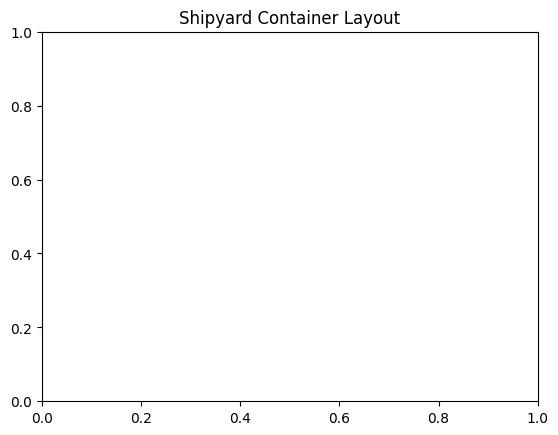

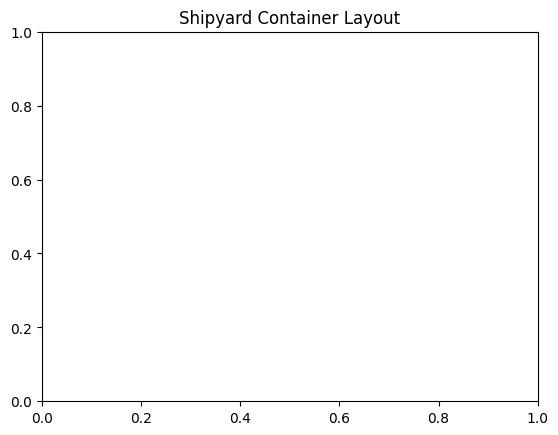

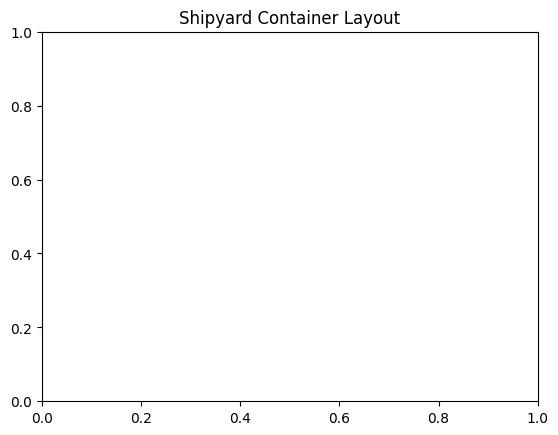

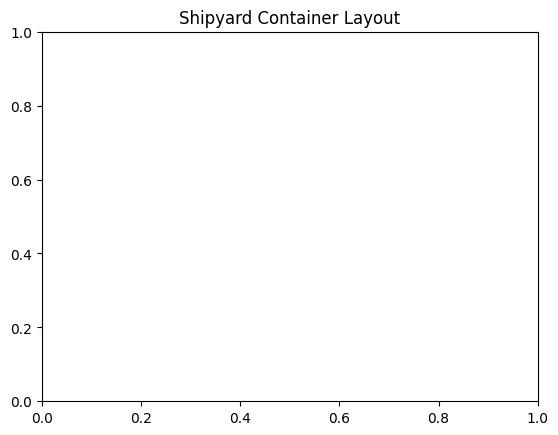

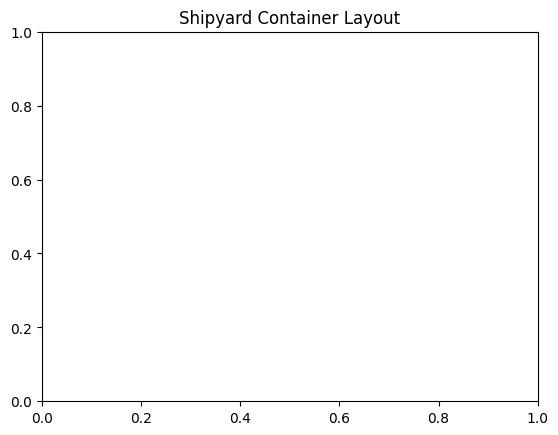

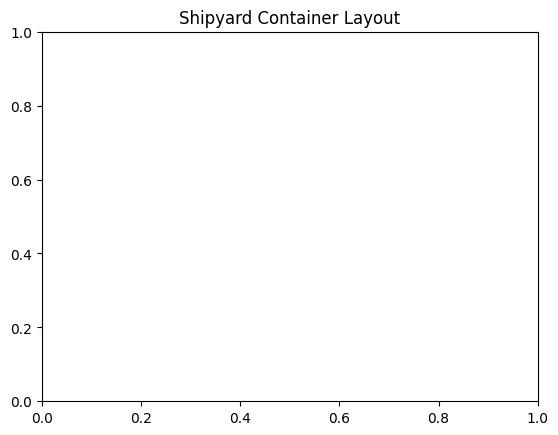

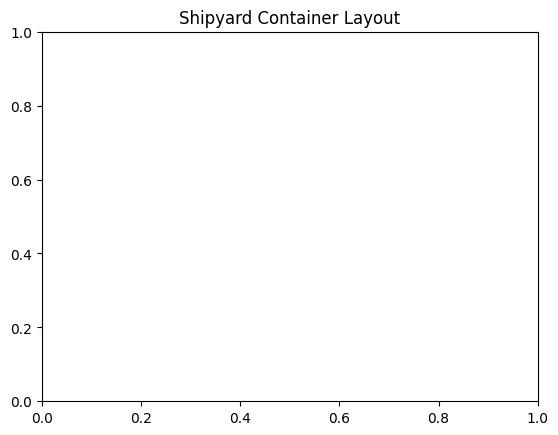

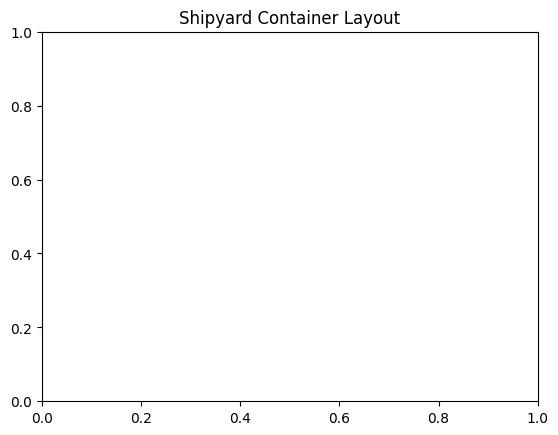

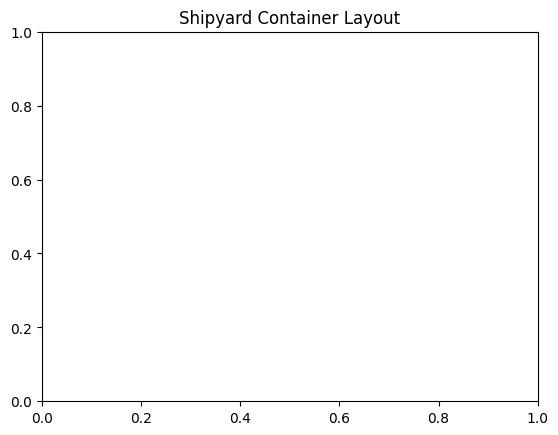

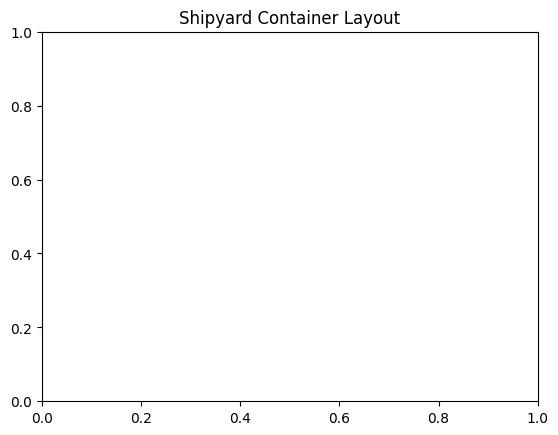

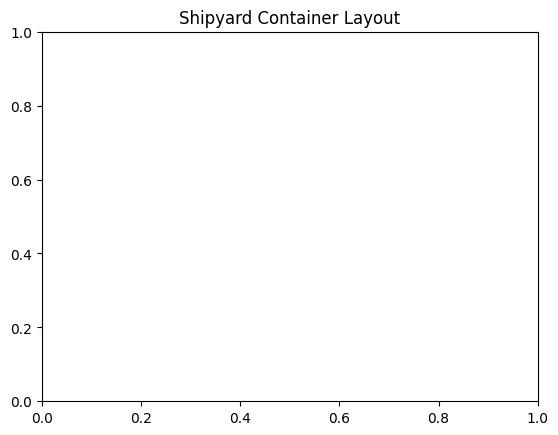

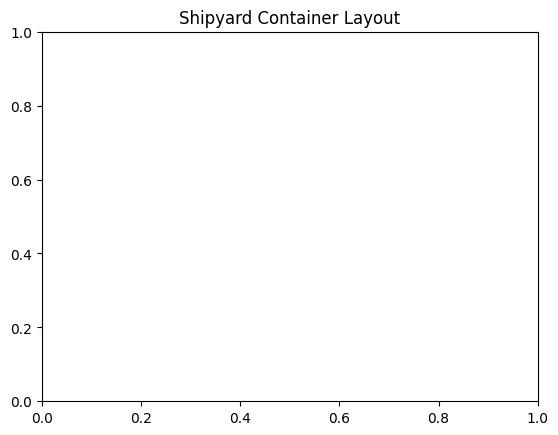

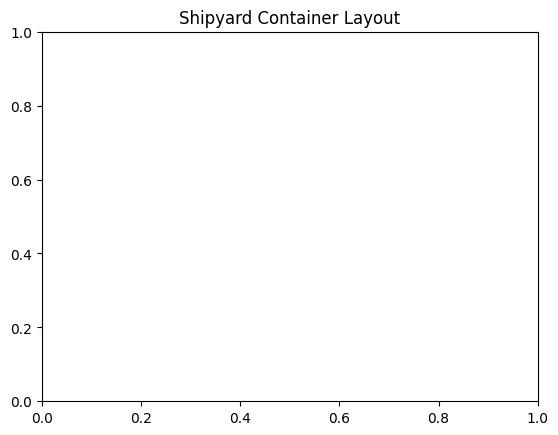

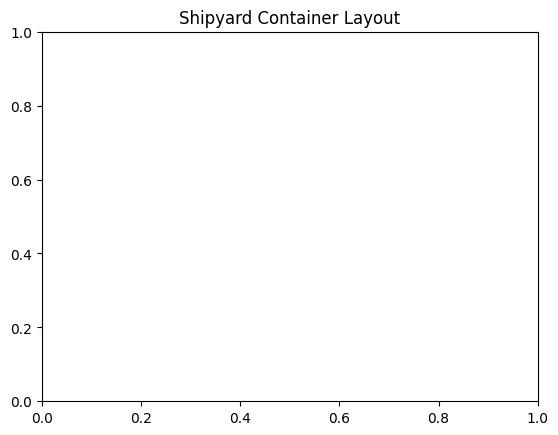

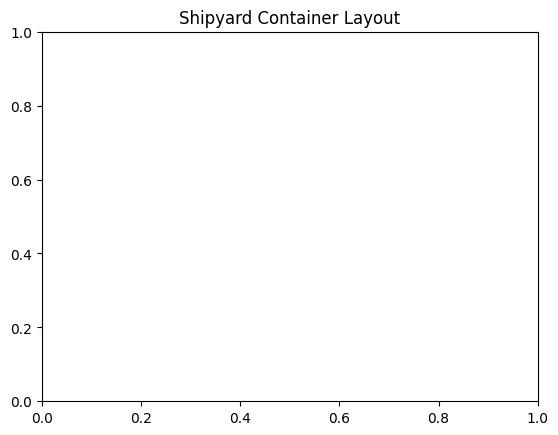

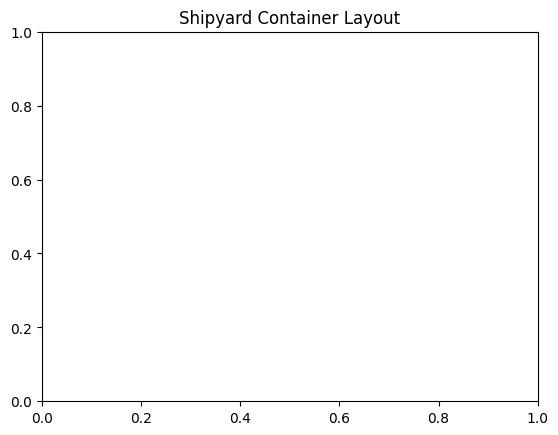

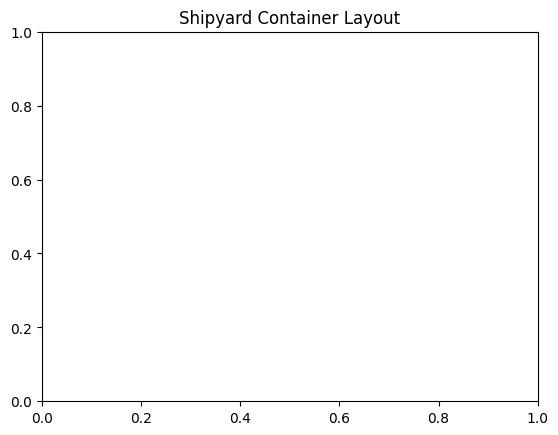

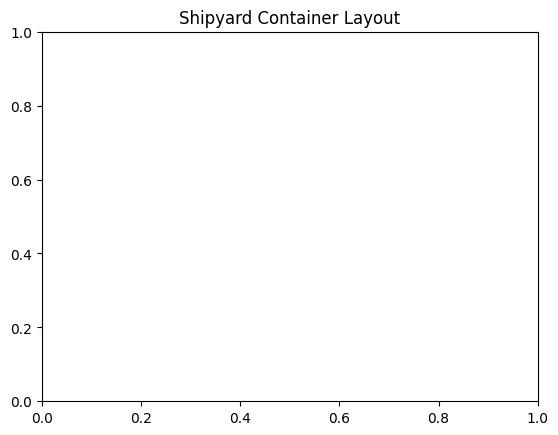

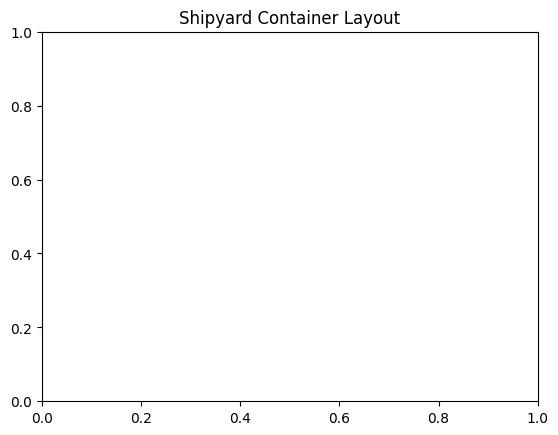

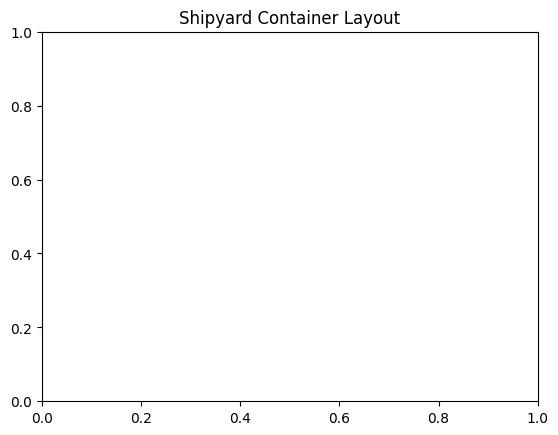

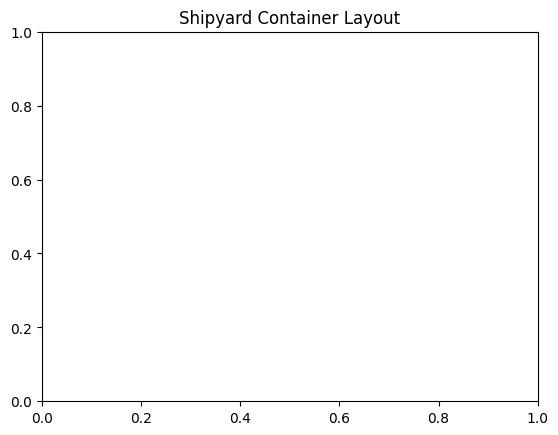

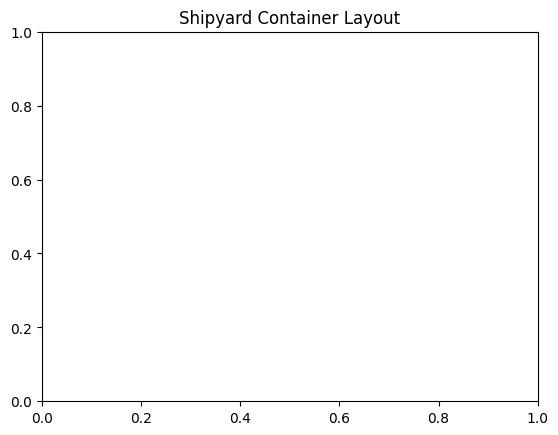

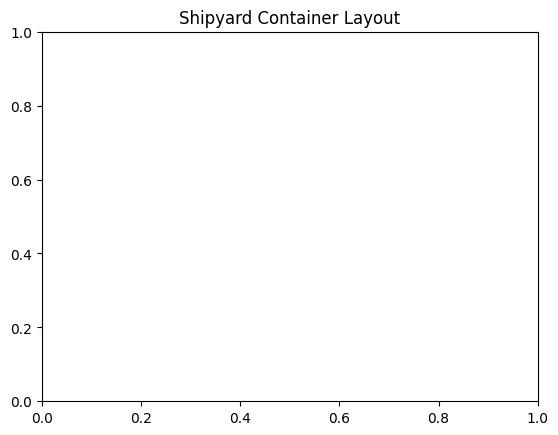

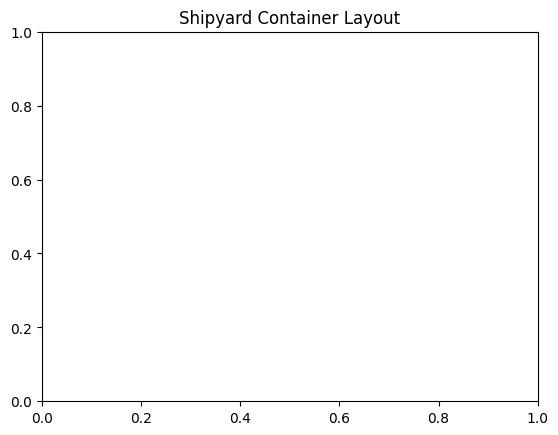

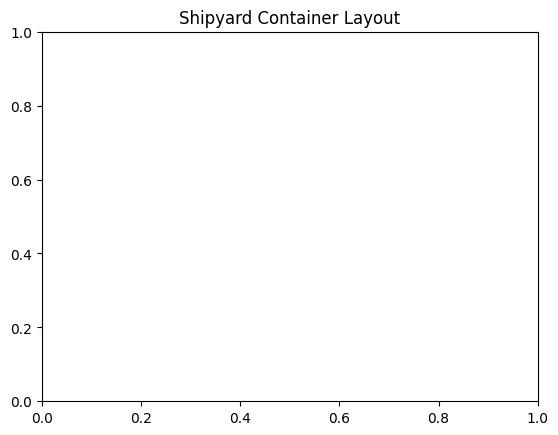

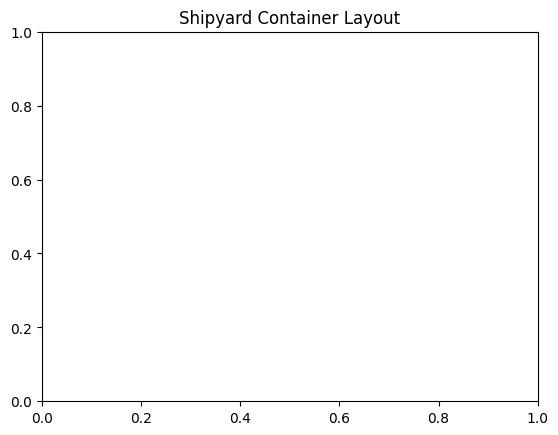

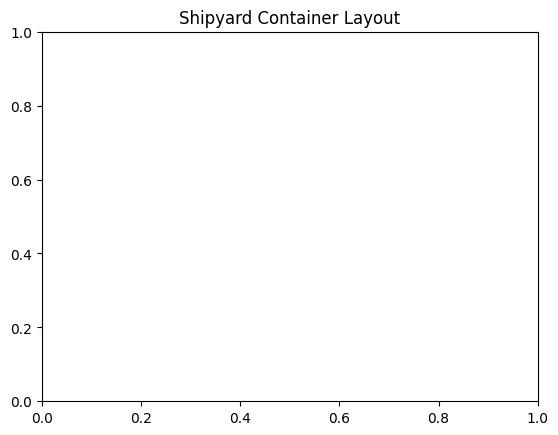

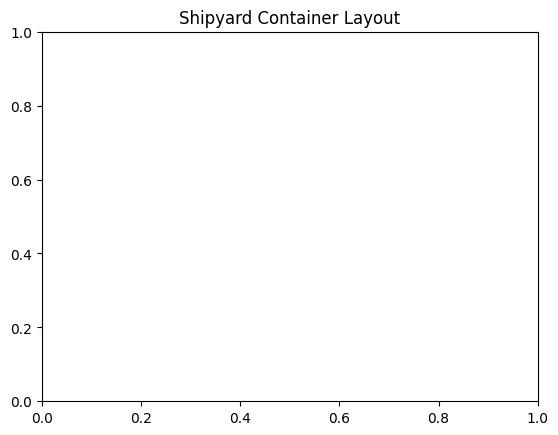

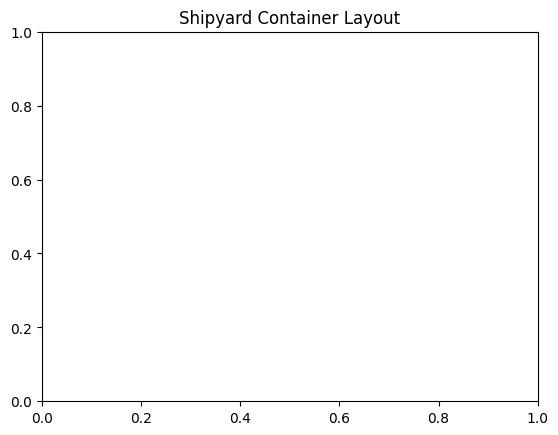

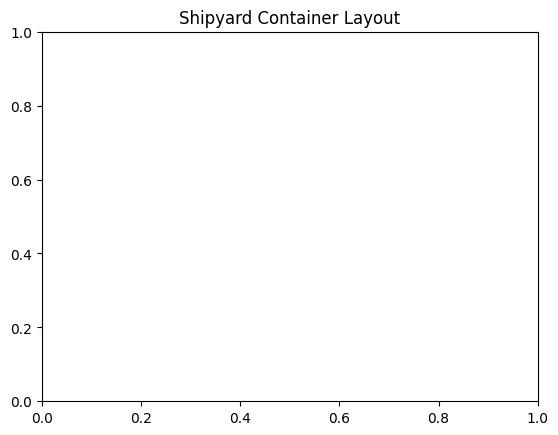

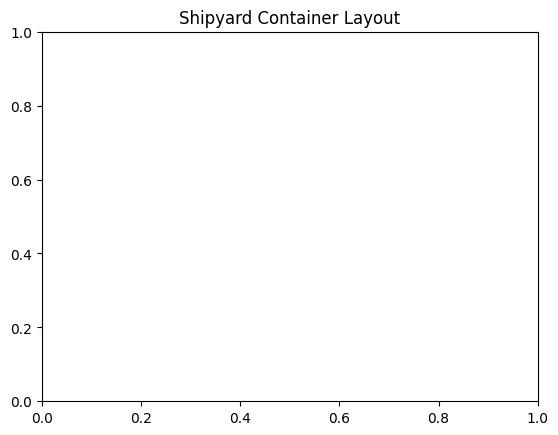

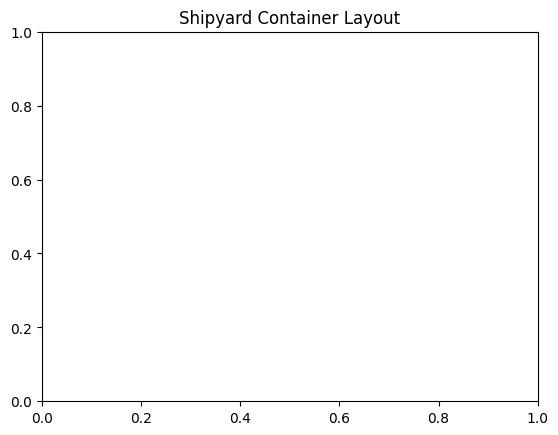

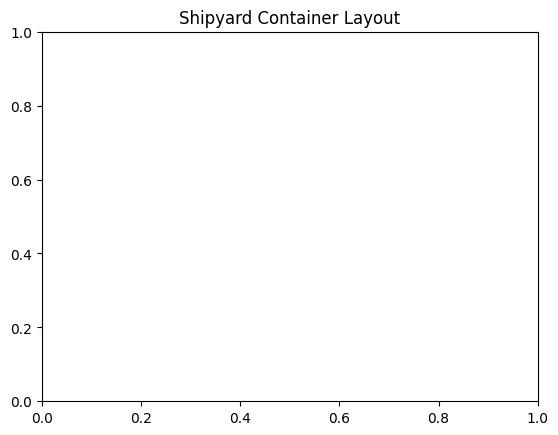

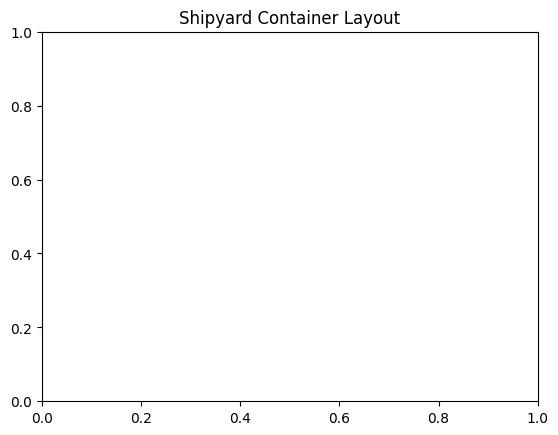

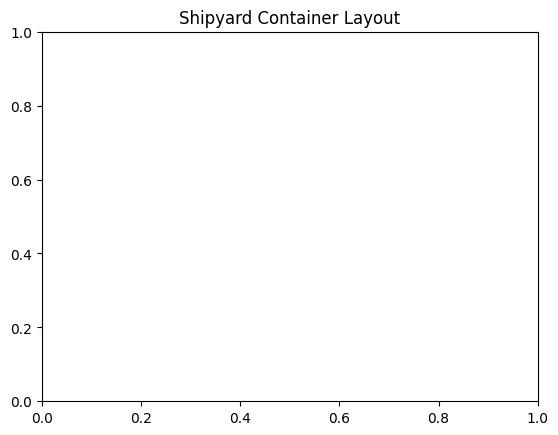

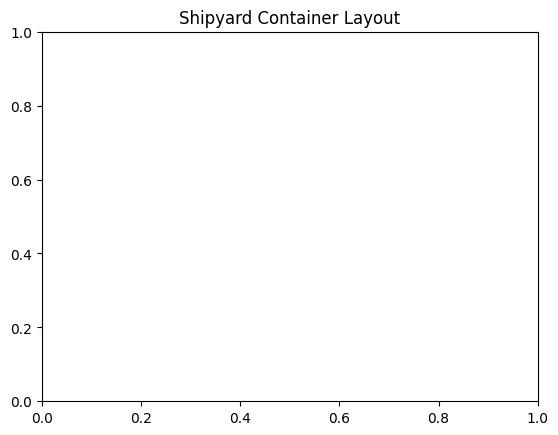

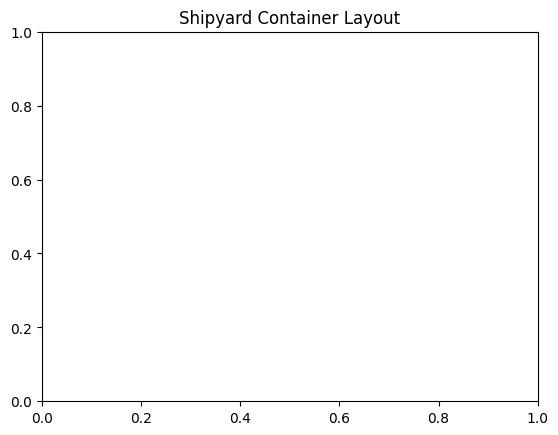

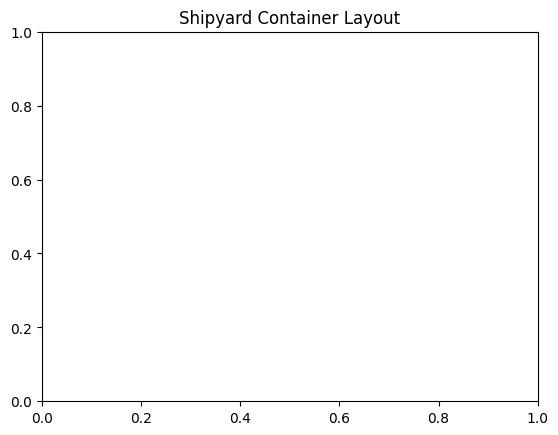

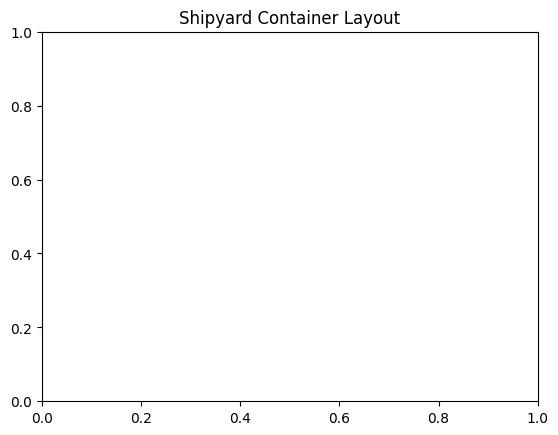

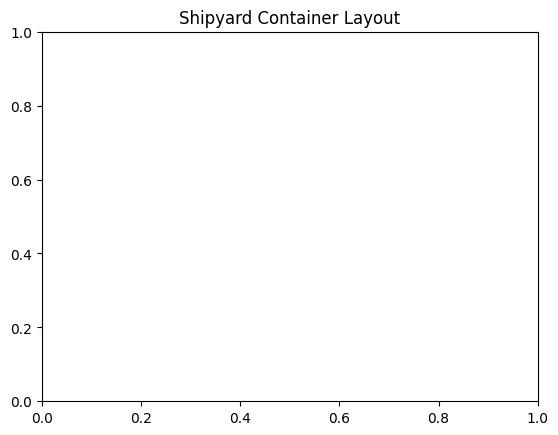

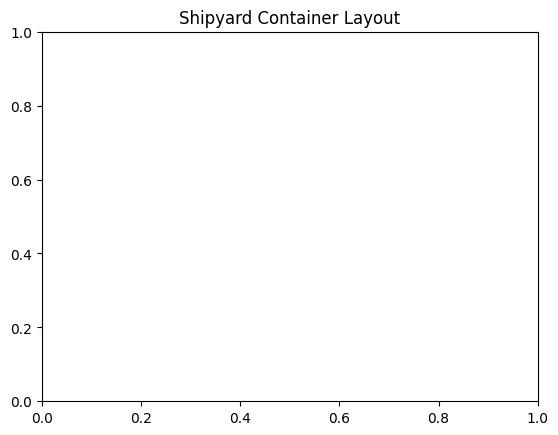

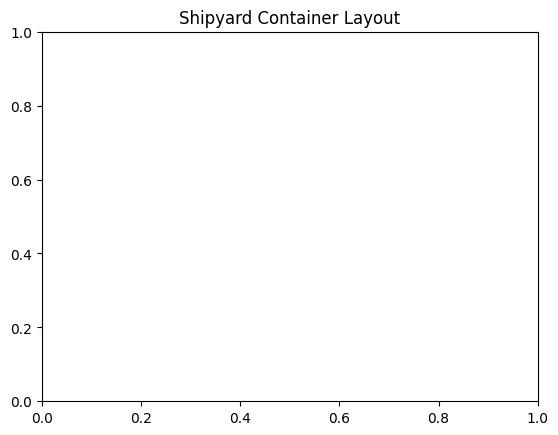

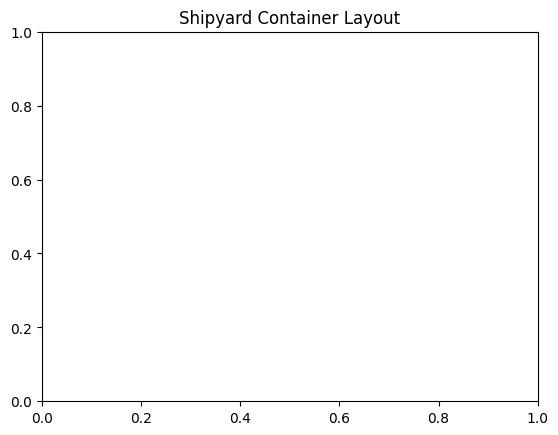

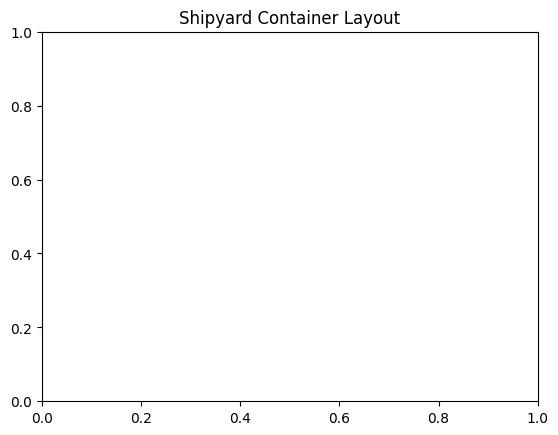

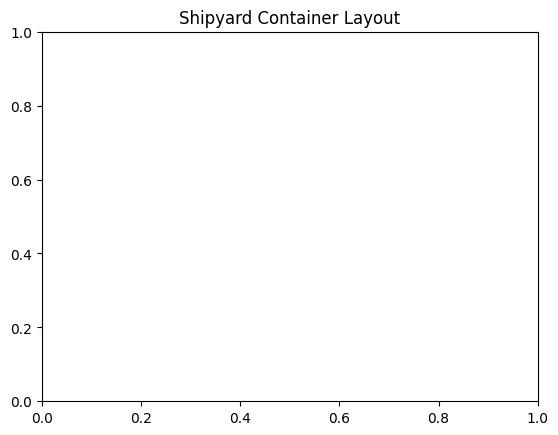

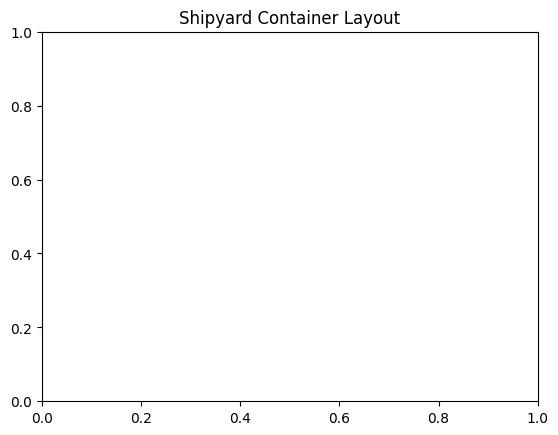

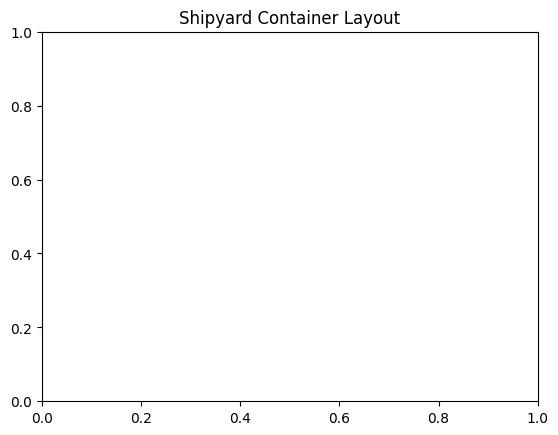

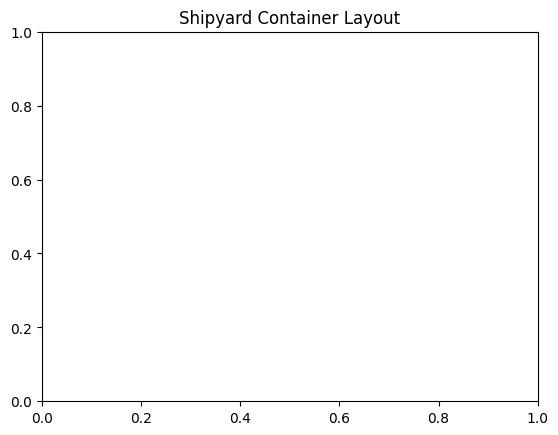

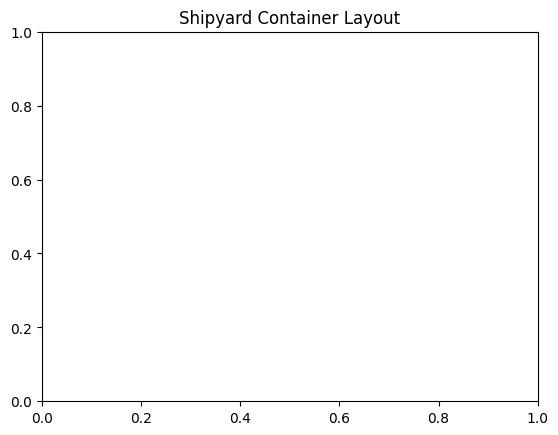

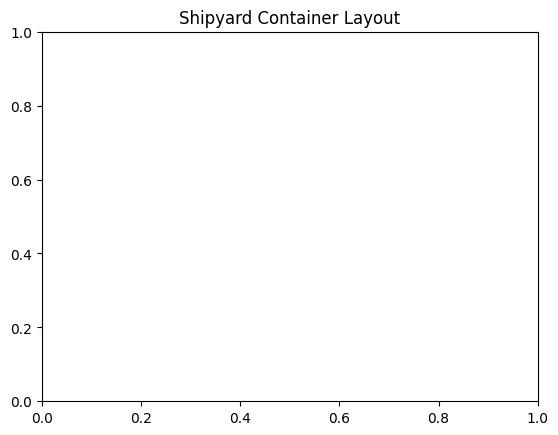

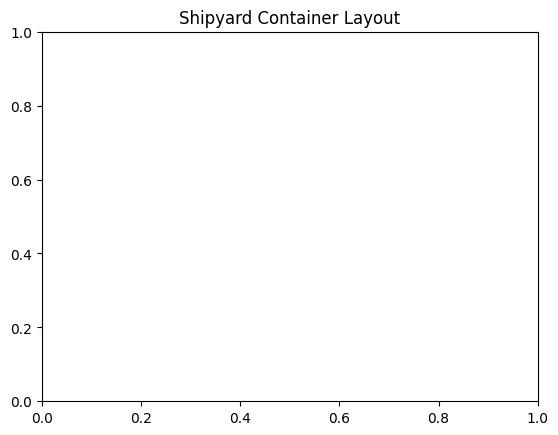

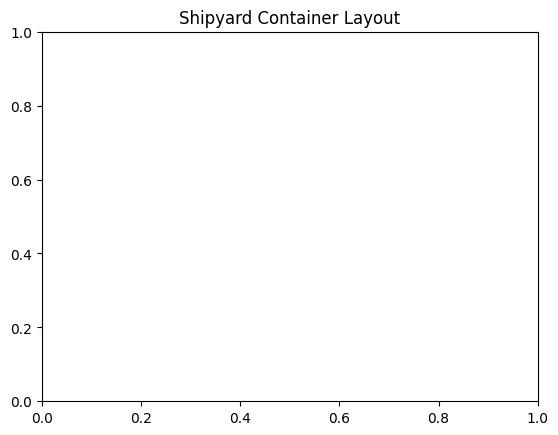

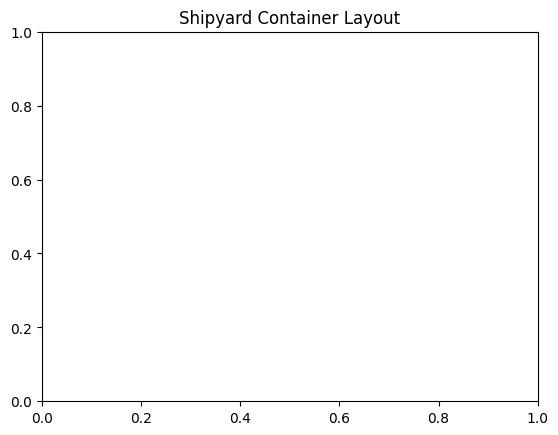

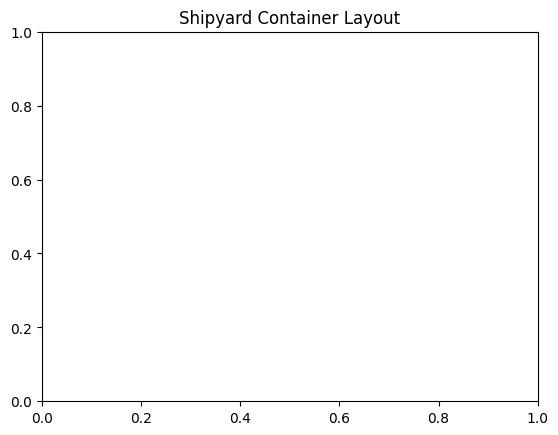

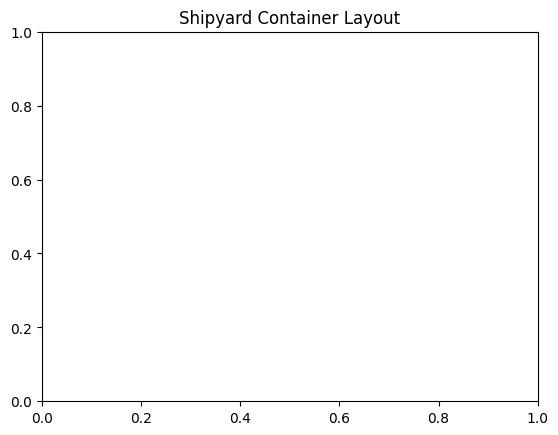

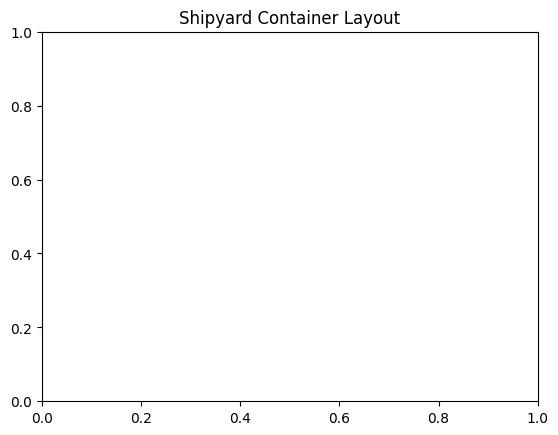

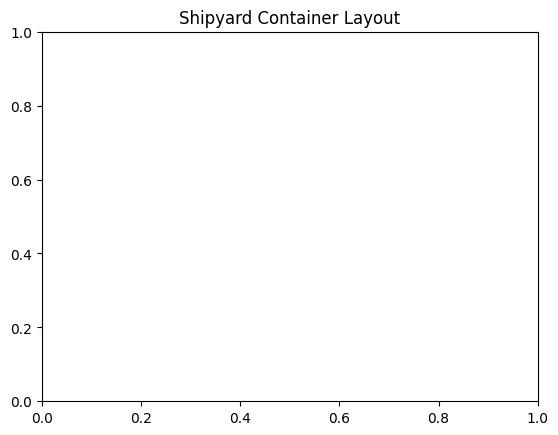

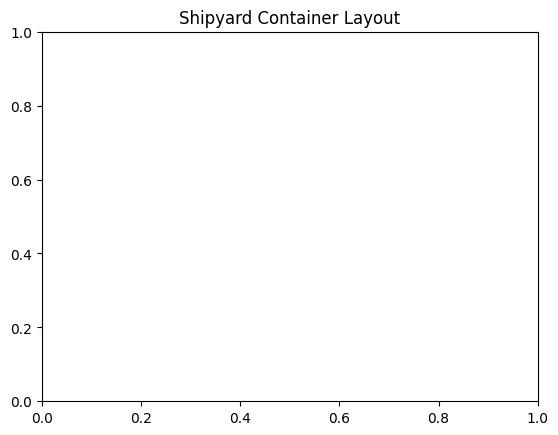

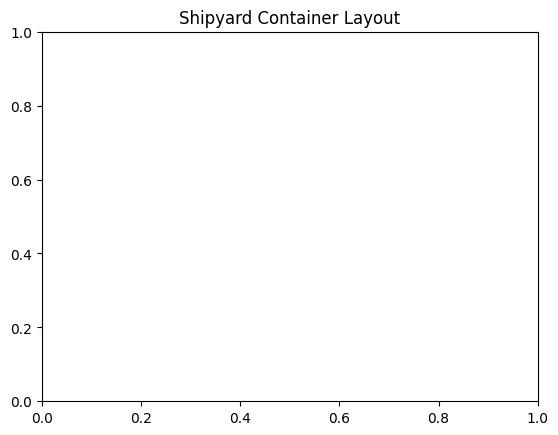

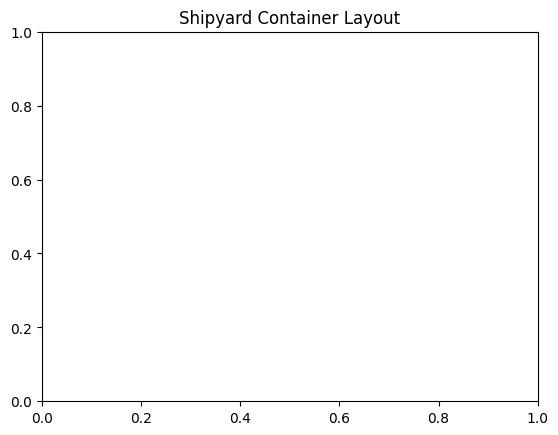

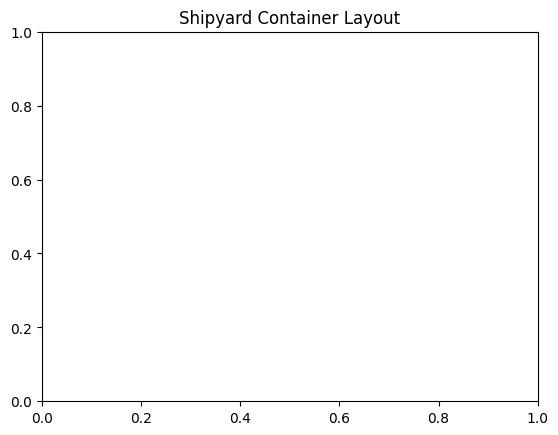

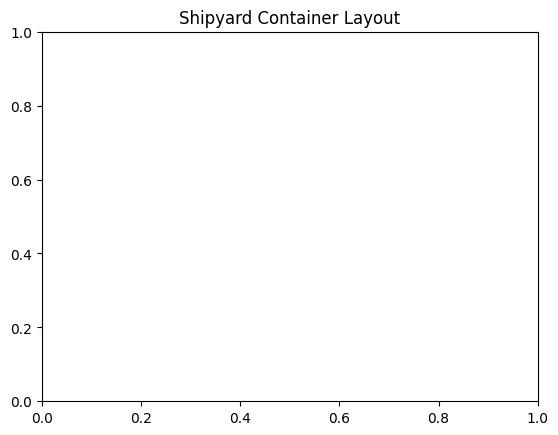

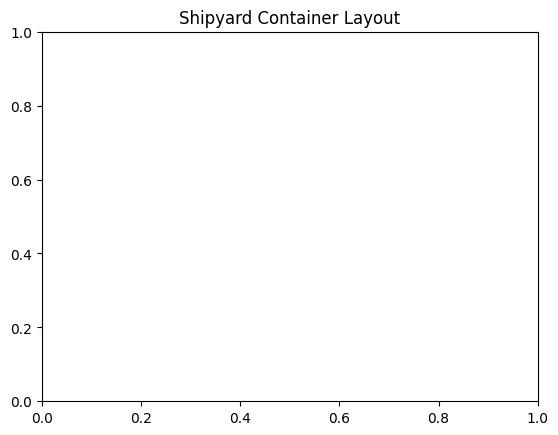

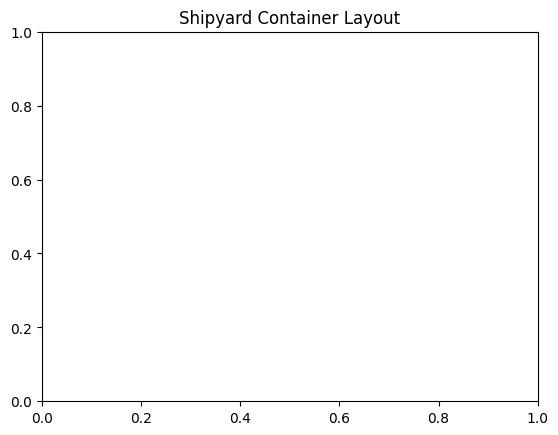

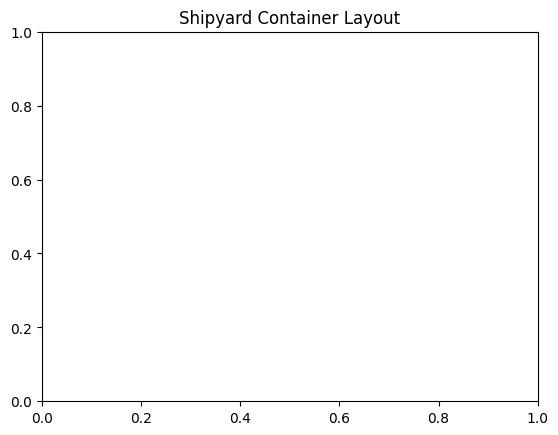

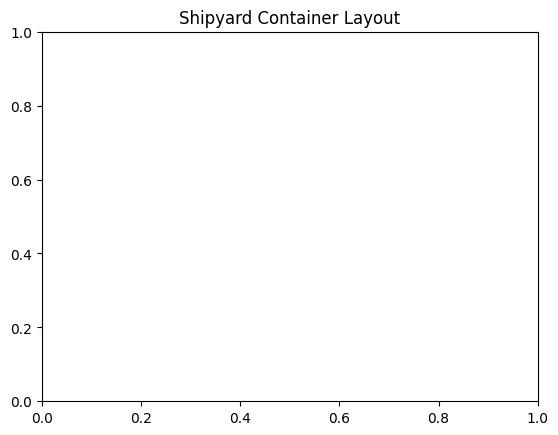

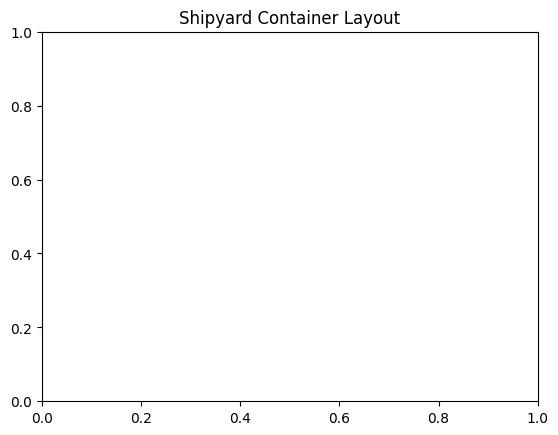

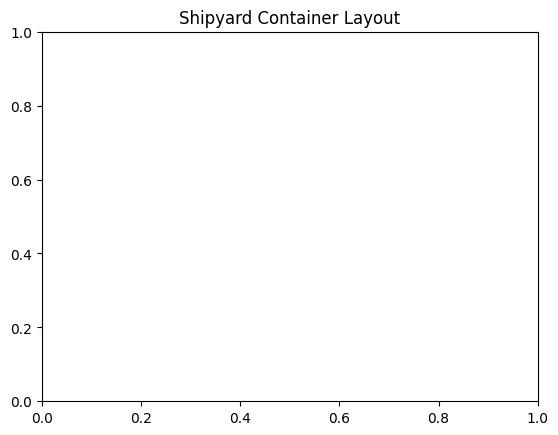

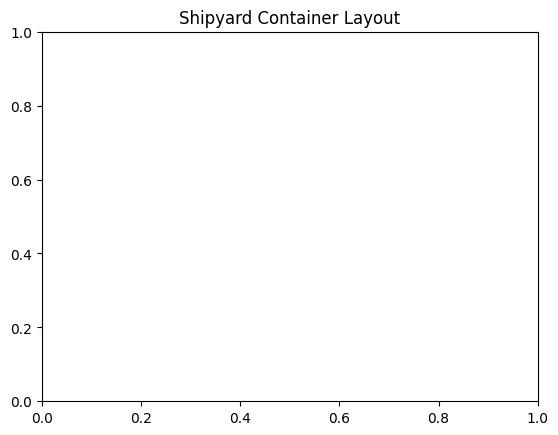

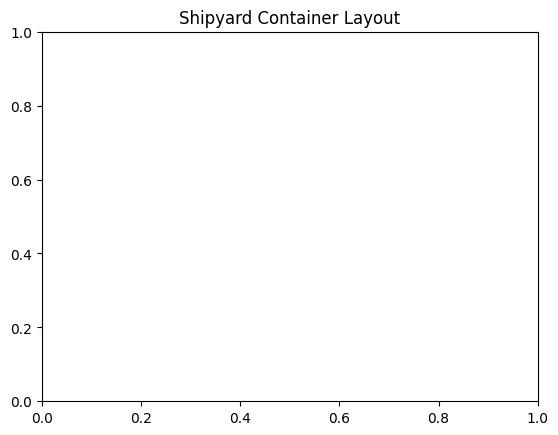

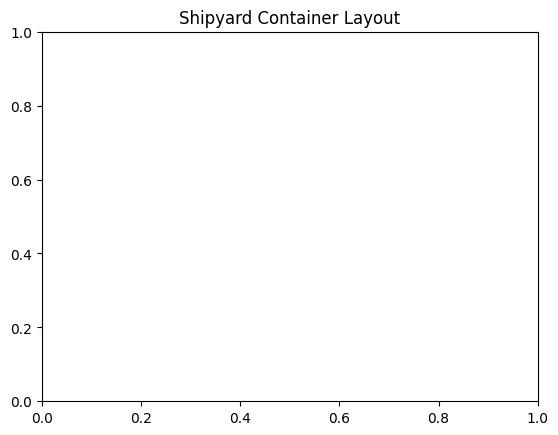

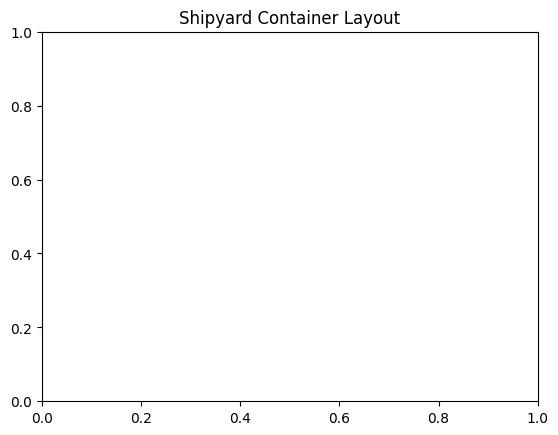

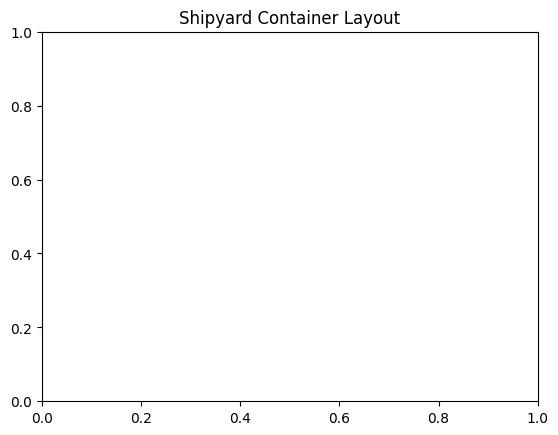

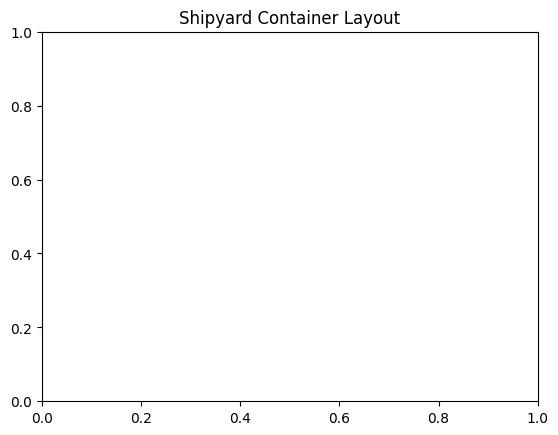

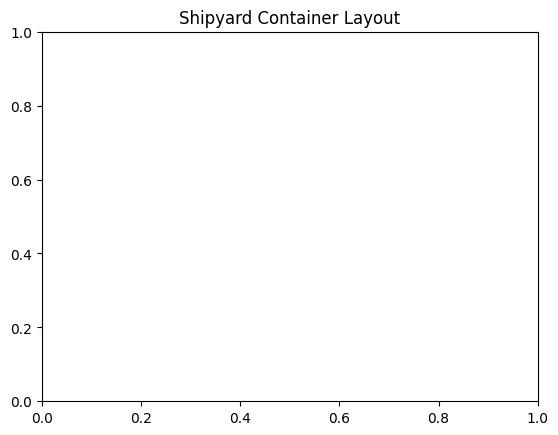

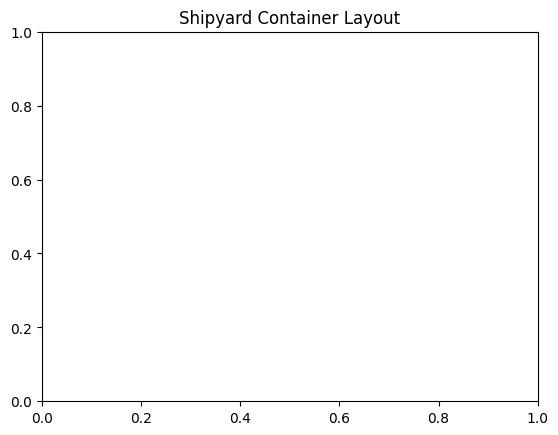

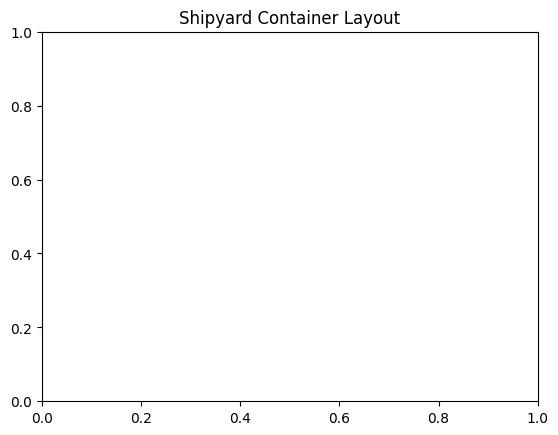

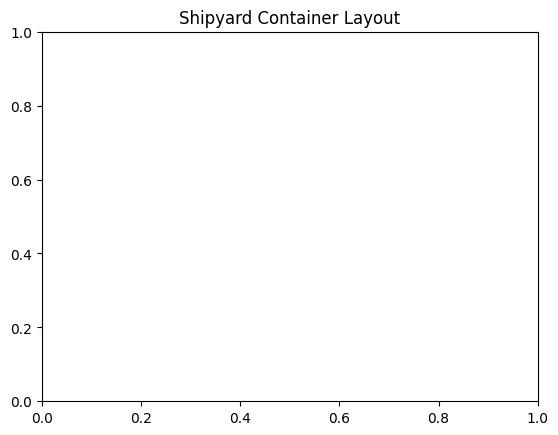

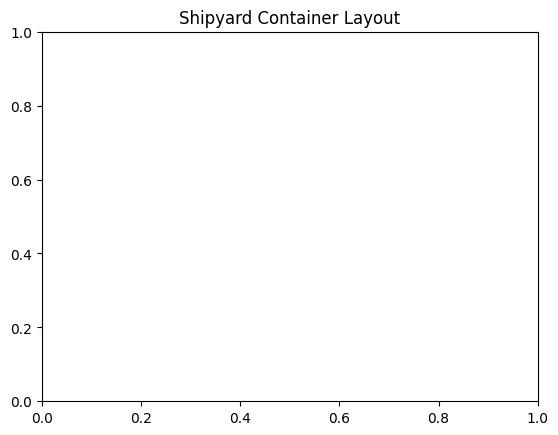

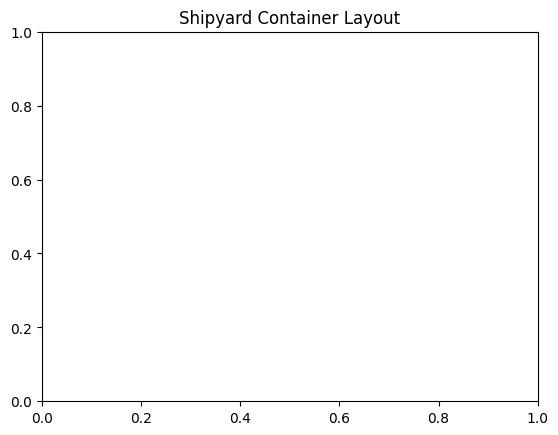

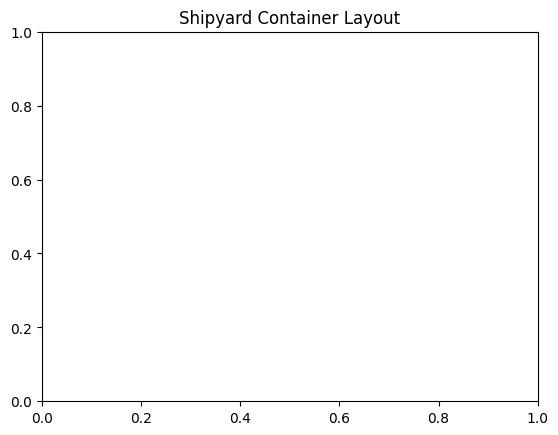

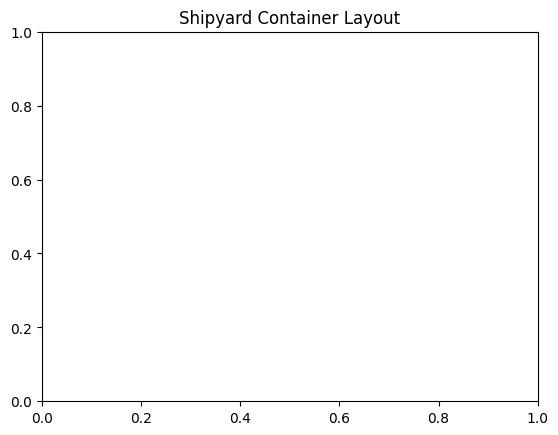

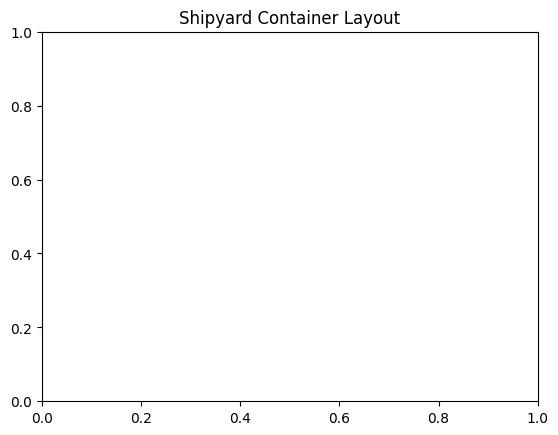

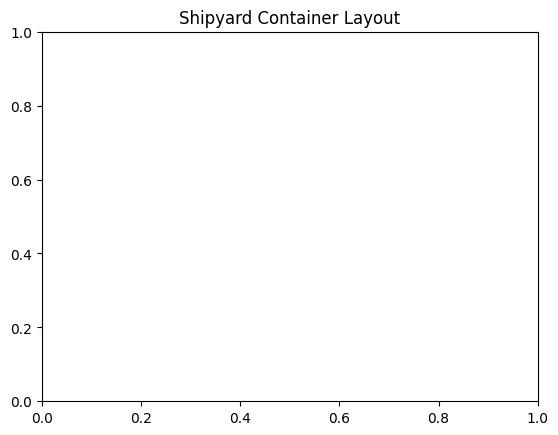

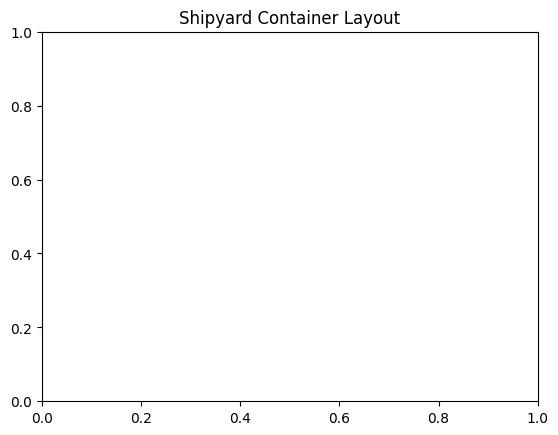

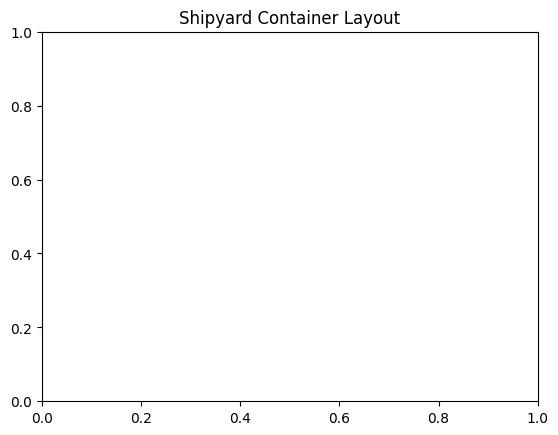

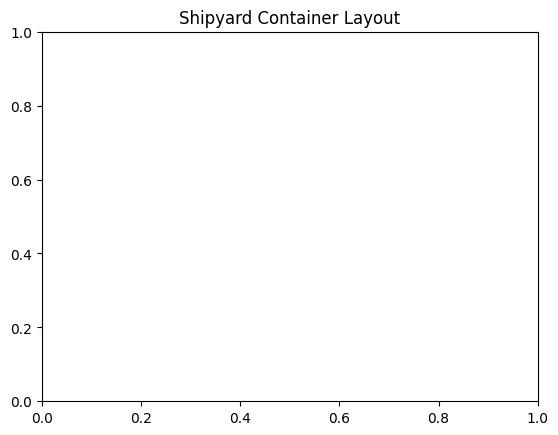

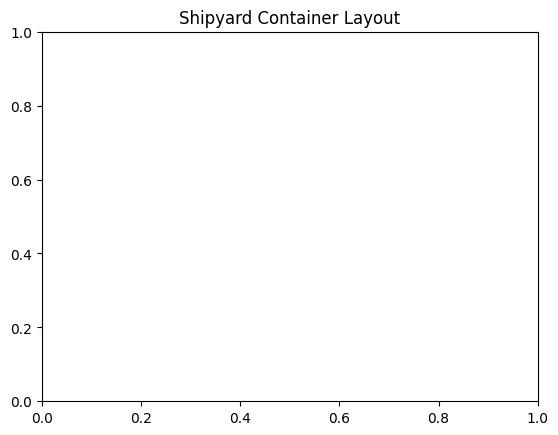

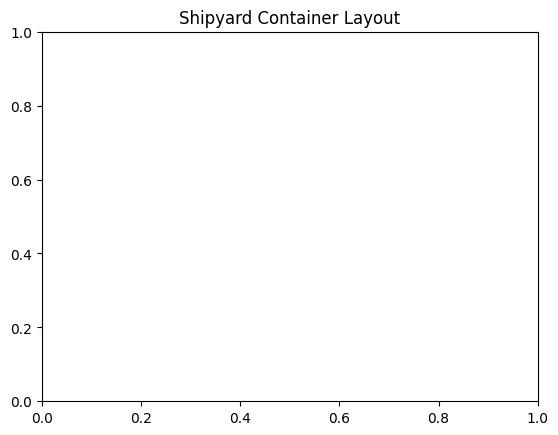

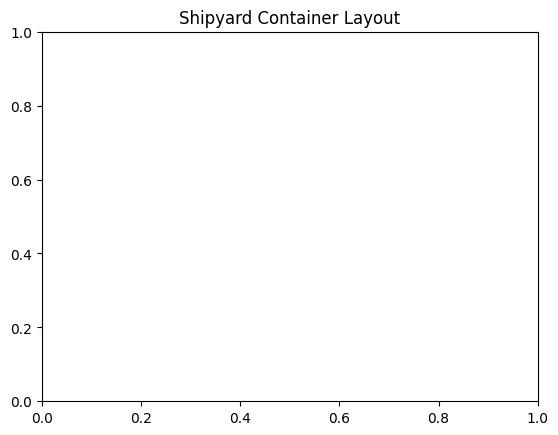

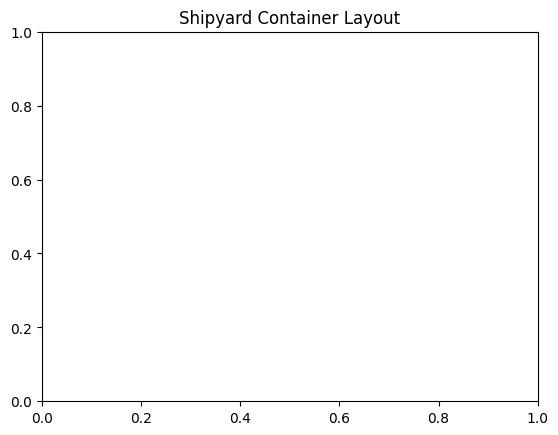

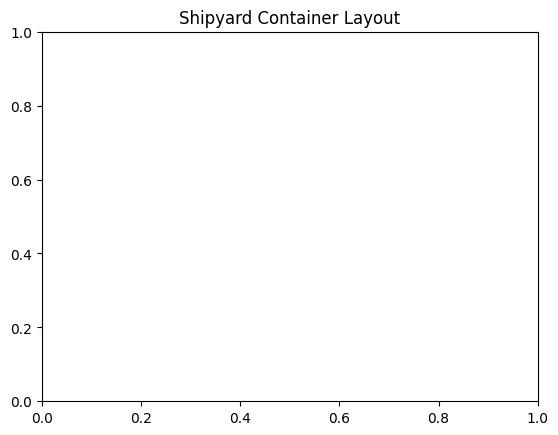

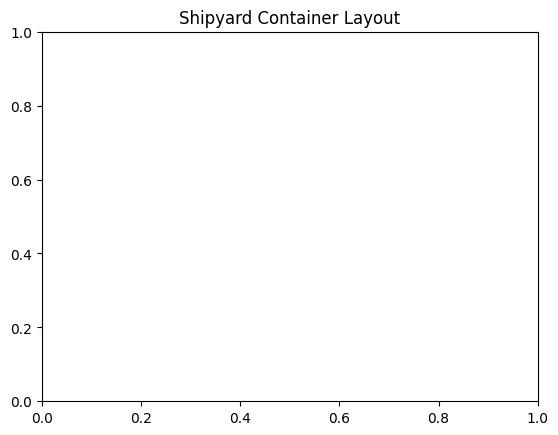

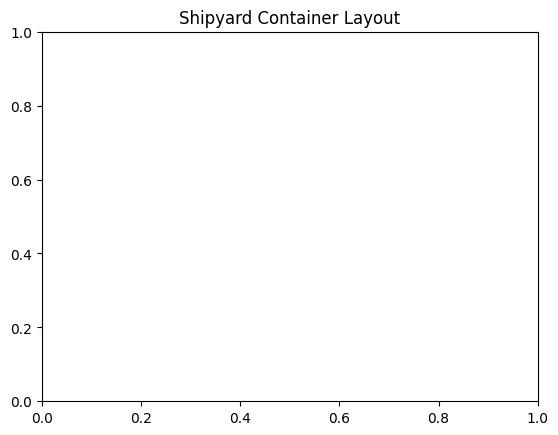

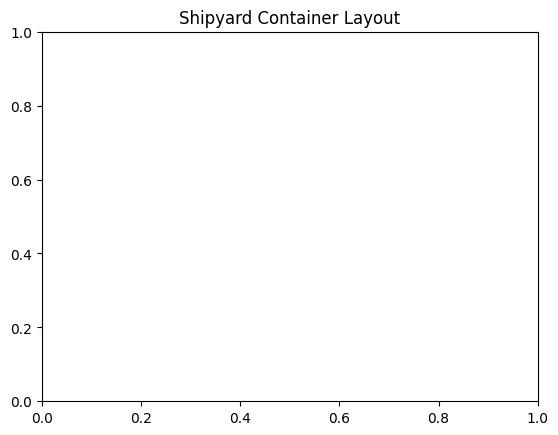

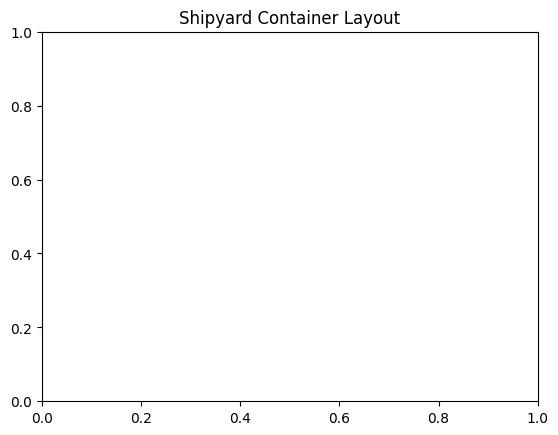

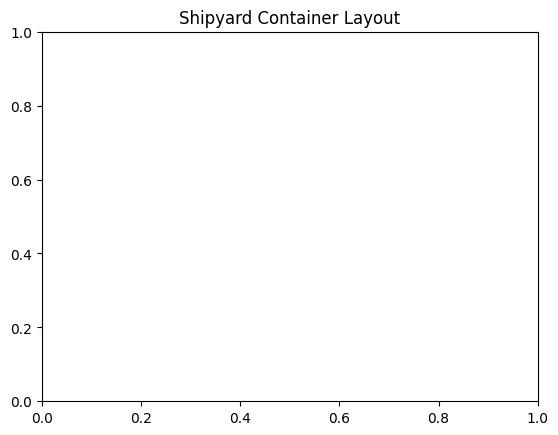

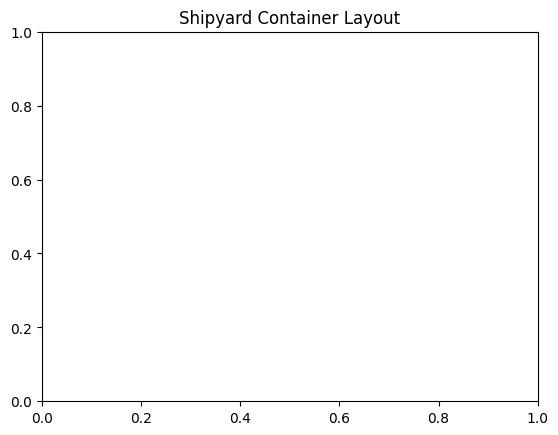

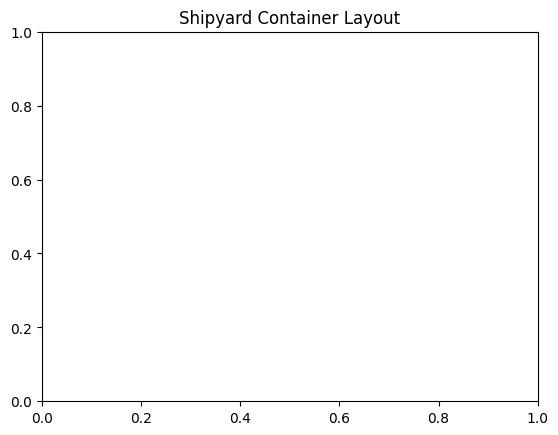

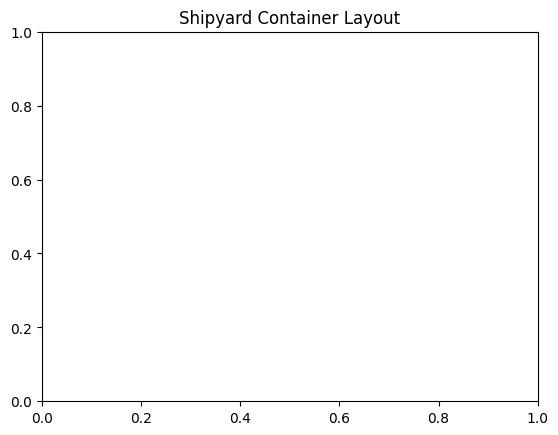

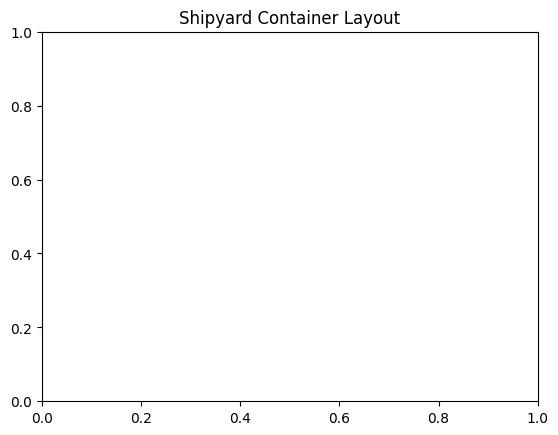

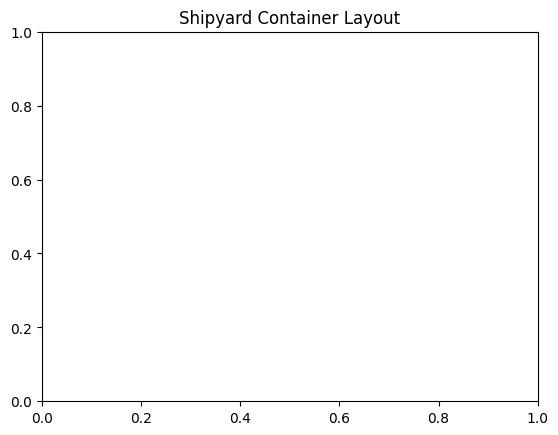

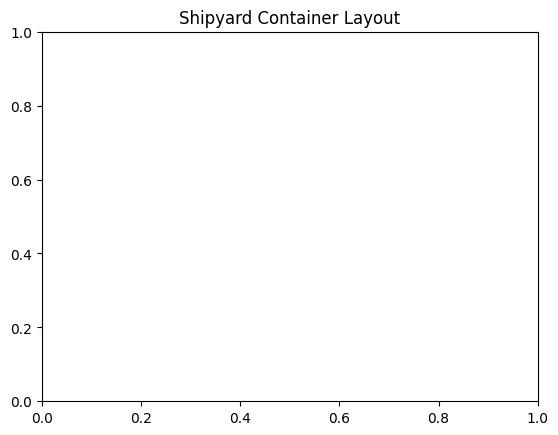

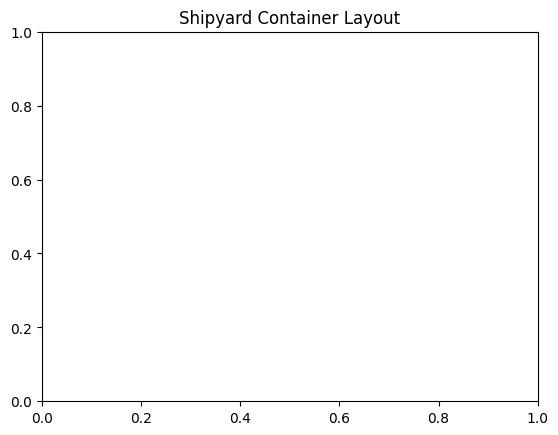

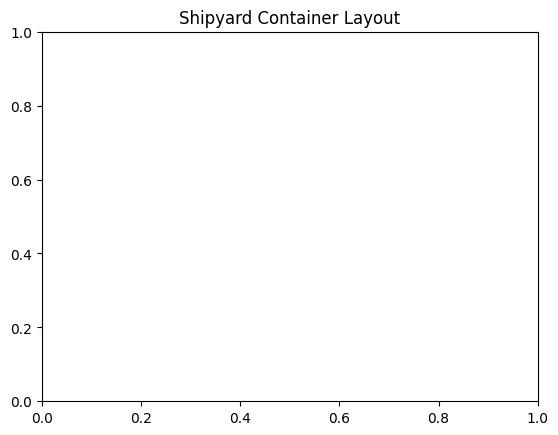

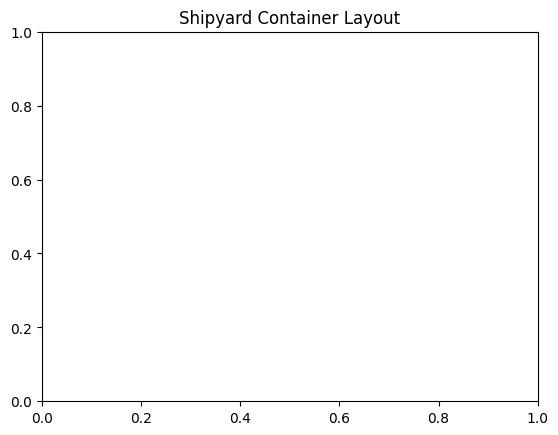

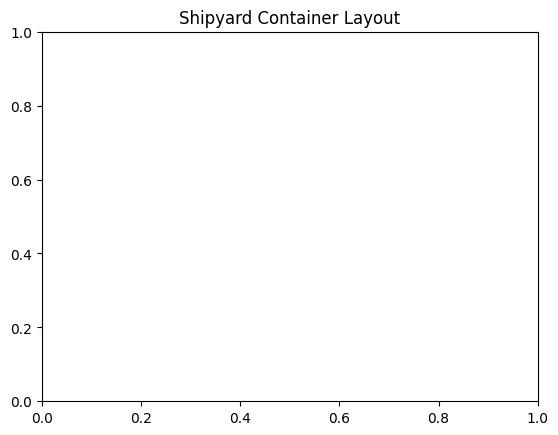

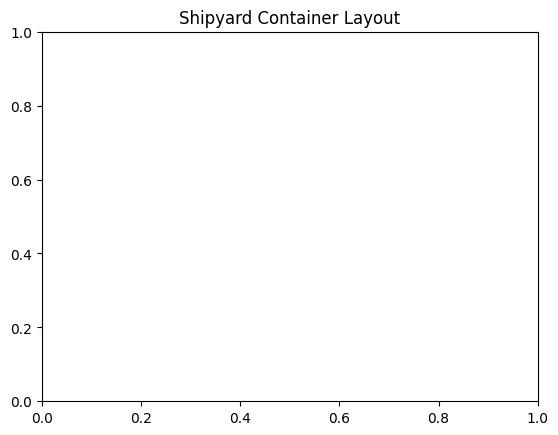

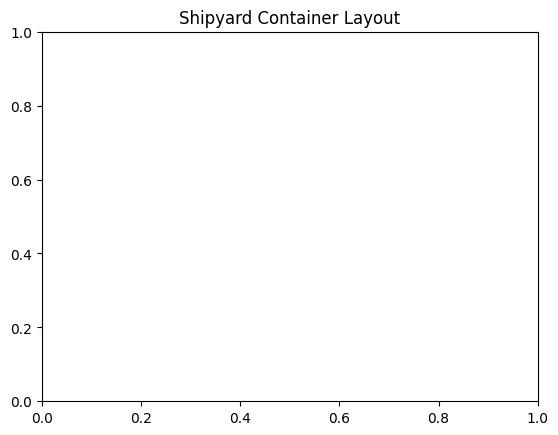

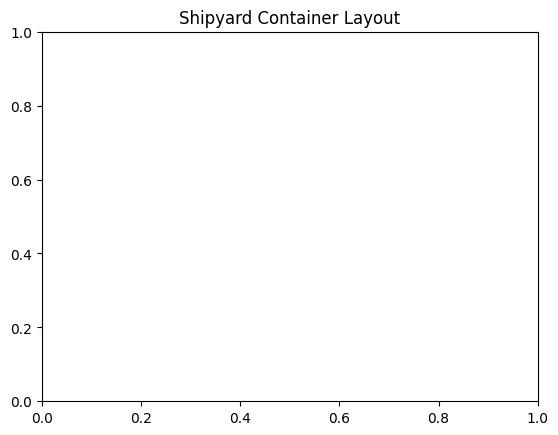

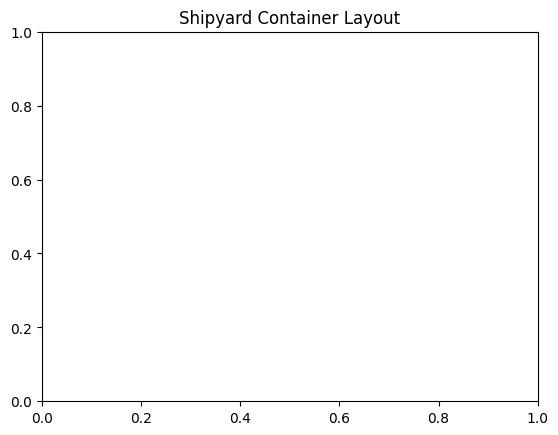

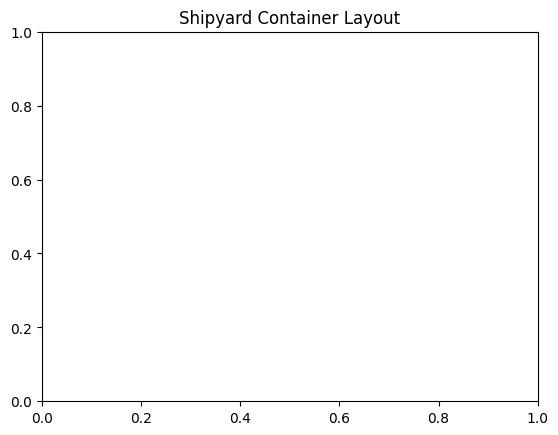

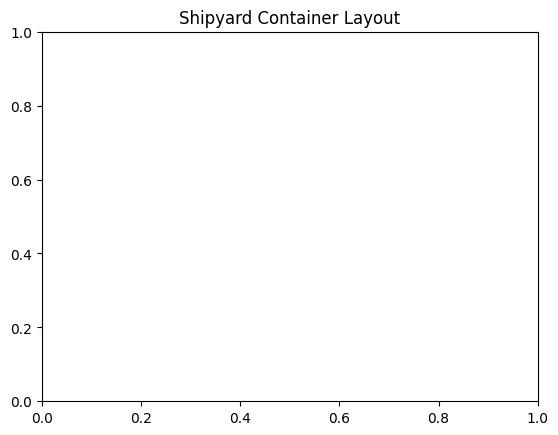

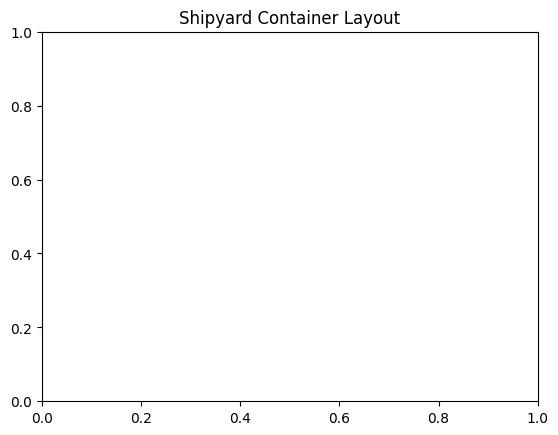

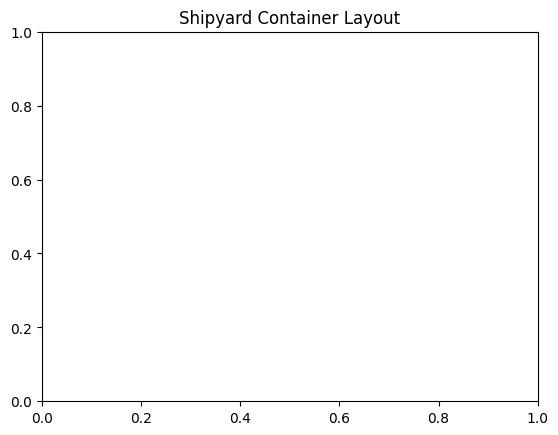

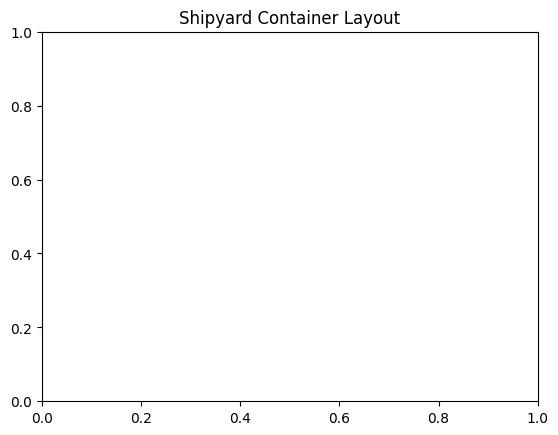

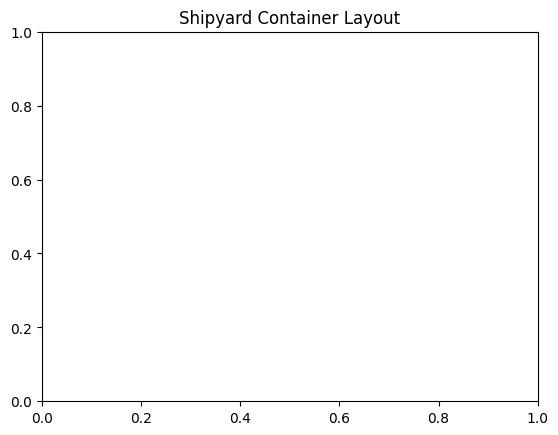

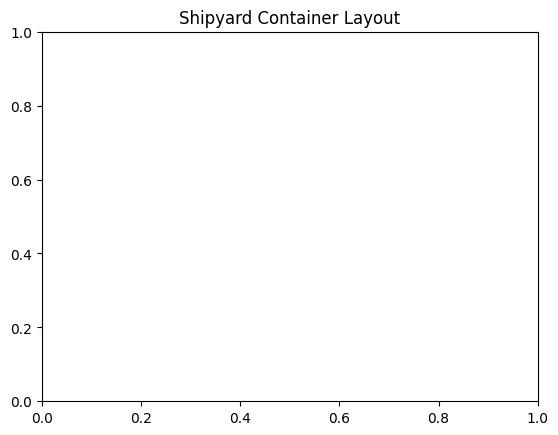

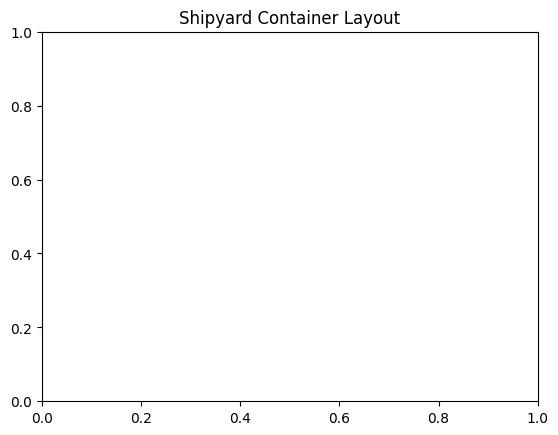

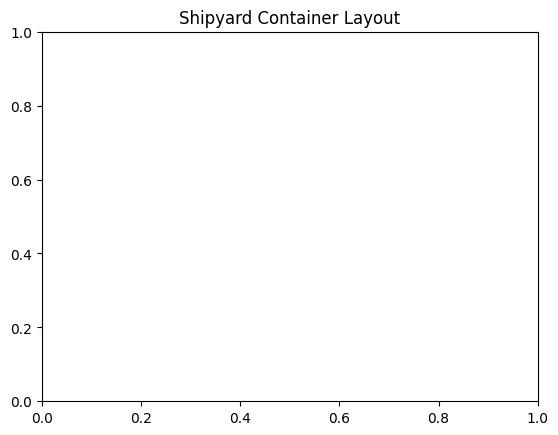

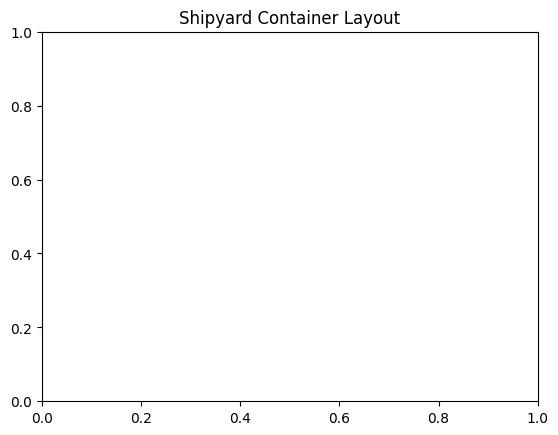

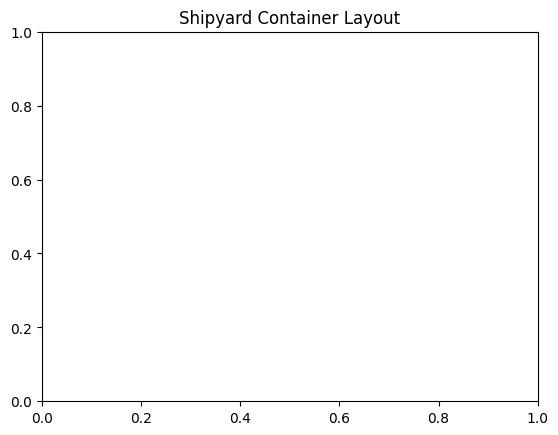

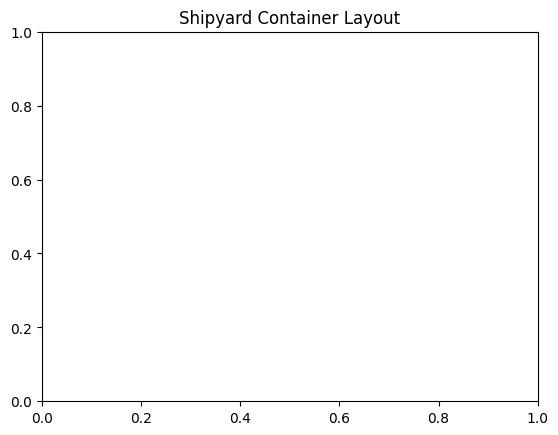

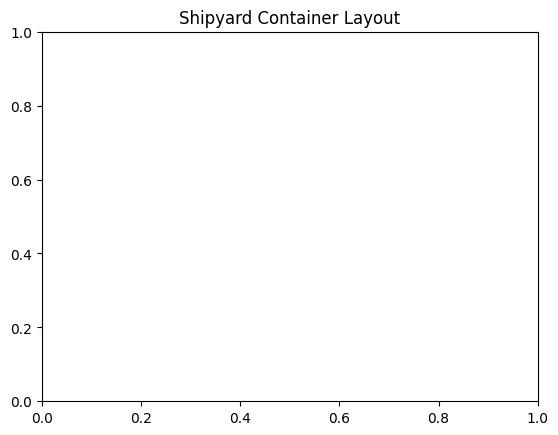

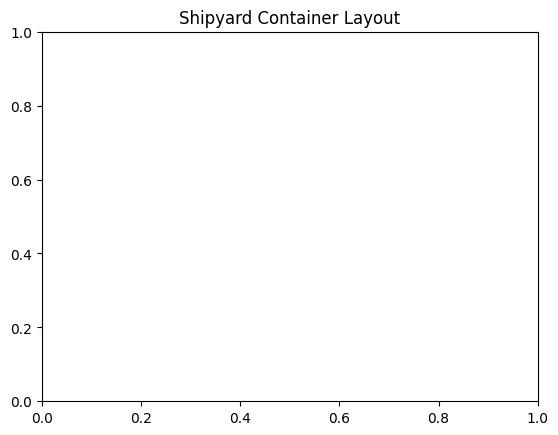

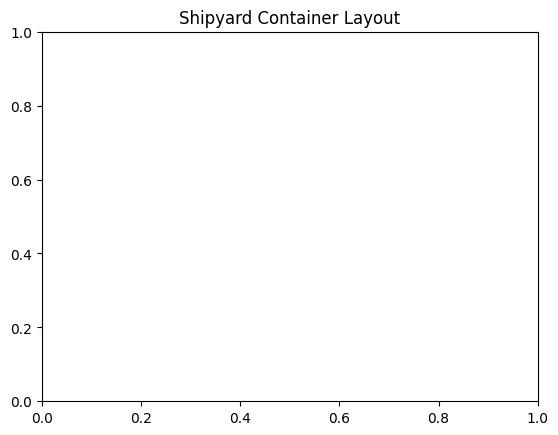

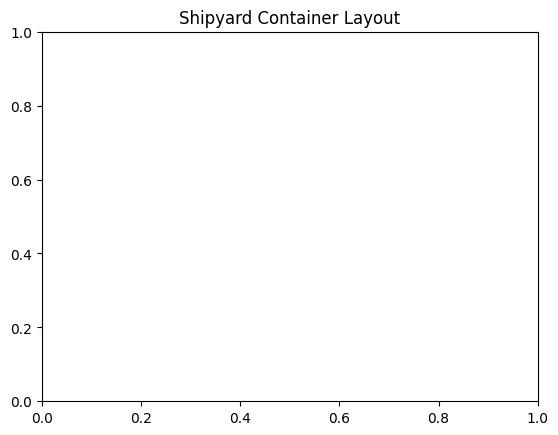

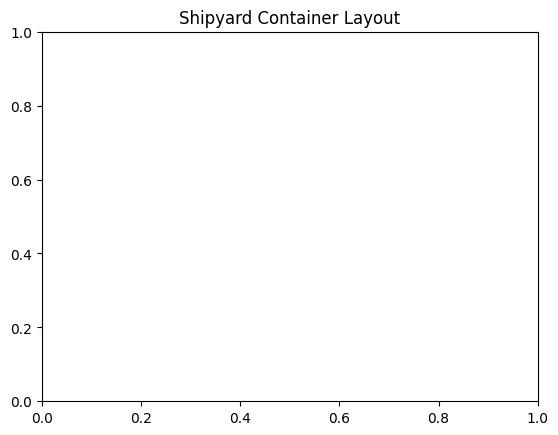

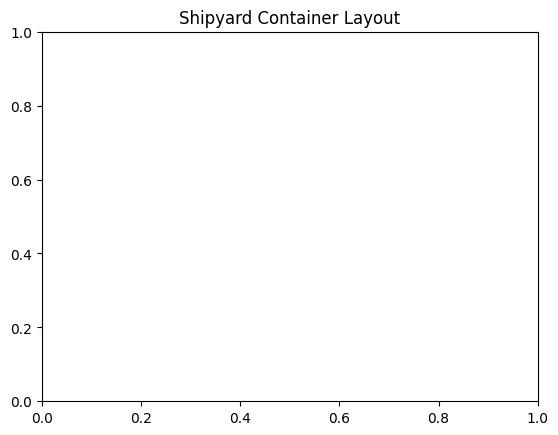

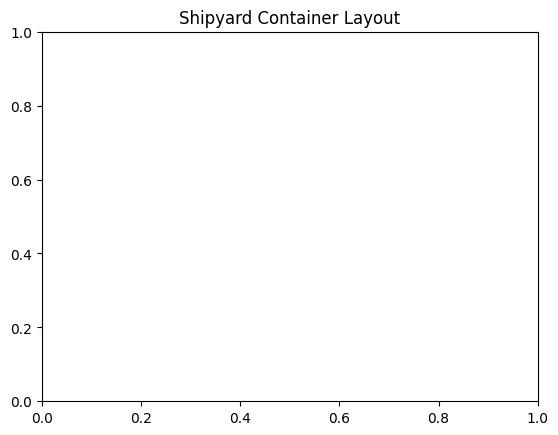

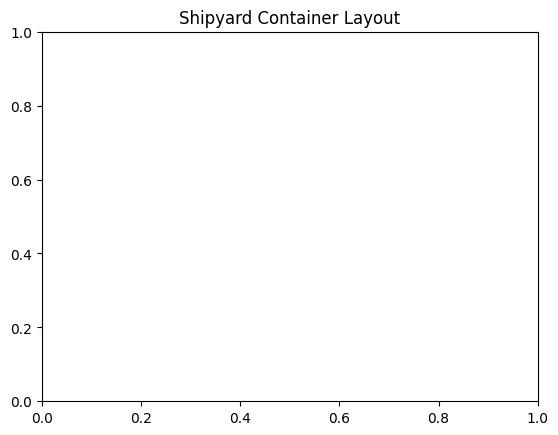

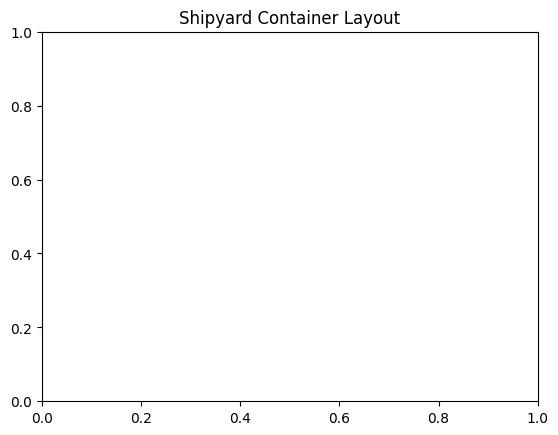

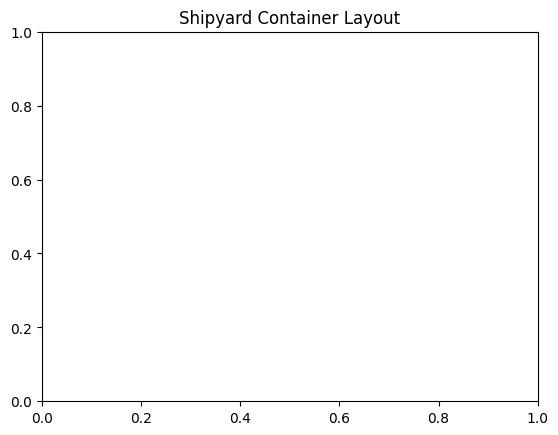

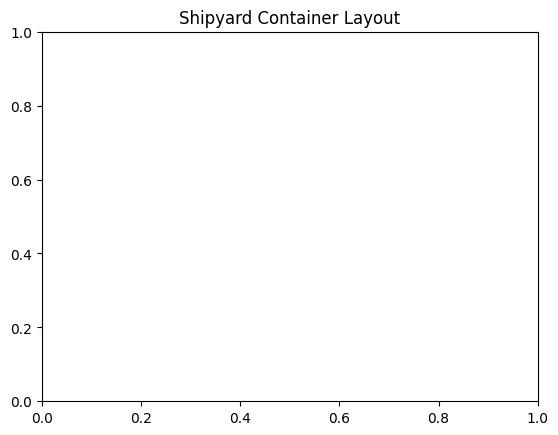

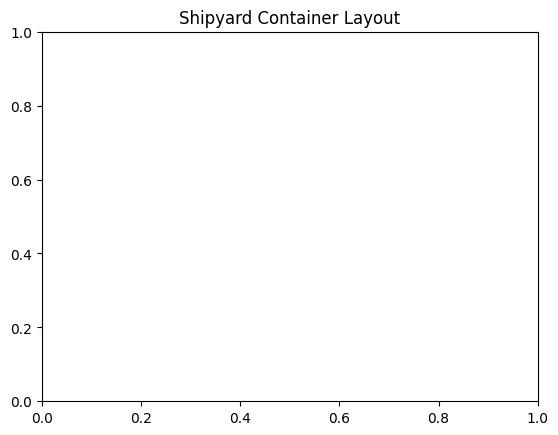

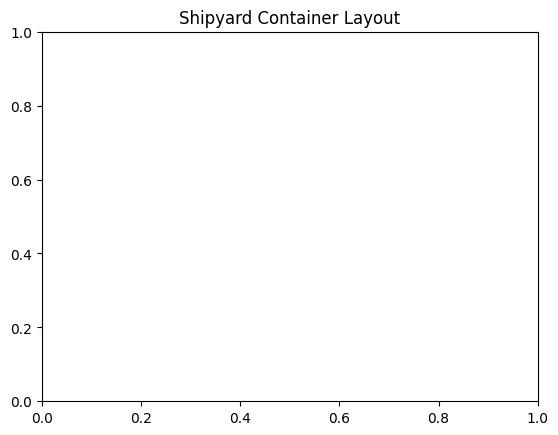

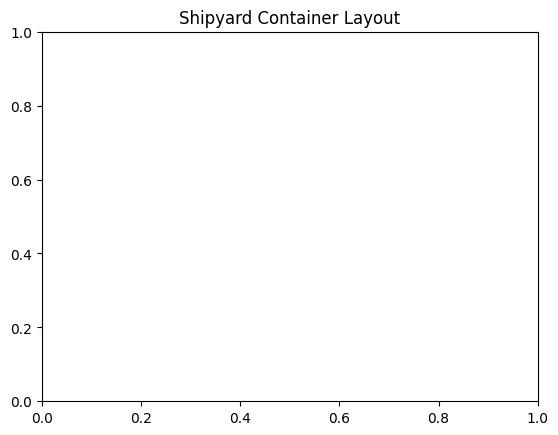

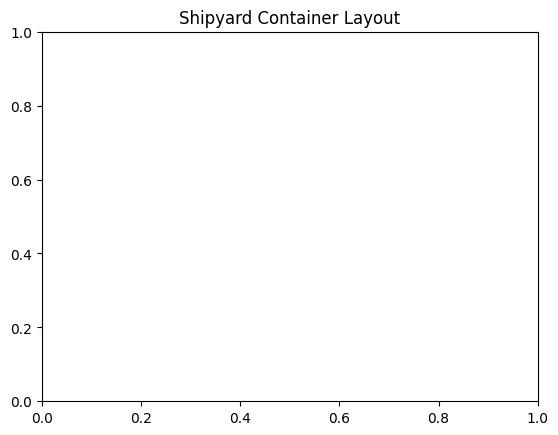

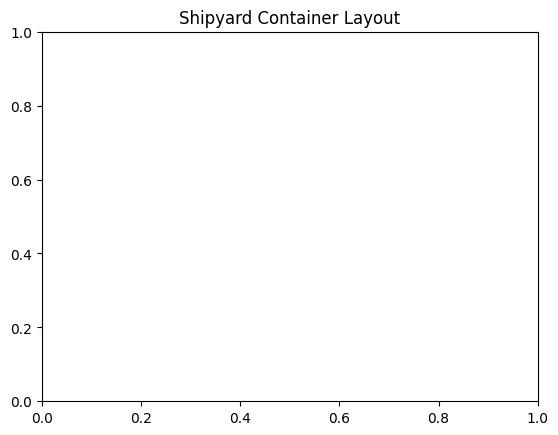

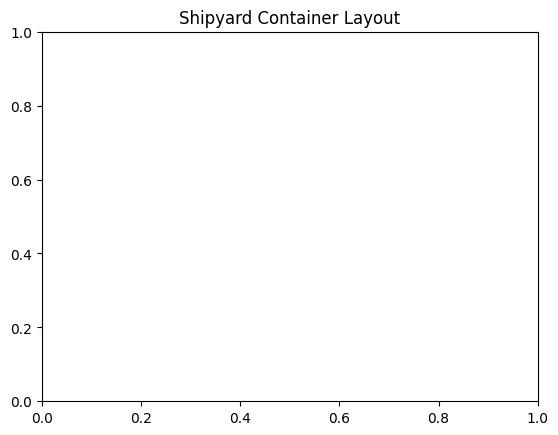

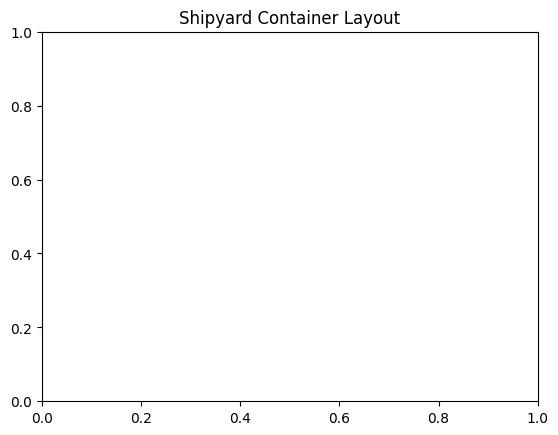

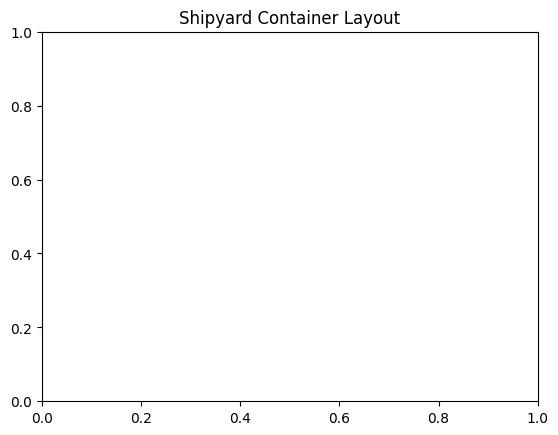

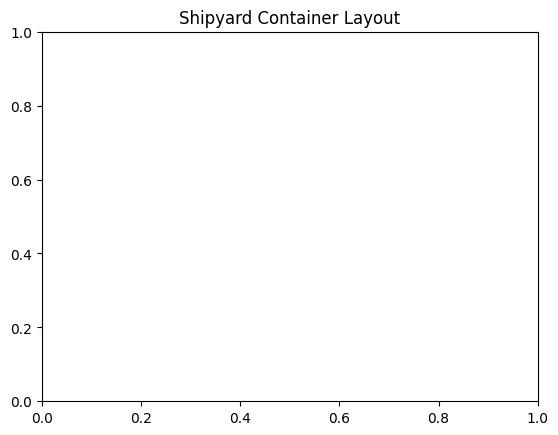

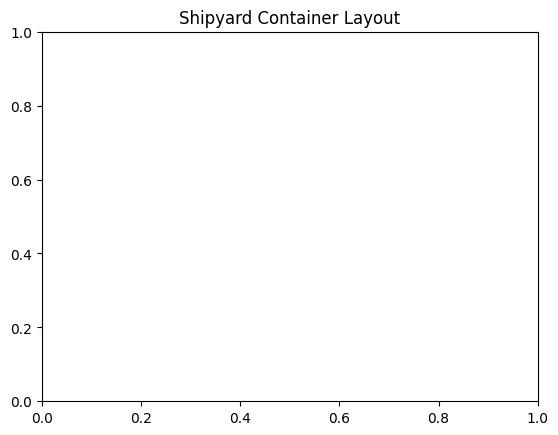

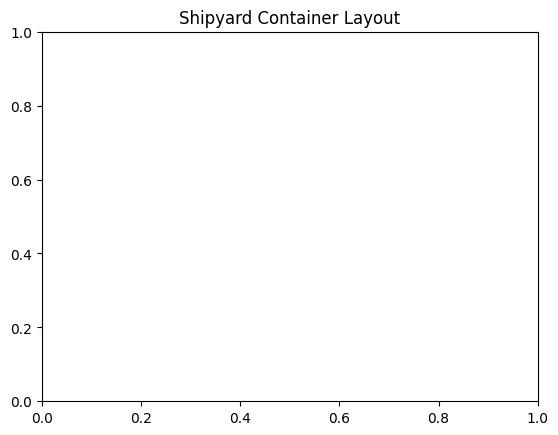

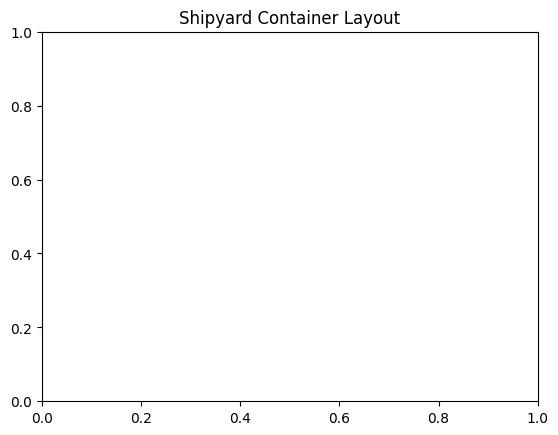

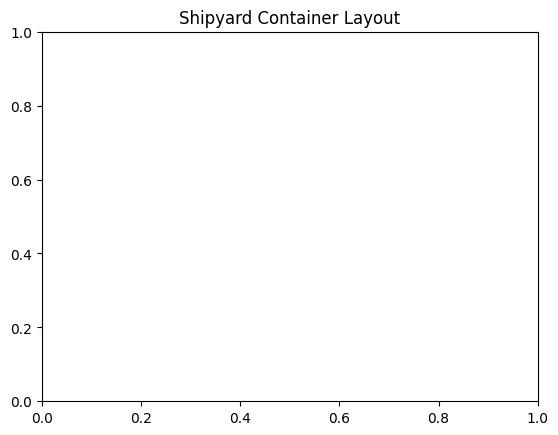

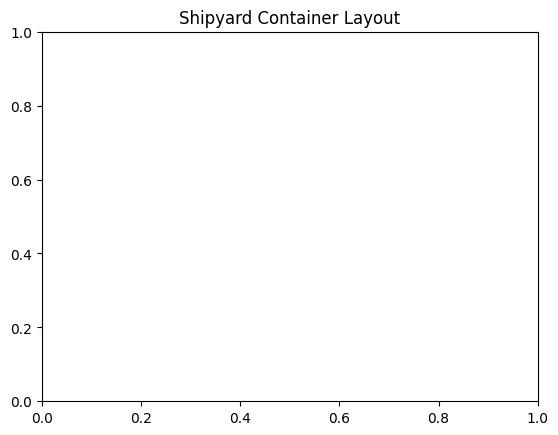

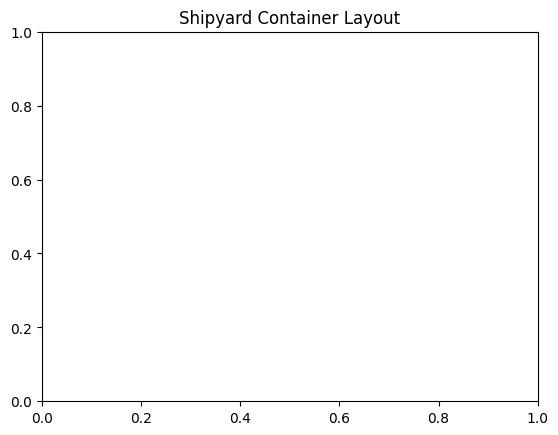

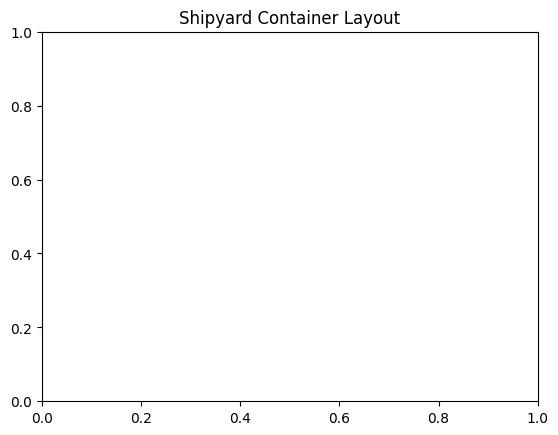

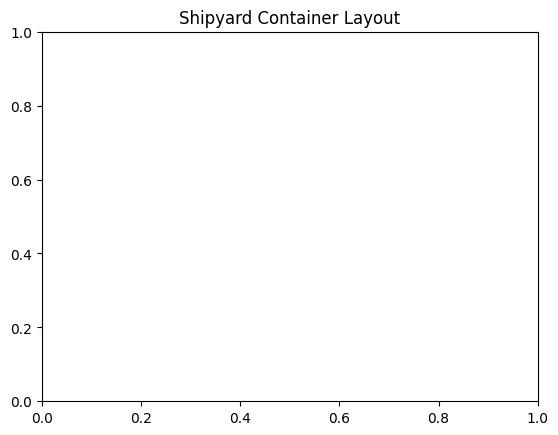

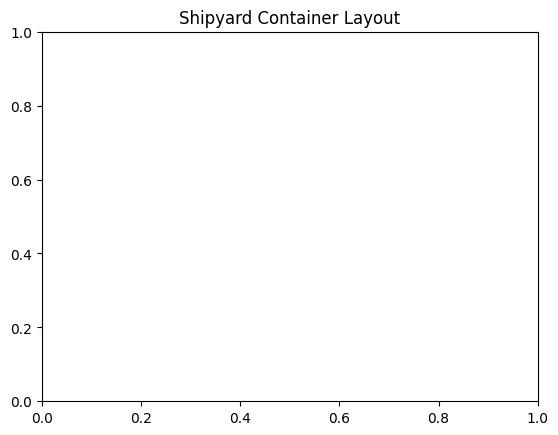

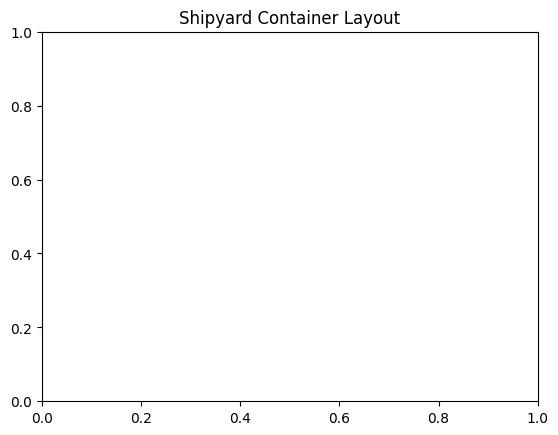

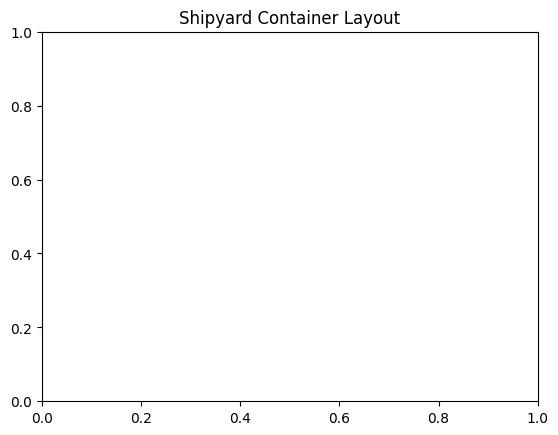

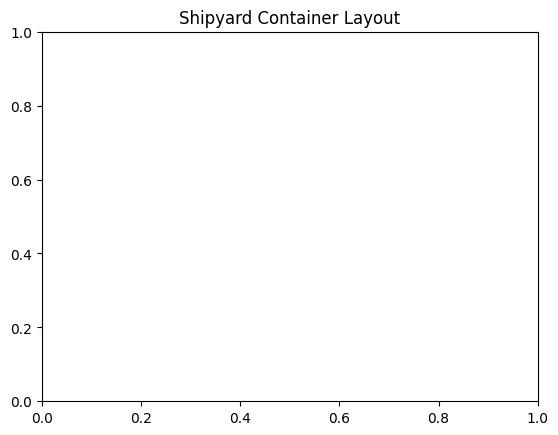

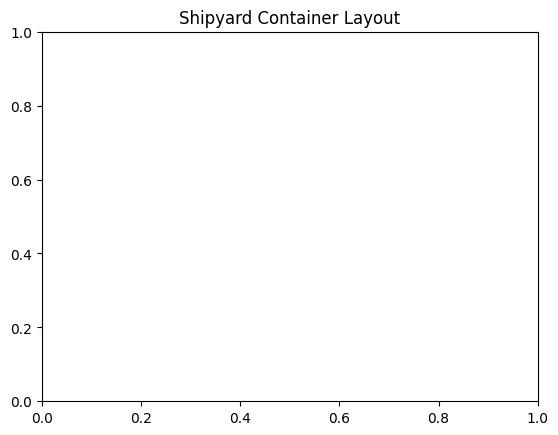

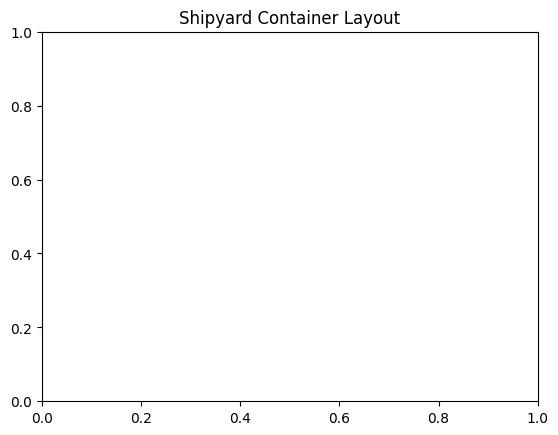

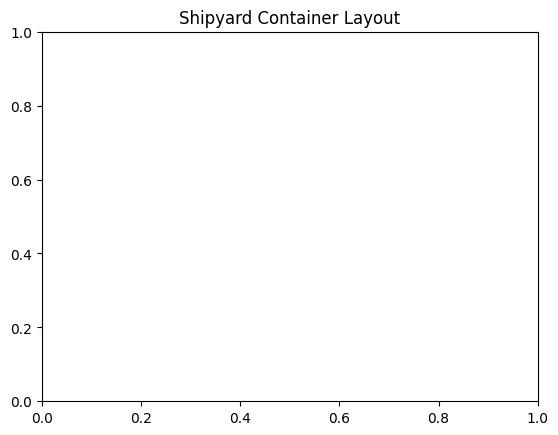

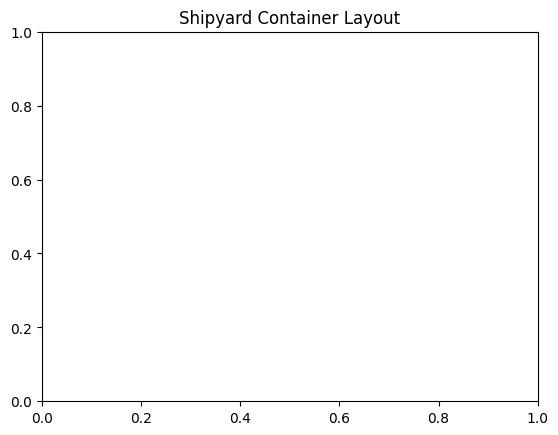

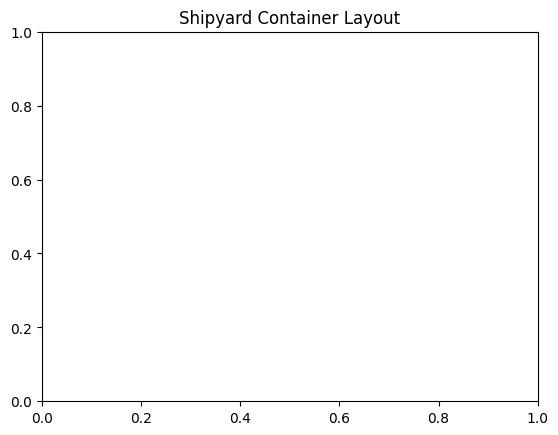

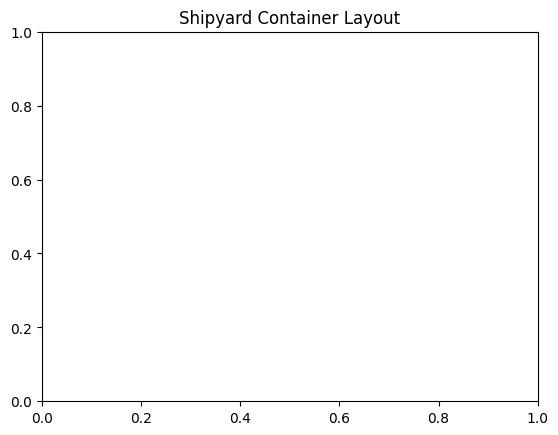

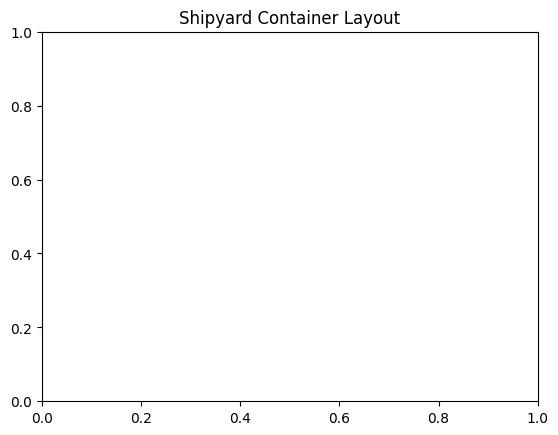

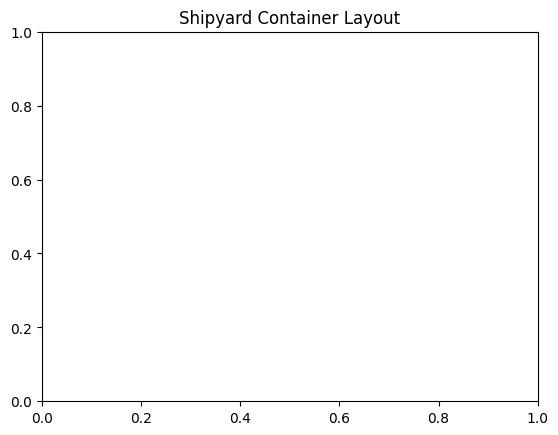

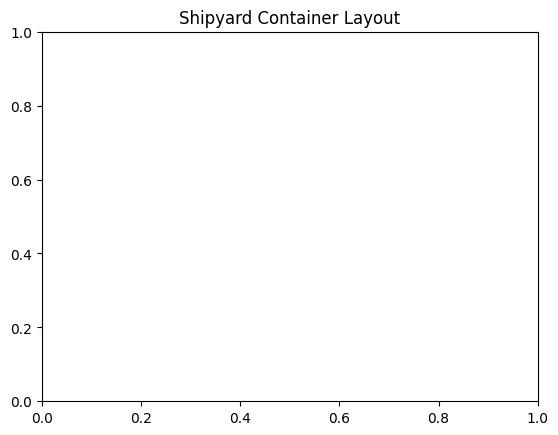

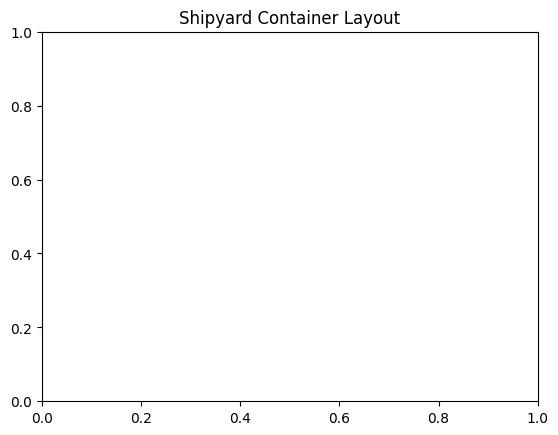

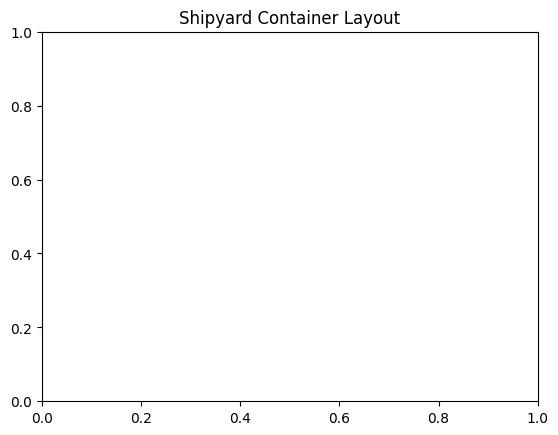

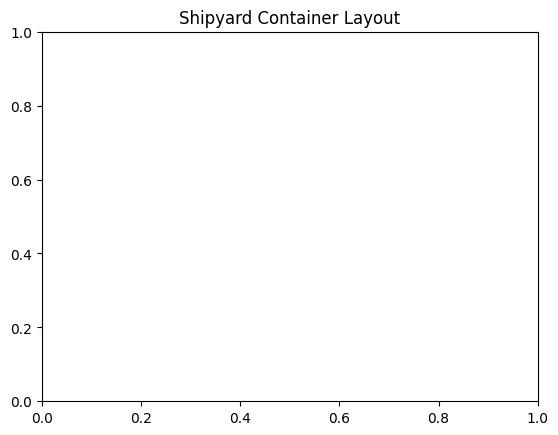

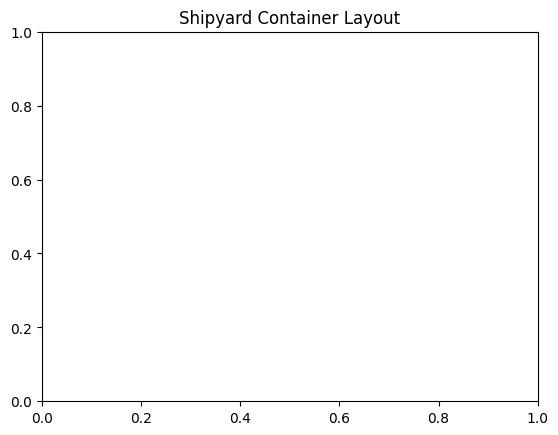

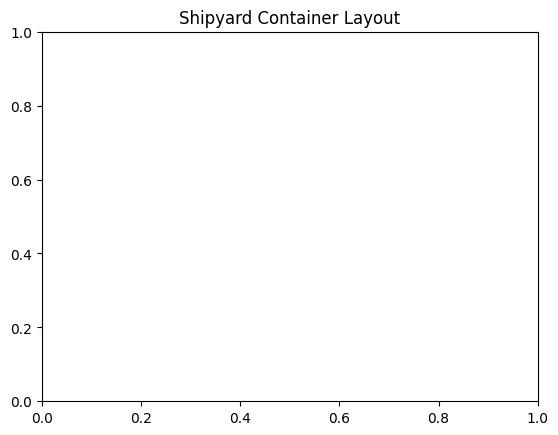

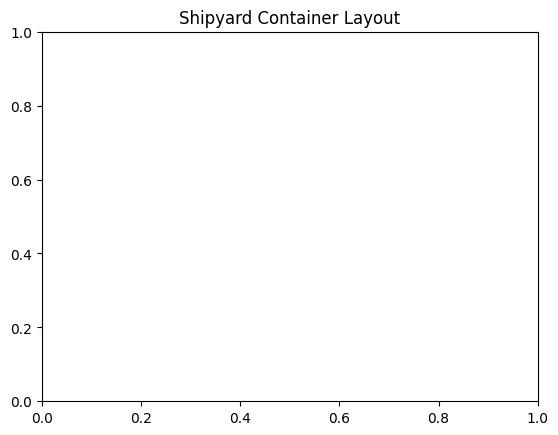

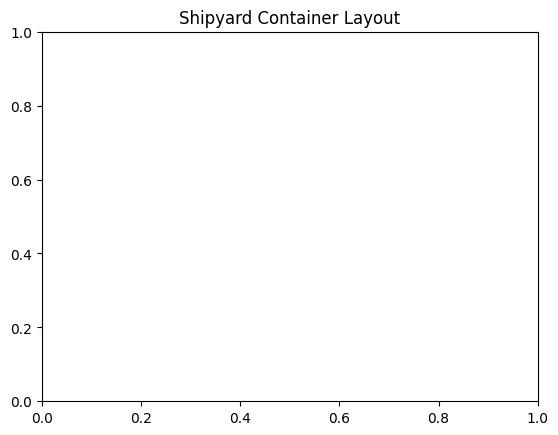

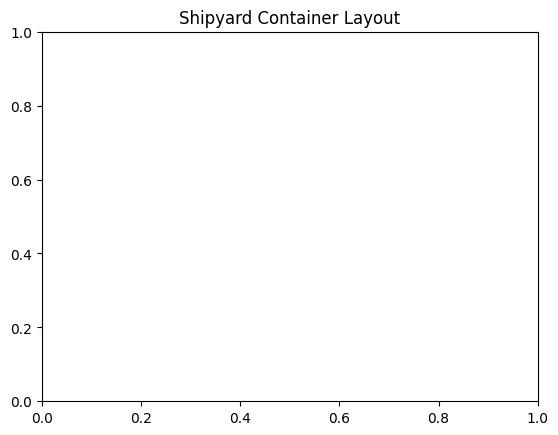

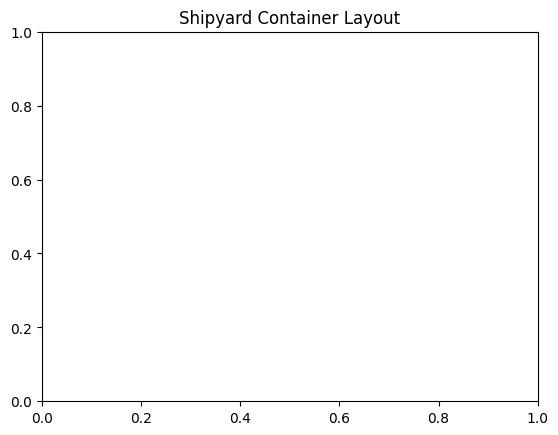

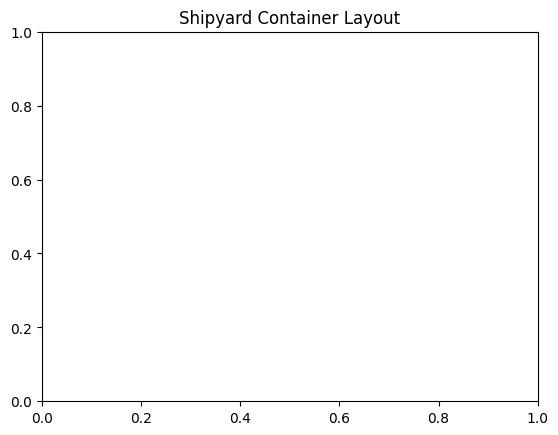

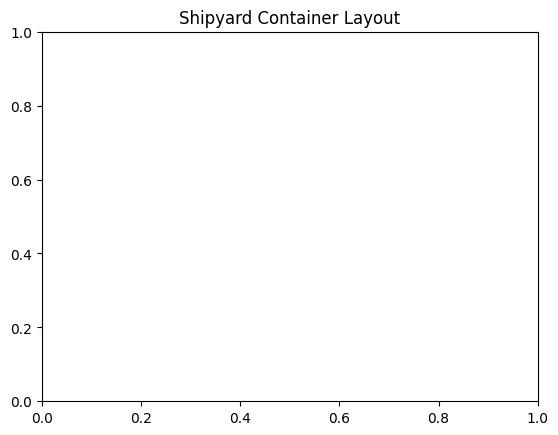

KeyboardInterrupt: 

In [4]:
# Save Q-table after training
def save_q_table(agent, filename):
    np.save(filename, agent.q_table)

# Initialize environment and agent
env = ShipyardEnv()
agent = QLearningAgent(env)

# Train the agent and visualize the process
agent.train(episodes = 50)

# Save the trained Q-table
save_q_table(agent, 'q_table.npy')

# Close the environment to stop rendering
env.close()
